In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import glob
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
list_symptoms = ['abdominal_pain','chest_pain','sore_throat','sob2','fatigue2','headache','hoarse_voice','loss_of_smell',
          'delirium','diarrhoea','fever','persistent_cough','unusual_muscle_pains','skipped_meals']
list_S = ['AP','CP','ST','SOB','FAT','HA','HV','LOS',
          'CO','DI','FV','PC','UMP','SM']
list_SE = ['ABDOMINAL PAIN','CHEST PAIN','SORE THROAT', 'SHORTNESS OF BREATH','FATIGUE','HEADACHE','HOARSE VOICE','LOSS OF SMELL',
          'CONFUSION','DIARRHOEA','FEVER','PERSISTENT COUGH','UNUSUAL MUSCLE PAINS','SKIPPED MEALS']
list_SEA = ['ABDOMINAL PAIN (AP)','CHEST PAIN (CP)','SORE THROAT (ST)', 'SHORTNESS OF BREATH (SOB)','FATIGUE (FAT)','HEADACHE (HA)','HOARSE VOICE (HV)','LOSS OF SMELL (LOS)',
          'CONFUSION (CO)','DIARRHOEA (DI)','FEVER (FV)','PERSISTENT COUGH (PC)','UNUSUAL MUSCLE PAINS (UMP)','SKIPPED MEALS (SM)']


In [4]:

#df_interp = pd.read_csv(glob.glob('All*Hosp*2104*')[0])
#df_interp = pd.read_csv('InterPostreat_FinalClust_2104.csv')
df_train = pd.read_csv('TrainTH2805.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,15,34,35,45,47,49,107,108,109,111,118,119,120,124,126,128,131,133,135,168,182,183,184,185,186,187,188,189,190,191,192,193,216,217,227,230) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# df_comb = df_concatall_clean[list_symptoms+['patient_id','interval_days','hosp_bin','test']]
def interpolate_date(df_train):
    df_train['sob2'] = np.round(df_train['shortness_of_breath']*1.0/3,0)
    df_train['fatigue2'] = np.round(df_train['fatigue']*1.0/3,0)
    df_test_comb = df_train.drop_duplicates(["interval_days", "patient_id"])

    full_idx = np.arange(df_test_comb['interval_days'].min(), df_test_comb['interval_days'].max())
    df_test_comb_ind = df_test_comb.set_index('interval_days')
    # df_test2 = df_test_comb_ind.groupby('patient_id', as_index=False).apply(lambda group: group.reindex(full_idx)).reset_index(level=0, drop=True).sort_index()
    def f_inter(x):
        x = x.reindex(full_idx)
        #     x['pid'] = x['pid'].ffill().bfill()
        x['hosp_bin'] = x['hosp_bin'].ffill().bfill()
        #     x['cluster_knn'] = x['cluster_knn'].ffill().bfill()
        for f in list_symptoms:
            x[f] = x[f].replace('False', 0)
            x[f] = x[f].replace('True', 1)
            x[f] = x[f].astype(float)
            x[f] = x[f].interpolate(method='linear',limit_area='inside')
        return (x)

    df_interp = df_test_comb_ind.groupby('patient_id').apply(f_inter).rename_axis(('patient_id','interval_days')).drop('patient_id', 1).reset_index()
    return df_interp

In [4]:

from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib as mpl
def plotting_patterns(df, classif_full,title):
    list_average_h=[]
    duration_array = []
    for p in classif_full.keys():
        test_clust1 = df[(df['patient_id'].isin(classif_full[p]))]
        df_unique = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
        duration = np.round(df_unique['max_duration'].mean(),0)
        print(duration, df_unique.shape)
        if np.isnan(duration):
            duration=8
        test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
        print(test_average_hosp.shape)
        list_average_h.append(test_average_hosp)
        duration_array.append(duration)

    fig=plt.figure(figsize=(50,20))
    from matplotlib import gridspec
    import matplotlib as mpl
    gs = gridspec.GridSpec(2, len(classif_full.keys()), width_ratios=duration_array, height_ratios=[1,0.05])
    gs.update(left=0, right=0.95, wspace=0.15, hspace=0.1)

#(0,0) PLOT                                                                                                       
    keys_class = list(classif_full.keys())
    p=0
    axh0=plt.subplot( gs[0,0] ) 
#     print(list_average_h[p])
    fin_average_hosp = np.nanmean(list_average_h[p],2)[:,:15]
    axh0.imshow(fin_average_hosp,cmap='Reds',vmin=0,vmax=0.7)
    axh0.set_yticks(np.arange(0,14))
    axh0.set_xticks(np.arange(0, duration_array[p]+1))
    axh0.set_xlim([-0.5, duration_array[p]-0.5])
    axh0.set_ylim([-0.5,13.5])
    axh0.set_yticklabels(list_SEA, fontsize=20)
    axh0.set_xlabel('Days',fontsize=20)
    axh0.set_title('Cluster %d : %d' %(keys_class[p], len(classif_full[keys_class[p]])),fontsize=30)
    for p in range(1,len(classif_full.keys())):
        axh=plt.subplot( gs[0,p],sharey=axh0 ) 
#     print(list_average_h[p])
        fin_average_hosp = np.nanmean(list_average_h[p],2)[:,:15]
        axh.imshow(fin_average_hosp,cmap='Reds',vmin=0,vmax=0.7)
        axh.set_yticks(np.arange(0,14))
        axh.set_xticks(np.arange(0, duration_array[p]+1))
        axh.set_xlim([-0.5, duration_array[p]-0.5])
        axh.set_ylim([-0.5,13.5])
        axh.set_xlabel('Days',fontsize=20)
        axh.set_yticklabels(list_S, fontsize=20)
#         if p>0:
#             plt.setp(axh.get_yticklabels(), visible=False)
        axh.set_title('Cluster %d : %d' %(keys_class[p], len(classif_full[keys_class[p]])),fontsize=30)
    

    axc=plt.subplot(gs[1,:]  )
    fig.suptitle(title, fontsize = 44)
    cmap_chosen = mpl.cm.get_cmap('Reds')
    cb1 = matplotlib.colorbar.ColorbarBase(axc, cmap=cmap_chosen, orientation='horizontal')
    cb1.ax.set_xticklabels(['0', '0.14', '0.28', '0.42', '0.56',  '0.7'], fontsize=20)

In [5]:
list_symptoms = ['abdominal_pain','chest_pain','sore_throat','sob2','fatigue2','headache','hoarse_voice','loss_of_smell',
          'delirium','diarrhoea','fever','persistent_cough','unusual_muscle_pains','skipped_meals']
list_S = ['AP','CP','ST','SOB','FAT','HA','HV','LOS',
          'CO','DI','FV','PC','UMP','SM']
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib as mpl
def plotting_patterns_fromave(list_average_h,duration_array, classif_full, title, cmap='Reds',vmin=0, vmax=0.7,save_name=None):


    fig=plt.figure(figsize=(50,12))
    from matplotlib import gridspec
    import matplotlib as mpl
    gs = gridspec.GridSpec(2, len(classif_full.keys()), width_ratios=duration_array, height_ratios=[1,0.05])
    gs.update(left=0.1, right=0.95, wspace=0.1, hspace=0.3)

#(0,0) PLOT                                                                                                       
    keys_class = list(classif_full.keys())
    p=0
    axh0=plt.subplot( gs[0,0] ) 
#     print(list_average_h[p])
    fin_average_hosp = np.nanmean(list_average_h[p],2)[:,:15]
    axh0.imshow(fin_average_hosp,cmap=cmap,vmin=vmin,vmax=vmax)
    axh0.set_yticks(np.arange(0,14))
    axh0.set_xticks(np.arange(0, duration_array[p]+1))
    axh0.set_xlim([-0.5, duration_array[p]-0.5])
    axh0.set_ylim([-0.5,13.5])
    axh0.set_yticklabels(list_SEA, fontsize=20)
    axh0.set_xlabel('Days',fontsize=20)
    axh0.set_title('Cluster %d : %d' %(keys_class[p]+1, len(classif_full[keys_class[p]])),fontsize=30)
    for p in range(1,len(classif_full.keys())):
        axh=plt.subplot( gs[0,p], ) 
#     print(list_average_h[p])
        fin_average_hosp = np.nanmean(list_average_h[p],2)[:,:15]
        axh.imshow(fin_average_hosp,cmap=cmap,vmin=vmin,vmax=vmax)
        axh.set_yticks(np.arange(0,14))
        axh.set_xticks(np.arange(0, duration_array[p]+1))
        axh.set_xlim([-0.5, duration_array[p]-0.5])
        axh.set_ylim([-0.5,13.5])
        axh.set_xlabel('Days',fontsize=20)
        axh.set_yticklabels(list_S, fontsize=20)
#         if p>0:
#             plt.setp(axh.get_yticklabels(), visible=False)
        axh.set_title('Cluster %d : %d' %(keys_class[p]+1, len(classif_full[keys_class[p]])),fontsize=30)
    

    axc=plt.subplot(gs[1,:]  )
    fig.suptitle(title, fontsize = 44)
    cmap_chosen = mpl.cm.get_cmap(cmap)
    cb1 = matplotlib.colorbar.ColorbarBase(axc, cmap=cmap_chosen, orientation='horizontal')
    cb1.ax.set_xticklabels(np.round(np.arange(vmin,vmax+0.1,(vmax-vmin)/5),2), fontsize=20)
    if save_name is not None:
        plt.savefig(save_name)

In [6]:
def create_average_evolution_withscaling(df, column, list_features, duration):
    data = df.reset_index()
    clust_agg = []
    x = np.linspace(0, duration, num=duration+1, endpoint=True)
    x_interp = interp1d(np.arange(x.size),x)
    arr1_compress = x_interp(np.linspace(0,x.size-1,x.size))
    for k in list(set(data[column])):
        temp = data[data[column]==k]
        if 'level_0' in temp.columns:
            temp = temp.drop(columns='level_0').reset_index()
        temp = temp.replace('False',0)
        temp = temp.replace('True',1)
        #print(temp.shape)
        temp2 = temp[list_features]
        temp2 = temp2.interpolate(method='linear',limit_area='inside',axis=0)
        temp2 = temp2.dropna(how='all')
        temp2 = temp2.reset_index()
        linear_interp = np.empty([len(list_symptoms),duration.astype(int)])
        linear_interp[:,:] = np.nan
        
        for (i,f) in enumerate(list_features):
            
            temp2[f] = temp2[f].astype(float)
            ind_f = temp2[f].first_valid_index()
            ind_l = temp2[f].last_valid_index()
            no_nans = temp2[f].dropna(how='any')
            tot_duration = temp2[f].shape[0]
            if no_nans.shape[0] == 0:
                continue    
            total_stretching_factor = duration * 1.0 / tot_duration
            fraction_nonans = no_nans.shape[0] / tot_duration
            len_nan_first = np.round(ind_f * total_stretching_factor,0).astype(int)
            arr2 = np.asarray(no_nans)
            if no_nans.shape[0] == 1:
#                 print(ind_f, ind_l, len_nan_first, no_nans)
                ind_plugin = np.minimum(len_nan_first, duration-1).astype(int)
                linear_interp[i,ind_plugin] = arr2[0]
            else:
                arr2_interp = interp1d(np.arange(arr2.size),arr2)
                to_change = arr2_interp(np.linspace(0,arr2.size-1, np.round(fraction_nonans*duration,0)))
                if len_nan_first + len(to_change) > duration:
                    len_nan_first -= 1
                max_ind = np.minimum(len_nan_first+len(to_change), duration).astype(int)
#                 print(duration, fraction_nonans, tot_duration, no_nans.shape[0], ind_f, ind_l, len_nan_first, len(to_change), len(arr2),max_ind)
                
                linear_interp[i,len_nan_first:max_ind] = to_change
            #             temp2[f] = temp2[f].interpolate(method='linear',limit_area='inside')    
#             new_temp = temp2[f].dropna(how='any')
#             if new_temp.shape[0] == 1:
#                 temp2[f] = temp2[f].interpolate(method='linear', limit_direction='backward')
#                 new_temp = temp2[f].dropna(how='all')
#             if new_temp.shape[0] == 0:
#                 new_temp = np.empty([2])
#                 new_temp =
#             print(temp2[f].shape, new_temp.shape, f)
# #             print(new_temp, "is temp2 when dropping nans")
#             arr2 = np.asarray(new_temp)
#             arr2_interp = interp1d(np.arange(arr2.size),arr2)
#             to_add = arr2_interp(np.linspace(0,arr2.size-1,x.size))
#             print(to_add)
#             to_add = interp1d(x, np.asarray(temp2[f]))
#             linear_interp.append(to_add)
#         temp2 = temp2.interpolate(method='linear',limit_area='inside',axis=0)
#                     temp = temp.interpolate(method='linear')
        clust_agg.append(np.expand_dims(np.asarray(linear_interp),-1))
        #print(temp2.shape)
    new_agg = np.concatenate(clust_agg,-1)
    #print(new_agg.shape, temp.shape)
#     clust_sum = np.nanmean(new_agg,-1)
    return new_agg
    
    

In [9]:
df_interp = df_train
df_interp['fatigue2'] = np.round(df_interp['fatigue']/3.0,0)
df_interp['sob2'] = np.round(df_interp['shortness_of_breath']/3.0,0)

In [7]:

def average_start_fin_freq(dfg):
    dfg_temp = dfg.dropna(subset=list_symptoms,how='all').reset_index()
    for l in range(0,int(dfg['max_duration'].max())):
        dfg_temp['mean%d_sum'%l] =0
    for f in list_symptoms:
        flag_no = 0
#         print(f,dfg[f].first_valid_index())
        if dfg[f].first_valid_index() is not None:
            dfg_temp['start_'+f] = (dfg[f].idxmax()-dfg[f].first_valid_index()) * dfg[f].max()
            if dfg[f].max() == 0:
                flag_no = 1
                dfg_temp['start_'+f] = -1
        else:
            dfg_temp['start_'+f]=-1
            flag_no = 1
        dfg_temp['sum_'+f] = dfg[f].sum()
        dfg_temp['sumrat_'+f] = dfg_temp['sum_'+f]/dfg_temp['max_duration']
        dfg_temp['startrat_'+f] = np.max(dfg_temp['start_'+f])/np.max(dfg['max_duration'])
        if flag_no == 1:
            dfg_temp['startrat_'+f] = -1
        for l in range(0,int(dfg['max_duration'].max())):
            dfg_temp['ever%d_'%l +f] = dfg_temp[f].head(l).max()
            dfg_temp['mean%d_'%l +f] = dfg_temp[f].head(l).mean()
            dfg_temp['mean%d_sum'%l] += np.nan_to_num(dfg_temp['mean%d_'%l +f])
    return dfg_temp


In [8]:
def start_sum_freq(dfg, list_symptoms):
    dfg_temp = dfg.dropna(subset=list_symptoms,how='all').reset_index()
    for l in range(0,int(dfg_temp['interval_interp'].max())):
        dfg_temp['agg%d_sum'%l] =0
    for f in list_symptoms:
        flag_no = 0
#         print(f,dfg[f].first_valid_index())
        if dfg[f].first_valid_index() is not None:
            dfg_temp['start_'+f] = (dfg[f].idxmax()-dfg[f].first_valid_index()) * dfg[f].max()
            if dfg[f].max() == 0:
                flag_no = 1
                dfg_temp['start_'+f] = -1
        else:
            dfg_temp['start_'+f]=-1
            flag_no = 1
        dfg_temp['sum_'+f] = dfg[f].sum()
        dfg_temp['sumrat_'+f] = dfg_temp['sum_'+f]/int(dfg_temp['interval_interp'].max())
        dfg_temp['startrat_'+f] = np.max(dfg_temp['start_'+f])/int(dfg_temp['interval_interp'].max())
        if flag_no == 1:
            dfg_temp['startrat_'+f] = -1
        for l in range(0,int(dfg_temp['interval_interp'].max())):
            dfg_temp['ever%d_'%l +f] = dfg_temp[f].head(l).max()
            dfg_temp['sum%d_'%l +f] = dfg_temp[f].head(l).sum()
            dfg_temp['agg%d_sum'%l] += np.nan_to_num(dfg_temp['sum%d_'%l +f])
    return dfg_temp

In [9]:
def create_classif_fromdf(df, clust_column):
    classif = {}
    for p in np.unique(df[clust_column]):
        classif[p] = df[df[clust_column]==p]['patient_id']
    return classif


def create_classif_ordered(df,clust_column):
    list_avesum = []
    classif_init = {}
    for f in np.unique(df[clust_column]):
        df_temp = df[df[clust_column]==f]
        df_ut = df_temp.sort_values('sum_symp').drop_duplicates('patient_id')
        list_avesum.append(df_ut['sum_symp'].mean())
        classif_init[f] = list(df_ut['patient_id'])
    print(list_avesum)
    classif = {}
    sorting = np.argsort(list_avesum)
    for (i,s) in enumerate(sorting):
        classif[i] = classif_init[s]
    return classif

def reorder_classif(df,classif):
    list_avesum = []
    for f in classif.keys():
        df_temp = df[df['patient_id'].isin(classif[f])]
        df_ut = df_temp.sort_values('sum_symp').drop_duplicates('patient_id')
        list_avesum.append(df_ut['sum_symp'].mean())
    print(list_avesum)
    classif_new = {}
    sorting = np.argsort(list_avesum)
    for (i,s) in enumerate(sorting):
        classif_new[i] = classif[s]
    return classif_new

def reorder_classif_hosp(df,classif):
    list_avesum = []
    for f in classif.keys():
        df_temp = df[df['patient_id'].isin(classif[f])]
        df_ut = df_temp.sort_values('sum_symp').drop_duplicates('patient_id')
        list_avesum.append(df_ut['hosp_bin'].mean())
    print(list_avesum)
    classif_new = {}
    sorting = np.argsort(list_avesum)
    for (i,s) in enumerate(sorting):
        classif_new[i] = classif[s]
    return classif_new


def allocate_cluster(df, classif, name):
    df[name] = 0
    for f in classif.keys():
        df[name] = np.where(df['patient_id'].isin(classif[f]), f, df[name])
    return df
    

# Aggregating error and calculating elbow

In [10]:
def cov_patient(df, patient, norm=True, drop='all'):
    test_init = df.loc[patient].interpolate(method='linear',
                                            limit_area='inside')
    if drop == 'any':
        test_0 = test_init.dropna(how='any')
    else:
        test_0 = test_init.dropna(how='all')
        test_0 = test_init.fillna(0)
    test_norm = test_0 - test_0.mean()
    if norm:
        cov = np.cov(np.asarray(test_norm).T)
    else:
        cov = np.cov(np.asarray(test_0).T)
    return np.nan_to_num(cov)


def create_dictcov(df_train):
    dict_cov = {}
    for f in df_train.index.levels[0]:
        dict_cov[f] = cov_patient(df_train[list_symptoms],f)
    return dict_cov
    
def create_flattened_cov(dict_cov):
    dict_flat = {}
    for (v,k) in zip(dict_cov.values(), dict_cov.keys()):
        dict_flat[k] = v[np.triu_indices(dict_cov[k].shape[0],k=0)]
    return dict_flat




        
    
    
    
    
                   

In [14]:
df_train_ind = df_train.set_index(['patient_id','interval_days'])
dict_cov = create_dictcov(df_train_ind[list_symptoms])

In [15]:
dict_flat_cov = create_flattened_cov(dict_cov)
df_cov = pd.DataFrame.from_dict(dict_flat_cov)
df_covlim = df_cov.transpose()
df_cov = df_cov.transpose()
N = df_covlim.shape[0]


In [16]:
df_cov.index

Index(['002a239ee36fcbe376cba5b9cc8891fe', '002bdfb9a4170b56d5c2190f0692e954',
       '002d412f4cbf9cd66ff55bd7067fec20', '00588e64004c491d75a109a43763f4bc',
       '00fdb85d4cc251fb50ca893d9271caa5', '012dc0c364d81096b2f4481fdffb1260',
       '0158f64b410f02c9cb9f577702da46c9', '01672f1bd74f2a9bf6e4d1d53e742605',
       '016b91a472c9475bb2905b50dbca0a7a', '018b3b16070b5ad709a0a8cfe1d47190',
       ...
       'fe8a8523480b378a7df5693e5ae99003', 'fe91f763f82fb0d53180b5f0c06fee72',
       'fe93abc7f3c26b217df67b8ec4a63ba7', 'fe9621f1e2b27da58955755b86b48fb4',
       'fe96a77b850ea243970472c8e0aed86b', 'fe9fa2f14039969902c747c5098d5a72',
       'feab149db43a43313e83db712c3484d1', 'fed4e048c742bf26d1a391b9466e8af9',
       'ff818be1bd5b346956687b68dc1de04d', 'ff96551eb7dfeefbe7a5be20aab2b40e'],
      dtype='object', length=1653)

In [17]:
# df_cov = df_cov.reset_index()
df_cov['patient_id'] = df_cov.index

In [18]:
print(N)

1653


In [19]:
list_error = glob.glob('ErrorTH2805/TH*.csv')
list_pd = []
from functools import reduce
for (i,e) in enumerate(list_error):
    df_temp = pd.read_csv(e)
    for c in df_temp.columns:
        if c not in ['patient_id','ind']:
            df_temp = df_temp.rename(columns={c: c+'_%d'%i})
    list_pd.append(df_temp)
df_error = reduce(lambda df1,df2: pd.merge(df1,df2,on='patient_id'), list_pd)

In [20]:
list_colerror = [c for c in df_error.columns if 'error' in c]
valtest = [c.strip('error') for c in list_colerror]
print(valtest[:3])
dict_error = {}
list_new = []
list_opt = []
for c in range(3,9):
    val_list = [v for v in list_colerror if 'error%d_numb'%c in v]
    list_new = []
    for n in val_list:
        list_new.append(((df_error[n])/6).sum())
    a_new = np.asarray(list_new)
    print(np.argmin(a_new), a_new[np.argmin(a_new)], val_list[np.argmin(a_new)])
    list_opt.append('clust'+val_list[np.argmin(a_new)].strip('error'))
    dict_error[c] = list_new


['9_numb0_0', '9_numb1_0', '9_numb2_0']
15 1577.1681738065708 error3_numb15_1
14 1481.3429263504836 error4_numb14_3
8 1394.235209848588 error5_numb8_6
14 1336.5415751632756 error6_numb14_4
13 1298.0640871400474 error7_numb13_5
1 1262.6807862243795 error8_numb1_2


10532.212020429313
10258.857469583314
10175.062969978142
10112.137586450332
10150.6848902577
10280.509760420657


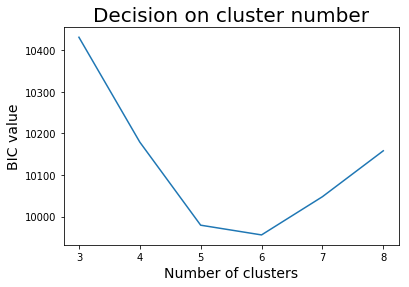

In [21]:
list_total = []
for f in dict_error.keys():
    print(np.mean(np.asarray(dict_error[f])*6)+ 45*f*np.log(1303))
    list_total.append(np.min(np.asarray(dict_error[f])*6)+45*f*np.log(1303))
plt.plot(np.arange(3,9),list_total[:7])
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('BIC value', fontsize=14)
plt.title('Decision on cluster number', fontsize=20)
plt.savefig('BICPlot.pdf')

1229.656178223467
1164.6750422658206
1142.8476421455714
1130.7688016452598
1132.5692687639396
1138.5305760069532
1150.6168613745658
1172.0321200548888
1191.4558982427297
1214.7346687732647
1245.1934201986553
1267.6100575091518
1298.1118212656183


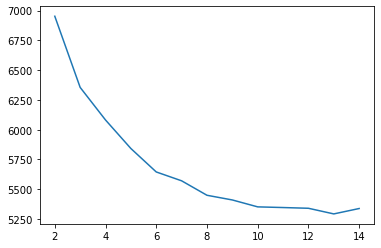

In [125]:
list_total = []
# n*log(RSS/n)+(k*3)*log(n);
for f in dict_error.keys():
    print(np.mean(np.asarray(dict_error[f]))+ 6*f*np.log(1300))
    list_total.append(np.min(np.asarray(dict_error[f])*6)+90*f)
plt.plot(np.arange(2,15),list_total)

# Plotting new clusters

In [22]:
classif_dict = {}
for (c,f) in zip(np.arange(3,9),list_opt):
    classif_opt = create_classif_fromdf(df_error,f)
# df_maxsum = allocate_cluster(df_maxsum, classif_opt6, 'classif_opt')
# df_interp4 = allocate_cluster(df_interp4, classif_opt6, 'classif_opt')
    classif_hosp = reorder_classif_hosp(df_train, classif_opt)
#     df_interp = allocate_cluster(df_interp, classif_hosp,'clust%d_opt'%c)
    classif_dict[c] = classif_hosp
    df_train = allocate_cluster(df_train, classif_hosp, 'clust%d'%c)

[0.1715076071922545, 0.35784313725490197, 0.2164750957854406]
[0.1724137931034483, 0.22714681440443213, 0.375, 0.21933962264150944]
[0.13636363636363635, 0.49047619047619045, 0.27467811158798283, 0.22546419098143236, 0.1709741550695825]
[0.16017316017316016, 0.1746031746031746, 0.2361111111111111, 0.24642857142857144, 0.4550898203592814, 0.27230046948356806]
[0.42424242424242425, 0.22131147540983606, 0.1935483870967742, 0.2554112554112554, 0.1761904761904762, 0.40853658536585363, 0.11895910780669144]
[0.29473684210526313, 0.18407960199004975, 0.26573426573426573, 0.36879432624113473, 0.15492957746478872, 0.3120567375886525, 0.3015075376884422, 0.14150943396226415]


In [23]:
def max_duration(dfg, column):
    dfg[column] = dfg['interval_days'].max() - dfg['interval_days'].min()
    return dfg
df_train = df_train.groupby('patient_id').apply(max_duration,'max_duration2')

In [24]:
df_unique = df_train.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
df_unique.groupby(['clust6','hosp_bin'])['max_duration2'].mean().unstack()

hosp_bin,0.0,1.0
clust6,,
0,8.193299,13.472973
1,7.765385,12.090909
2,7.969697,11.392157
3,8.000000,12.521739
4,7.458065,12.689655
5,7.131868,11.263158


In [27]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('age ~ clust6', data=df_unique).fit()
sm.stats.anova_lm(mod, typ=2)

,sum_sq,df,F,PR(>F)
clust6,1180.890358,1.0,8.011271,0.004705
Residual,243363.375824,1651.0,NaN,NaN


In [26]:
from scipy.stats import ttest_ind
print(ttest_ind(df_unique[df_unique['clust5']==1]['age'],df_unique[df_unique['clust5']==2]['age']))
print(ttest_ind(df_unique[df_unique['clust5']==1]['age'],df_unique[df_unique['clust5']==3]['age']))
print(ttest_ind(df_unique[df_unique['clust5']==1]['age'],df_unique[df_unique['clust5']==4]['age']))

Ttest_indResult(statistic=-3.0236328620808304, pvalue=0.0025702327731246992)
Ttest_indResult(statistic=-1.831435154942223, pvalue=0.06744076859095495)
Ttest_indResult(statistic=-2.3940189449740448, pvalue=0.01692301769843734)


In [32]:
from scipy.stats import ttest_ind
print(ttest_ind(df_unique[df_unique['clust5']==0]['age'],df_unique[df_unique['clust5']==2]['age']))
print(ttest_ind(df_unique[df_unique['clust5']==0]['age'],df_unique[df_unique['clust5']==3]['age']))
print(ttest_ind(df_unique[df_unique['clust5']==0]['age'],df_unique[df_unique['clust5']==4]['age']))

Ttest_indResult(statistic=-0.36980629963140493, pvalue=0.711686594850188)
Ttest_indResult(statistic=-0.7324259387113314, pvalue=0.46426316064537565)
Ttest_indResult(statistic=-1.6118402340274287, pvalue=0.10772701426392745)


In [ ]:
for f in 

In [28]:
from itertools import combinations
from scipy.stats import chi2_contingency
# gathering all combinations for post-hoc chi2
all_combinations = list(combinations(np.unique(df_unique['clust6']), 2))
p_vals = []
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = df_unique[(df_unique.clust5 == comb[0]) | (df_unique.clust5 == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df.groupby(['clust5','has_lung_disease']).size().unstack(), correction=True)
    p_vals.append(p)

In [29]:
from statsmodels.sandbox.stats.multicomp import multipletests

def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text



def chisq_and_posthoc_corrected(df, column_cat, column_feat):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df.groupby([column_cat,column_feat]).size().unstack().fillna(0), correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    
    # post-hoc
    all_combinations = list(combinations(np.unique(df[column_cat]), 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df[column_cat] == comb[0]) | (df[column_cat] == comb[1])]
        print(new_df.groupby([column_cat,column_feat]).size().unstack().fillna(0))
        chi2, p, dof, ex = chi2_contingency(new_df.groupby([column_cat,column_feat]).size().unstack().fillna(0), correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")

SyntaxError: invalid syntax (<ipython-input-29-3e322aad33ad>, line 25)

In [57]:
df_unique['has_lung_disease']
chisq_and_posthoc_corrected(df_unique, 'clust6', 'has_lung_disease')

Chi2 result of the contingency table: 20.304618636971362, p-value: 0.0004347833363737067
Significance results:
has_lung_disease  0.0  1.0
clust5                    
0                 244   41
1                 401   60
has_lung_disease  0.0  1.0
clust5                    
0                 244   41
2                 182   24
has_lung_disease  0.0  1.0
clust5                    
0                 244   41
3                 159   42
has_lung_disease  0.0  1.0
clust5                    
0                 244   41
4                 111   38
has_lung_disease  0.0  1.0
clust5                    
1                 401   60
2                 182   24
has_lung_disease  0.0  1.0
clust5                    
1                 401   60
3                 159   42
has_lung_disease  0.0  1.0
clust5                    
1                 401   60
4                 111   38
has_lung_disease  0.0  1.0
clust5                    
2                 182   24
3                 159   42
has_lung_disease  0.0  1.

In [30]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('bmi_clean ~ clust5', data=df_unique).fit()
sm.stats.anova_lm(mod, typ=2)
print(ttest_ind(df_unique[df_unique['clust5']==1]['bmi_clean'],df_unique[df_unique['clust5']==2]['bmi_clean']))
print(ttest_ind(df_unique[df_unique['clust5']==1]['bmi_clean'],df_unique[df_unique['clust5']==3]['bmi_clean']))
print(ttest_ind(df_unique[df_unique['clust5']==1]['bmi_clean'],df_unique[df_unique['clust5']==4]['bmi_clean']))

Ttest_indResult(statistic=-2.9281412688939565, pvalue=0.003526369822126997)
Ttest_indResult(statistic=-2.5514481524019814, pvalue=0.01095199167621842)
Ttest_indResult(statistic=-2.4646003670687833, pvalue=0.0139920300401647)


In [31]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('bmi_clean ~ clust5', data=df_unique).fit()
sm.stats.anova_lm(mod, typ=2)
print(ttest_ind(df_unique[df_unique['clust5']==0]['bmi_clean'],df_unique[df_unique['clust5']==2]['bmi_clean']))
print(ttest_ind(df_unique[df_unique['clust5']==0]['bmi_clean'],df_unique[df_unique['clust5']==3]['bmi_clean']))
print(ttest_ind(df_unique[df_unique['clust5']==0]['bmi_clean'],df_unique[df_unique['clust5']==4]['bmi_clean']))

Ttest_indResult(statistic=-2.1546022286085393, pvalue=0.03167965402538796)
Ttest_indResult(statistic=-1.8117329430723719, pvalue=0.07064712797076403)
Ttest_indResult(statistic=-1.8307958222546523, pvalue=0.06781968830885486)


In [30]:
# classif_hosp = create_classif_fromdf(df_unique3, 'clust6_new')
# df_train = df_train.drop(columns=['level_1'])
average_dict = {}
duration_dict = {}
df_train2 = df_train
df_train2 = df_train.drop(columns='patient_id')
for c in range(3,9):
    classif_full = classif_dict[c]
    list_average_h=[]
    duration_array = []
    for p in classif_full.keys():
        test_clust1 = df_train[(df_train['patient_id'].isin(classif_full[p]))]
        df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
        duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
        print(duration, df_temp.shape)
        if np.isnan(duration):
            duration=8
        test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
        test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
        print(test_average_hosp.shape)
        list_average_h.append(test_average_hosp)
        duration_array.append(duration)
    average_dict[c] = list_average_h
    duration_dict[c] = duration_array 

9.0 (723, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 723)
8.0 (522, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 522)
8.0 (408, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 408)
9.0 (580, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 580)
8.0 (424, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 424)
8.0 (361, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 361)
8.0 (288, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 288)
8.0 (330, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 330)
9.0 (503, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 503)
8.0 (377, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 377)
8.0 (233, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 233)
9.0 (210, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 210)
9.0 (462, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 462)
8.0 (315, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 315)
8.0 (216, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 216)
9.0 (280, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 280)
8.0 (213, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 213)
8.0 (167, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 167)
9.0 (269, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 269)
9.0 (210, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 210)
9.0 (403, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 403)
8.0 (244, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 244)
8.0 (231, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 231)
9.0 (164, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 164)
8.0 (132, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 132)
8.0 (212, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 212)
9.0 (426, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 426)
8.0 (201, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 201)
9.0 (143, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 143)
9.0 (190, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 190)
8.0 (199, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 199)
8.0 (141, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 141)
9.0 (141, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 141)


In [31]:
classif_full = classif_dict[6]
list_average_h=[]
duration_array = []
for p in classif_full.keys():
    test_clust1 = df_train[(df_train['patient_id'].isin(classif_full[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].mean(),0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)

9.0 (462, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 462)
9.0 (315, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 315)
9.0 (216, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 216)
9.0 (280, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 280)
9.0 (213, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 213)
9.0 (167, 275)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 167)


In [321]:
import pickle

handle = 'SavingAverageCluster3_8_Pruned.pkl'

with open('filename.pickle', 'wb') as handle:
    pickle.dump([average_dict, duration_dict], handle, protocol=pickle.HIGHEST_PROTOCOL)

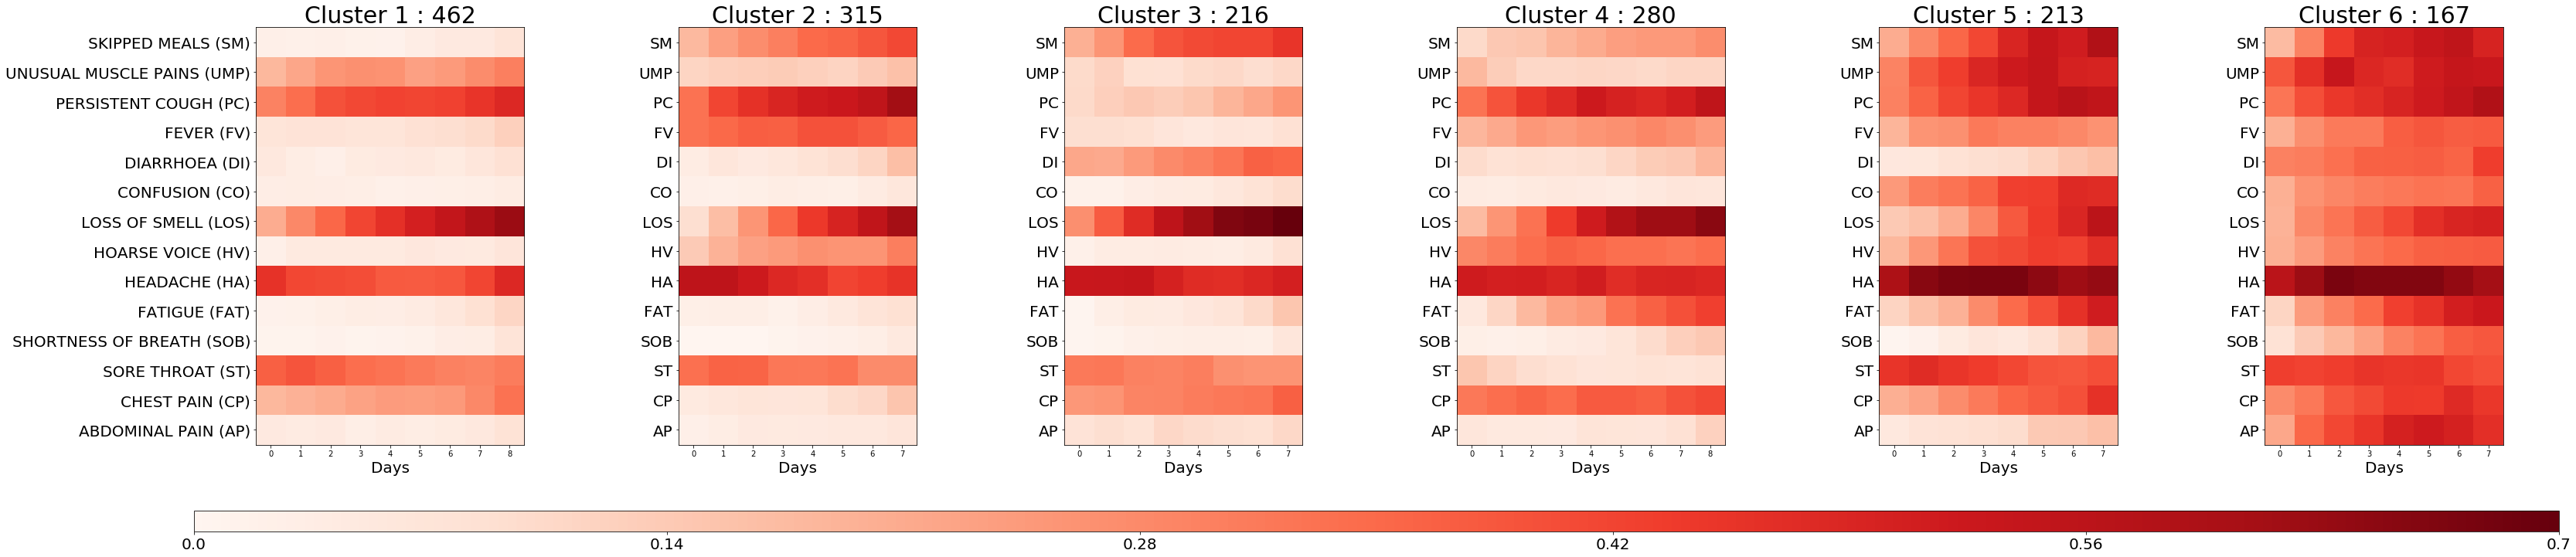

In [42]:
plotting_patterns_fromave(average_dict[6],duration_dict[6], classif_full,'',save_name='AverageClustersTrain2805Med.pdf')

In [33]:
df_unique.groupby(['clust6'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
clust6,,,,,,,,
0,462.0,41.060606,11.606930,19.0,31.00,40.0,50.75,74.0
1,315.0,43.247619,12.085245,19.0,33.00,43.0,53.00,82.0
2,216.0,40.976852,12.386956,18.0,30.00,41.0,51.00,74.0
3,280.0,43.028571,11.936476,20.0,34.75,42.0,52.00,75.0
4,213.0,43.680751,13.196321,20.0,32.00,43.0,53.00,92.0
5,167.0,43.772455,12.186145,18.0,33.00,44.0,53.00,81.0


In [36]:
df_unique = salvaging_bmi(df_unique)

In [37]:
df_unique.groupby(['clust6'])['bmi_clean'].describe()

,count,mean,std,min,25%,50%,75%,max
clust6,,,,,,,,
0,462.0,26.854520,5.479315,18.328443,22.946412,25.513114,29.697253,48.959390
1,315.0,27.305985,5.723337,18.144869,23.154442,26.014568,30.227877,51.837607
2,216.0,26.851858,5.793881,16.301646,22.631259,25.686907,30.155987,51.503188
3,280.0,27.399746,5.908541,16.640687,23.044363,26.354558,30.120939,50.034755
4,213.0,27.951256,5.865368,18.637569,24.011739,26.747870,30.872541,49.599224
5,167.0,28.887696,6.334223,19.076961,23.939874,27.822636,32.509964,50.480501


In [38]:
df_unique.groupby(['clust6'])['gender'].mean()

clust6
0    0.294372
1    0.263492
2    0.199074
3    0.167857
4    0.276995
5    0.245509
Name: gender, dtype: float64

In [39]:
for f in ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease']:
    df_unique[f] = df_unique[f].replace('False',0)
    df_unique[f] = df_unique[f].replace('True',1)
    df_unique[f] = df_unique[f].astype(float)
df_unique.groupby(['clust6','hosp_bin'])['has_diabetes'].mean().unstack()

hosp_bin,0.0,1.0
clust6,,
0,0.018041,0.040541
1,0.023077,0.072727
2,0.042424,0.039216
3,0.018957,0.072464
4,0.012903,0.120690
5,0.043956,0.052632


In [40]:
df_unique.groupby(['clust5'])['has_diabetes'].mean()

clust5
0    0.036364
1    0.021869
2    0.037135
3    0.025751
4    0.057143
Name: has_diabetes, dtype: float64

In [41]:
df_unique.groupby(['clust6','hosp_bin'])['has_lung_disease'].mean().unstack()

hosp_bin,0.0,1.0
clust6,,
0,0.141753,0.108108
1,0.107692,0.090909
2,0.103030,0.098039
3,0.170616,0.275362
4,0.174194,0.258621
5,0.164835,0.421053


In [112]:
def encode_hcw(df):
    df['hcw'] = 0
    for f in df.columns:
        if 'have_worked' in f or 'contact_health' in f:
            df['hcw'] += np.nan_to_num(df[f].astype(float))
    return df
            

In [113]:
df_unique = encode_hcw(df_unique)

In [28]:
df_unique.groupby('clust5')['hcw'].mean()

clust5
0    0.487719
1    0.420824
2    0.439614
3    0.343284
4    0.355705
Name: hcw, dtype: float64

# Create projections at different days

In [11]:
def individual_projection(df, proj, list_patient):
    list_pat = np.unique(list_patient)
    print(proj.shape, len(list_patient), len(list_pat))
    sst = np.matmul(np.asarray(proj), proj.T)
    list_projection = []
    for patient in list_pat:
        #print(patient)
        #print(df.loc[patient])
        to_use = df.loc[patient].dropna(how='all')
        projected = np.matmul(np.nan_to_num(np.asarray(to_use)), proj)
        list_projection.append(projected[-1,:])
    return np.vstack(list_projection)

def error_calculation(proj, array, drop='all',numbdays=-1):
    sst = np.matmul(np.asarray(proj), proj.T)
    array_new = array.interpolate(method='linear',limit_area='inside')
    if drop == 'any':
        array_new = array_new.dropna(how='any')
    else:
        array_new = array_new.dropna(how='all')
        array_new = array_new.fillna(0)
    if numbdays>0:
        array_new = array_new.head(numbdays)
    #print(array_new.shape,array.shape)
    projected = np.matmul(np.asarray(array_new),sst)
    #print(array, projected)
    error = np.sqrt(np.sum(np.square(np.asarray(array_new-projected))))
    #print("error is ", error)
    return error

def projection_cluster(df, patient_list, numb_dim=2,drop='all',numbdays=-1):
    cov_fin = np.zeros([len(df.columns), len(df.columns)])
    #print(cov_fin.shape)
    if len(patient_list) == 0:
        print("no patient in the list")
        return cov_fin
    for patient in patient_list:
        cov_temp = cov_patient(df, patient, drop=drop,numbdays=numbdays)
        cov_temp = np.nan_to_num(cov_temp)
        #print(cov_temp)
        cov_fin += cov_temp
    cov_fin /= len(patient_list)
    #print(cov_fin)
    u, s, v = np.linalg.svd(cov_fin)
#     print(u.shape,s.shape,v.shape)
#     print(np.asarray(u)[:,:numb_dim].shape, u.shape,numb_dim)
    u_array = np.asarray(u)
#     print(u_array.shape, numb_dim, 'u_array shape')
    return u_array[:,:numb_dim]

def cov_patient(df, patient, min_max=True, drop='all',numbdays=-1):
    test_init = df.loc[patient].interpolate(method='linear',limit_area='inside')
    if drop=='any':
        test_0 = test_init.dropna(how='any')
    else:
        test_0 = test_init.dropna(how='all')
        test_0 = test_init.fillna(0)
    if numbdays > 0:
        test_0 = test_0.head(numbdays)
    test_norm = (test_0 - test_0.mean())/test_0.std() + (test_0.mean())/(test_0.max()-test_0.min()) * test_0.max()
    cov = np.cov(np.asarray(test_0).T)
    return cov

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

def DTWDistance(s1, s2,w):
    DTW={}
    s1b = np.asarray(s1[~np.isnan(s1)])
    s2b = np.asarray(s2[~np.isnan(s2)])
    #print(s1b, s2b, s1, s2)
    w = np.max([w, abs(len(s1)-len(s2))])
    #print(w)
    
    for i in range(-1,len(s1b)):
        for j in range(-1,len(s2b)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1b)):
        for j in range(max(0, i-w), min(len(s2b), i+w)):
            dist= (s1b[i]-s2b[j])**2
            DTW[(i, j)] = dist + np.min([DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)]])

    return np.sqrt(DTW[len(s1b)-1, len(s2b)-1])

In [12]:
def create_silhouette_value(df, classif, numb_dim=6,drop='all'):
    list_patients = list(set(df.index.levels[0]))
    proj_centroids = {}
    label = np.zeros(len(list_patients))
    error_array = np.zeros([len(classif.keys()), len(list_patients)])
    
    for (i,c_ind) in enumerate(classif.keys()):
        patient_clust = classif[c_ind]
#         print(len(patient_clust), patient_clust)
        proj_centroids[c_ind] = projection_cluster(df, patient_clust, numb_dim, drop, -1)
        for (p_ind, patient) in enumerate(list_patients):
            error_array[i, p_ind] = error_calculation(proj_centroids[c_ind], df.loc[patient], drop, -1)
            if patient in list(patient_clust):
                label[p_ind] = c_ind
#         print(np.unique(label))
    return silhouette_score(error_array.T, label.T)
        

In [13]:
def create_silhouette_cov(dict_cov, classif):
    list_patients = list(dict_cov.keys())
    array_cov  = create_array_fromcov(dict_cov)
    label = np.zeros(len(list_patients))
    
    for (i,c_ind) in enumerate(classif.keys()):
        patient_clust = classif[c_ind]
        for (p_ind, patient) in enumerate(list_patients):
            if patient in list(patient_clust):
                label[p_ind] = c_ind
#         print(np.unique(label))
    return silhouette_score(array_cov, label)

In [14]:
def create_silhouette_covproj(df, proj, classif):
    list_patient = list(set(df.index.levels[0]))
    array_proj = individual_projection(df, proj, list_patient)
    label = np.zeros(len(list_patient))
    for (i,c_ind) in enumerate(classif.keys()):
        patient_clust = classif[c_ind]
        for (p_ind, patient) in enumerate(list_patient):
            if patient in list(patient_clust):
                label[p_ind] = c_ind
#         print(np.unique(label))
    return silhouette_score(array_proj, label)

In [ ]:
def create_sil_covproj(dict_cov, dict_proj, dict_classif)

In [15]:
def create_array_fromcov(dict_cov):
    array_cov = np.zeros([len(list(dict_cov.keys())), 14*14 ])
    for (i,f) in enumerate(list(dict_cov.keys())):
        array_cov[i,:] = np.reshape(np.nan_to_num(dict_cov[f]),-1)
    return array_cov
        

In [16]:
def create_dict_cov(df):
    dict_cov = {}
    list_patients = df.index.levels[0]
    for p in list_patients:
        dict_cov[p] = cov_patient(df, p, min_max=True, drop='all')
    return dict_cov

In [17]:
def attribution(df, proj, drop='all',numbdays=-1):
    num_clust = len(proj.keys())
    list_patients = list(set(df.index.levels[0]))
    error_array = np.zeros([num_clust, len(list_patients)])
    new_classif = {}
    for (i,c_ind) in enumerate(proj.keys()):
        for (p_ind, patient) in enumerate(list_patients):
            error_array[i, p_ind] = error_calculation(proj[c_ind], df.loc[patient], drop, numbdays)
    cluster_attribution = np.argmin(error_array,0)
    mean_error = []
    error = {}
    for (i, c_ind) in enumerate(proj.keys()):
#         print(np.where(cluster_attribution==i)[0])
        patient_clust = [pat for (p,pat) in enumerate(list_patients) if p in np.where(cluster_attribution==i)[0]]
        new_classif[c_ind] = patient_clust
        mean_error.append(np.mean(error_array[i,np.where(cluster_attribution==i)[0]]))
        error[c_ind] = error_array[i,np.where(cluster_attribution==i)[0]]
    return new_classif, np.mean(mean_error), error

In [18]:
def calculation_centroid(df, classif, numb_dim=2,drop='all',new_col='new_attribution',numbdays=-1):
    proj_centroids={}
    num_clust = len(classif.keys())
    list_patients = list(set(df.index.levels[0]))
    
#     print(list_patients)
    error_array = np.zeros([num_clust, len(list_patients)])
    
    for (i,c_ind) in enumerate(classif.keys()):
        patient_clust = classif[c_ind]
        proj_centroids[c_ind] = projection_cluster(df, patient_clust, numb_dim, drop, numbdays)
        for (p_ind, patient) in enumerate(list_patients):
            error_array[i, p_ind] = error_calculation(proj_centroids[c_ind], df.loc[patient], drop, numbdays)
                #print(error_array[c_ind,p_ind])
    cluster_attribution = np.argmin(error_array, 0)
    return proj_centroids, cluster_attribution,list_patients

In [51]:
def encode_symptoms(df):
    searchfor_ump= ['achy','aching','muscle','myalgia','muscular']
    df['other_symptoms'] =df['other_symptoms'].fillna('none')
    df['other_symptoms'] = df['other_symptoms'].replace(-1,'none')
    print(df['other_symptoms'])
    df_ump = df[df['other_symptoms'].str.contains('|'.join(searchfor_ump))]
    print(len(list(set(df_ump.index.levels[0]))))
    df['unusual_muscle_pains'] = np.where(df['other_symptoms'].str.contains('|'.join(searchfor_ump)),1,df['unusual_muscle_pains'])
    return df

df_interp_ind = df_interp.set_index(['patient_id','interval_days'])
df_interp_ind = encode_symptoms(df_interp_ind)

patient_id                        interval_days
002a239ee36fcbe376cba5b9cc8891fe  6                                                         none
                                  7                                                         none
                                  8                                                         none
                                  9                                                         none
                                  10                                                        none
                                  11                                                        none
                                  12                                                        none
                                  13                                                        none
                                  14                                                        none
                                  15                                           

In [26]:
df_unique = df_train.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
classif_max = create_classif_fromdf(df_unique,'clust6')
df_interp_ind = df_train.set_index(['patient_id','interval_days'])
proj, clust, pat_list = calculation_centroid(df_interp_ind[list_symptoms], classif_max,numb_dim=6)

In [305]:

classif_train,mean_train, error_train = attribution(df_train_ind[list_symptoms], proj)

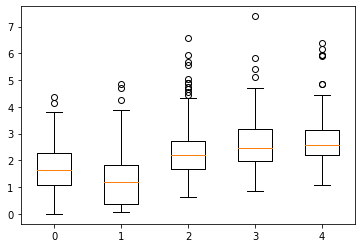

In [306]:
labels, data = error_train.keys(), error_train.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [35]:
# Calculate projections using limited number of days:
dict_proj ={}
dict_clust = {}
dict_pat = {}
for d in range(2,10):
    print('Treating day %d' %d)
    df_train_ind = df_train.set_index(['patient_id','interval_days'])
    clt_hosp = create_classif_fromdf(df_unique, 'clust6')
    projd, clustd, pat_listd = calculation_centroid(df_train_ind[list_symptoms], clt_hosp, numb_dim=6,drop='all',new_col='new_attribution',numbdays=d)
    dict_proj[d] = projd
    dict_clust[d] = clustd
    dict_pat[d] = pat_listd

Treating day 2
Treating day 3
Treating day 4
Treating day 5
Treating day 6
Treating day 7
Treating day 8
Treating day 9


In [36]:
df_attribution = pd.DataFrame([np.arange(0,len(dict_pat[2])).T, dict_pat[2]])
df_attribution = df_attribution.transpose()
df_attribution.columns = ['ind','patient_id']

In [37]:
for d in range(2,10):
    print(np.unique(dict_clust[d]))
    classif_temp = {}
    clust = dict_clust[d]
    list_pat = dict_pat[d]
    for f in np.unique(dict_clust[d]):
        classif_temp[f] = [l for (i,l) in enumerate(list_pat) if clust[i]==f]
    df_attribution = allocate_cluster(df_attribution,classif_temp,'clustproj_%ddays'%d)


[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [38]:
df_attribution = allocate_cluster(df_attribution,clt_hosp, 'clustfull')


# Define Z-Score wrt Average occurrence

In [57]:
df_train = df_train.reset_index(drop=True)
for f in list_symptoms:
    df_train['mean_'+f] = df_train.groupby('patient_id')[f].transform('mean')
    df_train['std_'+f] = df_train.groupby('patient_id')[f].transform('std')
    df_train['max_'+f] = df_train.groupby('patient_id')[f].transform('max')
df_unique2 = df_train.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')

In [58]:
df_zscore = df_train[list_symptoms+['patient_id','max_duration2','interval_days']]

In [59]:
for f in list_symptoms:
    df_zscore['z_'+f] = (df_train[f] - df_unique2['mean_'+f].mean()) / df_unique2['mean_'+f].std()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
average_dictz = {}
duration_dictz = {}
list_z = ['z_'+s for s in list_symptoms]
classif_full = clt_hosp
list_average_h=[]
duration_array = []
for p in classif_full.keys():
    test_clust1 = df_zscore[(df_zscore['patient_id'].isin(classif_full[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_z,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictz[6] = list_average_h
duration_dictz[6] = duration_array

9.0 (462, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 462)
8.0 (315, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 315)
8.0 (216, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 216)
9.0 (280, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 280)
8.0 (213, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 213)
8.0 (167, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 167)


In [61]:
average_dictb = {}
duration_dictb = {}
list_z = ['z_'+s for s in list_symptoms]
classif_full = clt_hosp
list_average_h=[]
duration_array = []
for p in classif_full.keys():
    test_clust1 = df_zscore[(df_zscore['patient_id'].isin(classif_full[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictb[6] = list_average_h
duration_dictb[6] = duration_array

9.0 (462, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 462)
8.0 (315, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 315)
8.0 (216, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 216)
9.0 (280, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 280)
8.0 (213, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 213)
8.0 (167, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 167)


In [173]:
df_unique.groupby(['clust6','max_treat']).size().unstack()

max_treat,-1.0,0.0,1.0,2.0,3.0,4.0
clust6,,,,,,
0,22.0,426.0,3.0,4.0,6.0,1.0
1,9.0,284.0,2.0,6.0,12.0,2.0
2,7.0,200.0,1.0,NaN,8.0,NaN
3,9.0,243.0,1.0,3.0,20.0,4.0
4,3.0,182.0,2.0,5.0,15.0,6.0
5,7.0,118.0,4.0,5.0,24.0,9.0


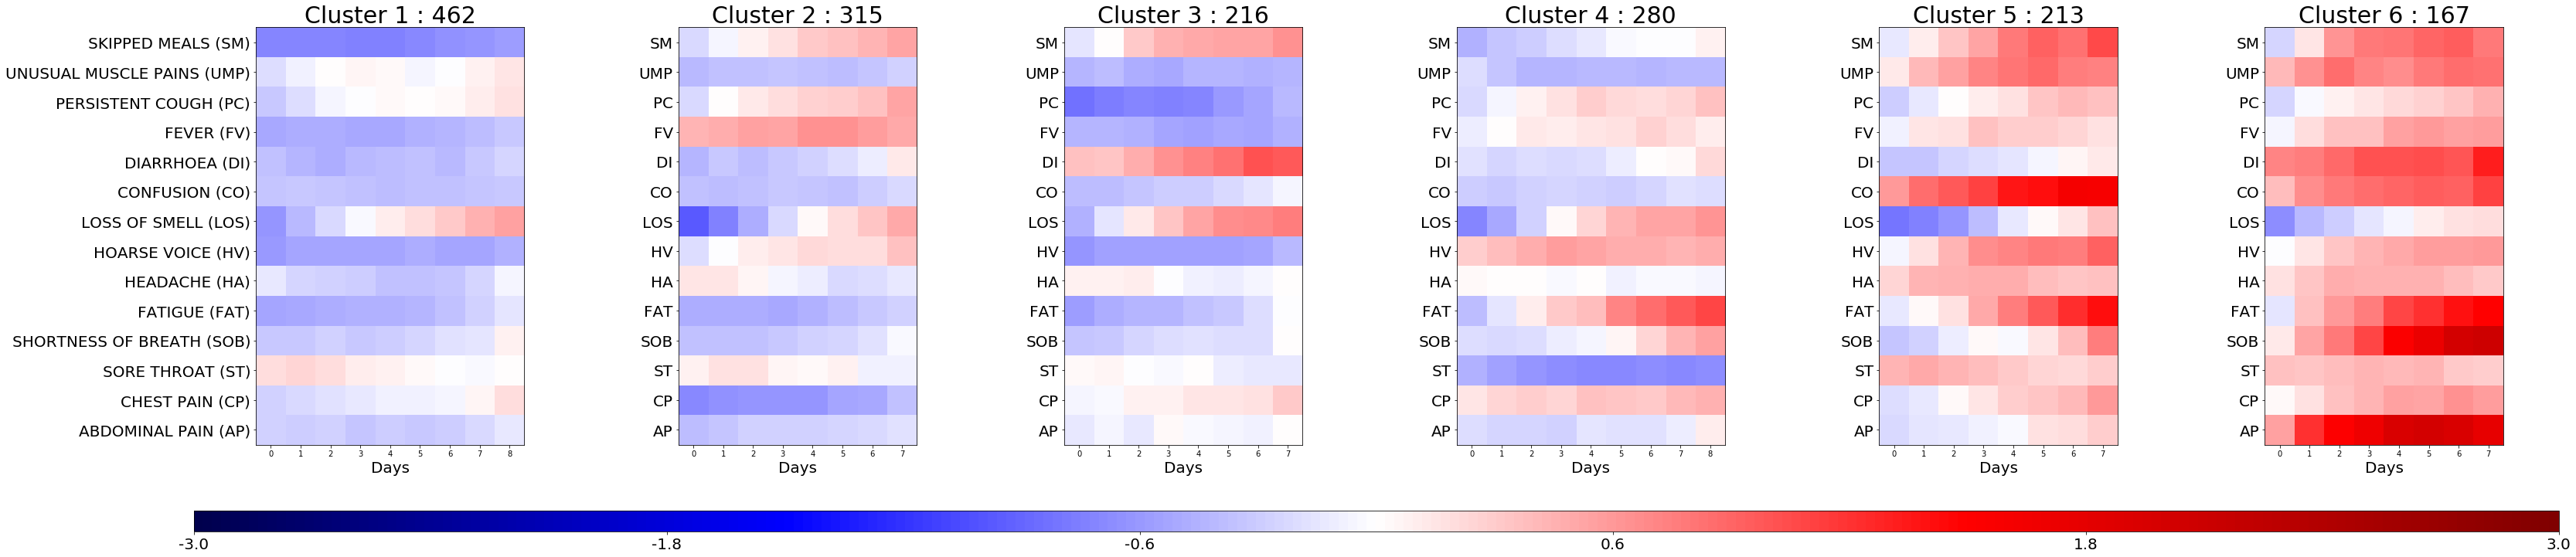

In [62]:
plotting_patterns_fromave(average_dictz[6],duration_dictz[6], clt_hosp,'',cmap='seismic',vmin=-3,vmax=3,save_name='ZScoreTrain2805.pdf')

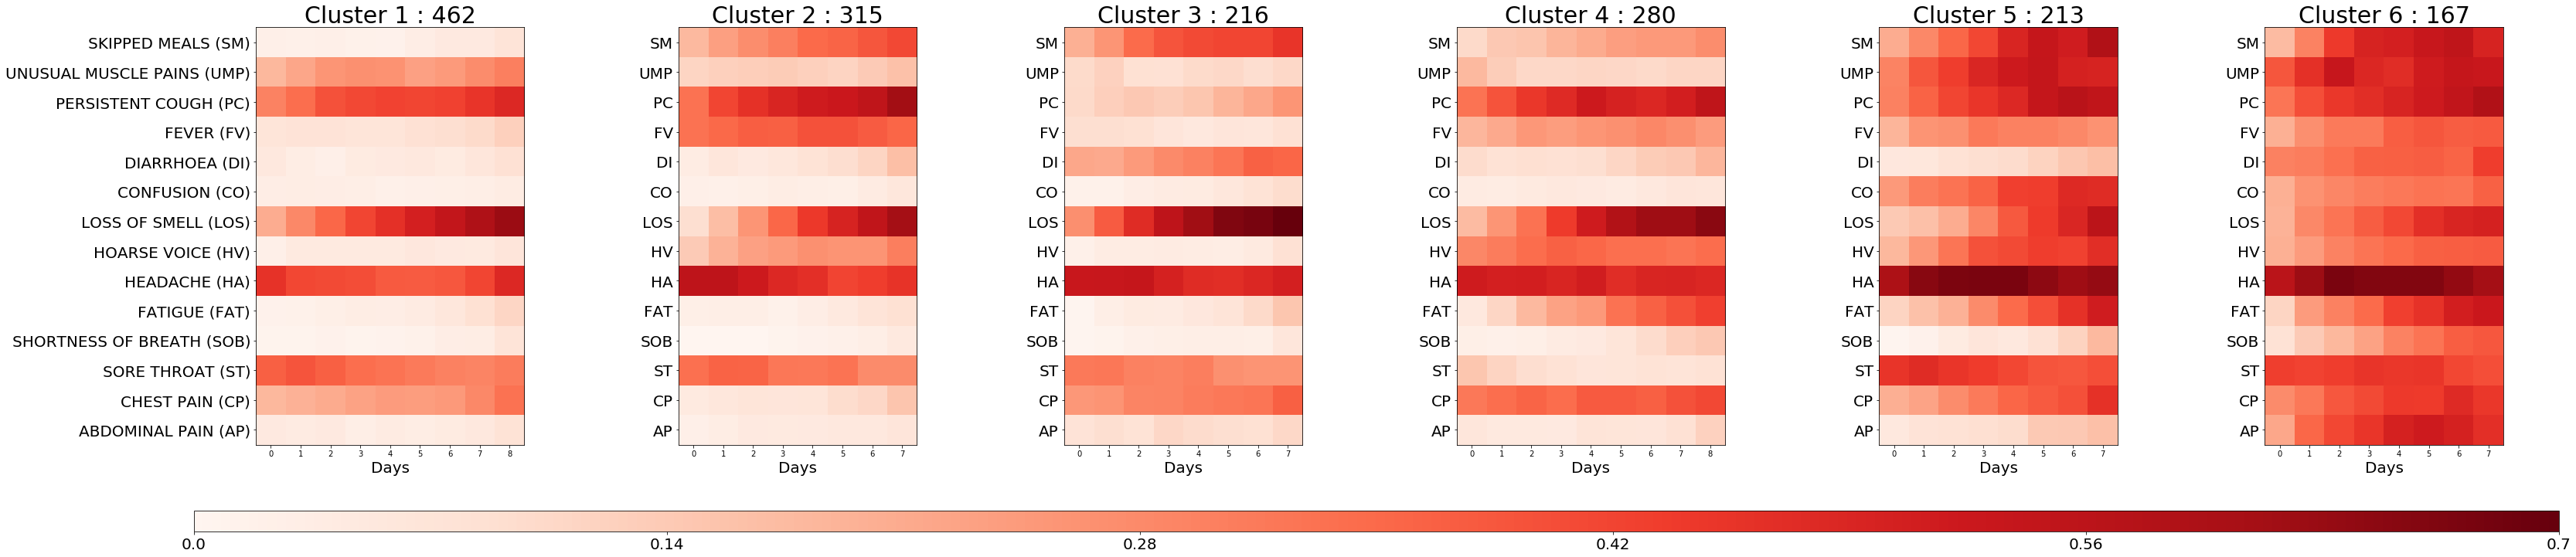

In [63]:
plotting_patterns_fromave(average_dictb[6],duration_dictb[6], clt_hosp,'',cmap='Reds',vmin=0,vmax=0.7)

In [237]:
df_unique3[df_unique3['max_duration2']>4].shape

(1401, 1486)

In [54]:
df_utest['hosp_bin'].sum()

210.0

In [281]:
# Cluster demographics

(array([0.00601375, 0.05756014, 0.09536082, 0.0661512 , 0.04725086,
       0.03178694, 0.01460481, 0.00429553, 0.00687285, 0.00171821,
       0.00171821, 0.        ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00512821, 0.05384615, 0.08333333, 0.07179487, 0.05512821,
       0.02564103, 0.01794872, 0.00897436, 0.00769231, 0.        ,
       0.00128205, 0.0025641 ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00606061, 0.05454545, 0.09494949, 0.06868687, 0.03636364,
       0.03636364, 0.01414141, 0.01212121, 0.0020202 , 0.0020202 ,
       0.0040404 , 0.0020202 ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.01105845, 0.0521327 , 0.07582938, 0.07109005, 0.04897314,
       0.02369668, 0.02685624, 0.01421801, 0.00315956, 0.00157978,
       0.00473934, 0.        ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00430108, 0.04301075, 0.07956989, 0.08602151, 0.04516129,
       0.0322580

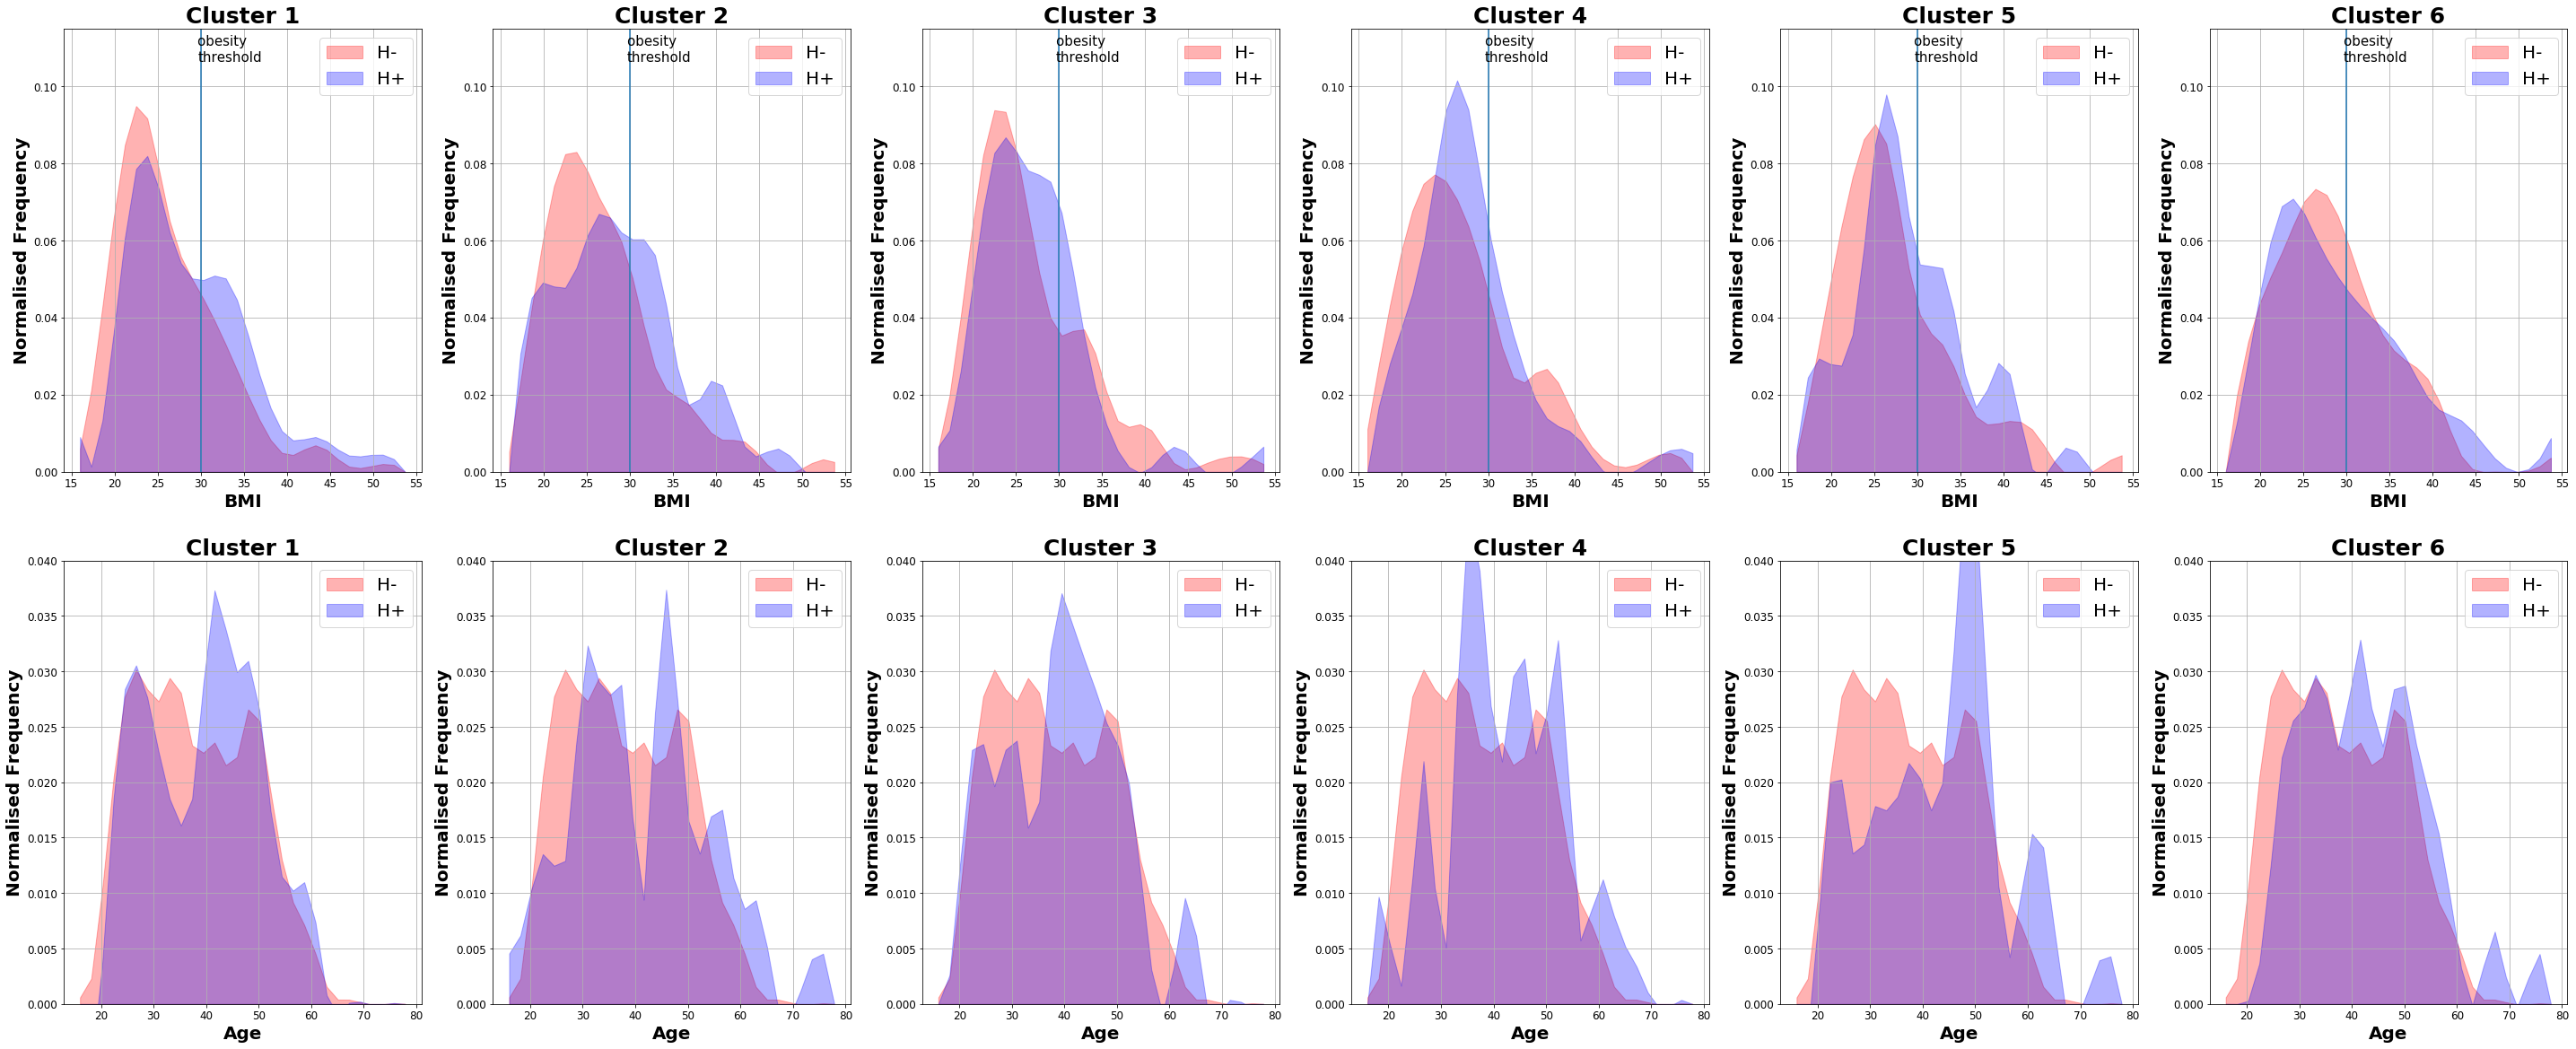

In [65]:
from scipy.interpolate import interp1d, CubicSpline

fig, ax = plt.subplots(2,6,figsize=(50,20))
for f in range(0,6):
    data_th = np.histogram(df_unique[(df_unique['hosp_bin']==1) & (df_unique['clust6']==f)]['bmi_clean'],density=True, bins=np.arange(16,55,3))
    data_tnh = np.histogram(df_unique[(df_unique['hosp_bin']==0) & (df_unique['clust6']==f)]['bmi_clean'],density=True, bins=np.arange(16,55,3))
    print(data_tnh)
    arr2_interp = CubicSpline(np.arange(data_th[0].size),data_th[0])
    to_add_th = arr2_interp(np.linspace(0,data_th[0].size-1,30))
    arr2_interp = CubicSpline(np.arange(data_tnh[0].size),data_tnh[0])
    to_add_tnh = arr2_interp(np.linspace(0,data_tnh[0].size-1,30))
    
    ax[0,f].fill_between(np.arange(16,55,(55-16)/len(to_add_tnh)),to_add_tnh,alpha=0.3, color='red')
    ax[0,f].fill_between(np.arange(16,55,(55-16)/len(to_add_th)),to_add_th,alpha=0.3,color='blue')
    ax[0,f].set_xlabel('BMI',fontsize=20,fontweight='bold')
    ax[0,f].set_ylabel('Normalised Frequency',fontsize=20,fontweight='bold')
    ax[0,f].set_title('Cluster %d' %(f+1),fontsize=25, fontweight='bold')
    ax[0,f].legend(['H-','H+'],fontsize=20)
    ax[0,f].set_ylim([0,0.115])
    ax[0,f].grid()
    ax[0,f].tick_params(labelsize=12)
    ax[0,f].plot(np.ones([9])*30, np.arange(0,0.9,0.1))
    ax[0,f].annotate('obesity \nthreshold',fontsize=15,
            xy=(0.6, 0.9), xycoords='axes fraction',
            xytext=(-90, 10), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')
    
    data_th = np.histogram(df_unique[(df_unique['hosp_bin']==1) & (df_unique['clust6']==f)]['age'],density=True, bins=np.arange(16,90,4))
    data_tnh = np.histogram(df_unique[df_unique['hosp_bin']==0 & (df_unique['clust6']==f)]['age'],density=True, bins=np.arange(16,90,4))
    arr2_interp = CubicSpline(np.arange(data_th[0].size),data_th[0])
    to_add_th = arr2_interp(np.linspace(0,data_th[0].size-1,30))
    arr2_interp = CubicSpline(np.arange(data_tnh[0].size),data_tnh[0])
    to_add_tnh = arr2_interp(np.linspace(0,data_tnh[0].size-1,30))
    
    ax[1,f].fill_between(np.arange(16,80,(80-16)/len(to_add_tnh)),to_add_tnh,alpha=0.3,color='red')
    ax[1,f].fill_between(np.arange(16,80,(80-16)/len(to_add_th)),to_add_th,alpha=0.3, color='blue')
    ax[1,f].set_xlabel('Age',fontsize=20,fontweight='bold')
    ax[1,f].set_ylabel('Normalised Frequency',fontsize=20,fontweight='bold')
    ax[1,f].set_title('Cluster %d' %(f+1),fontsize=25, fontweight='bold')
    ax[1,f].legend(['H-','H+'],fontsize=20)
    ax[1,f].set_ylim([0,0.04])
    ax[1,f].grid()
    ax[1,f].tick_params(labelsize=12)



(array([0.00659341, 0.05347985, 0.09377289, 0.06666667, 0.04761905,
       0.03443223, 0.01538462, 0.00512821, 0.00659341, 0.0014652 ,
       0.0021978 , 0.        ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00442968, 0.05426357, 0.0786268 , 0.0730897 , 0.05647841,
       0.02879291, 0.01771872, 0.00996678, 0.00664452, 0.        ,
       0.00110742, 0.00221484]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00480769, 0.05128205, 0.09294872, 0.07211538, 0.04166667,
       0.03685897, 0.01282051, 0.00961538, 0.00320513, 0.00160256,
       0.00320513, 0.00320513]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00911458, 0.04817708, 0.07421875, 0.07552083, 0.05208333,
       0.02734375, 0.02473958, 0.01302083, 0.00260417, 0.00130208,
       0.00520833, 0.        ]), array([16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]))
(array([0.00520833, 0.04166667, 0.07118056, 0.09027778, 0.05208333,
       0.0329861

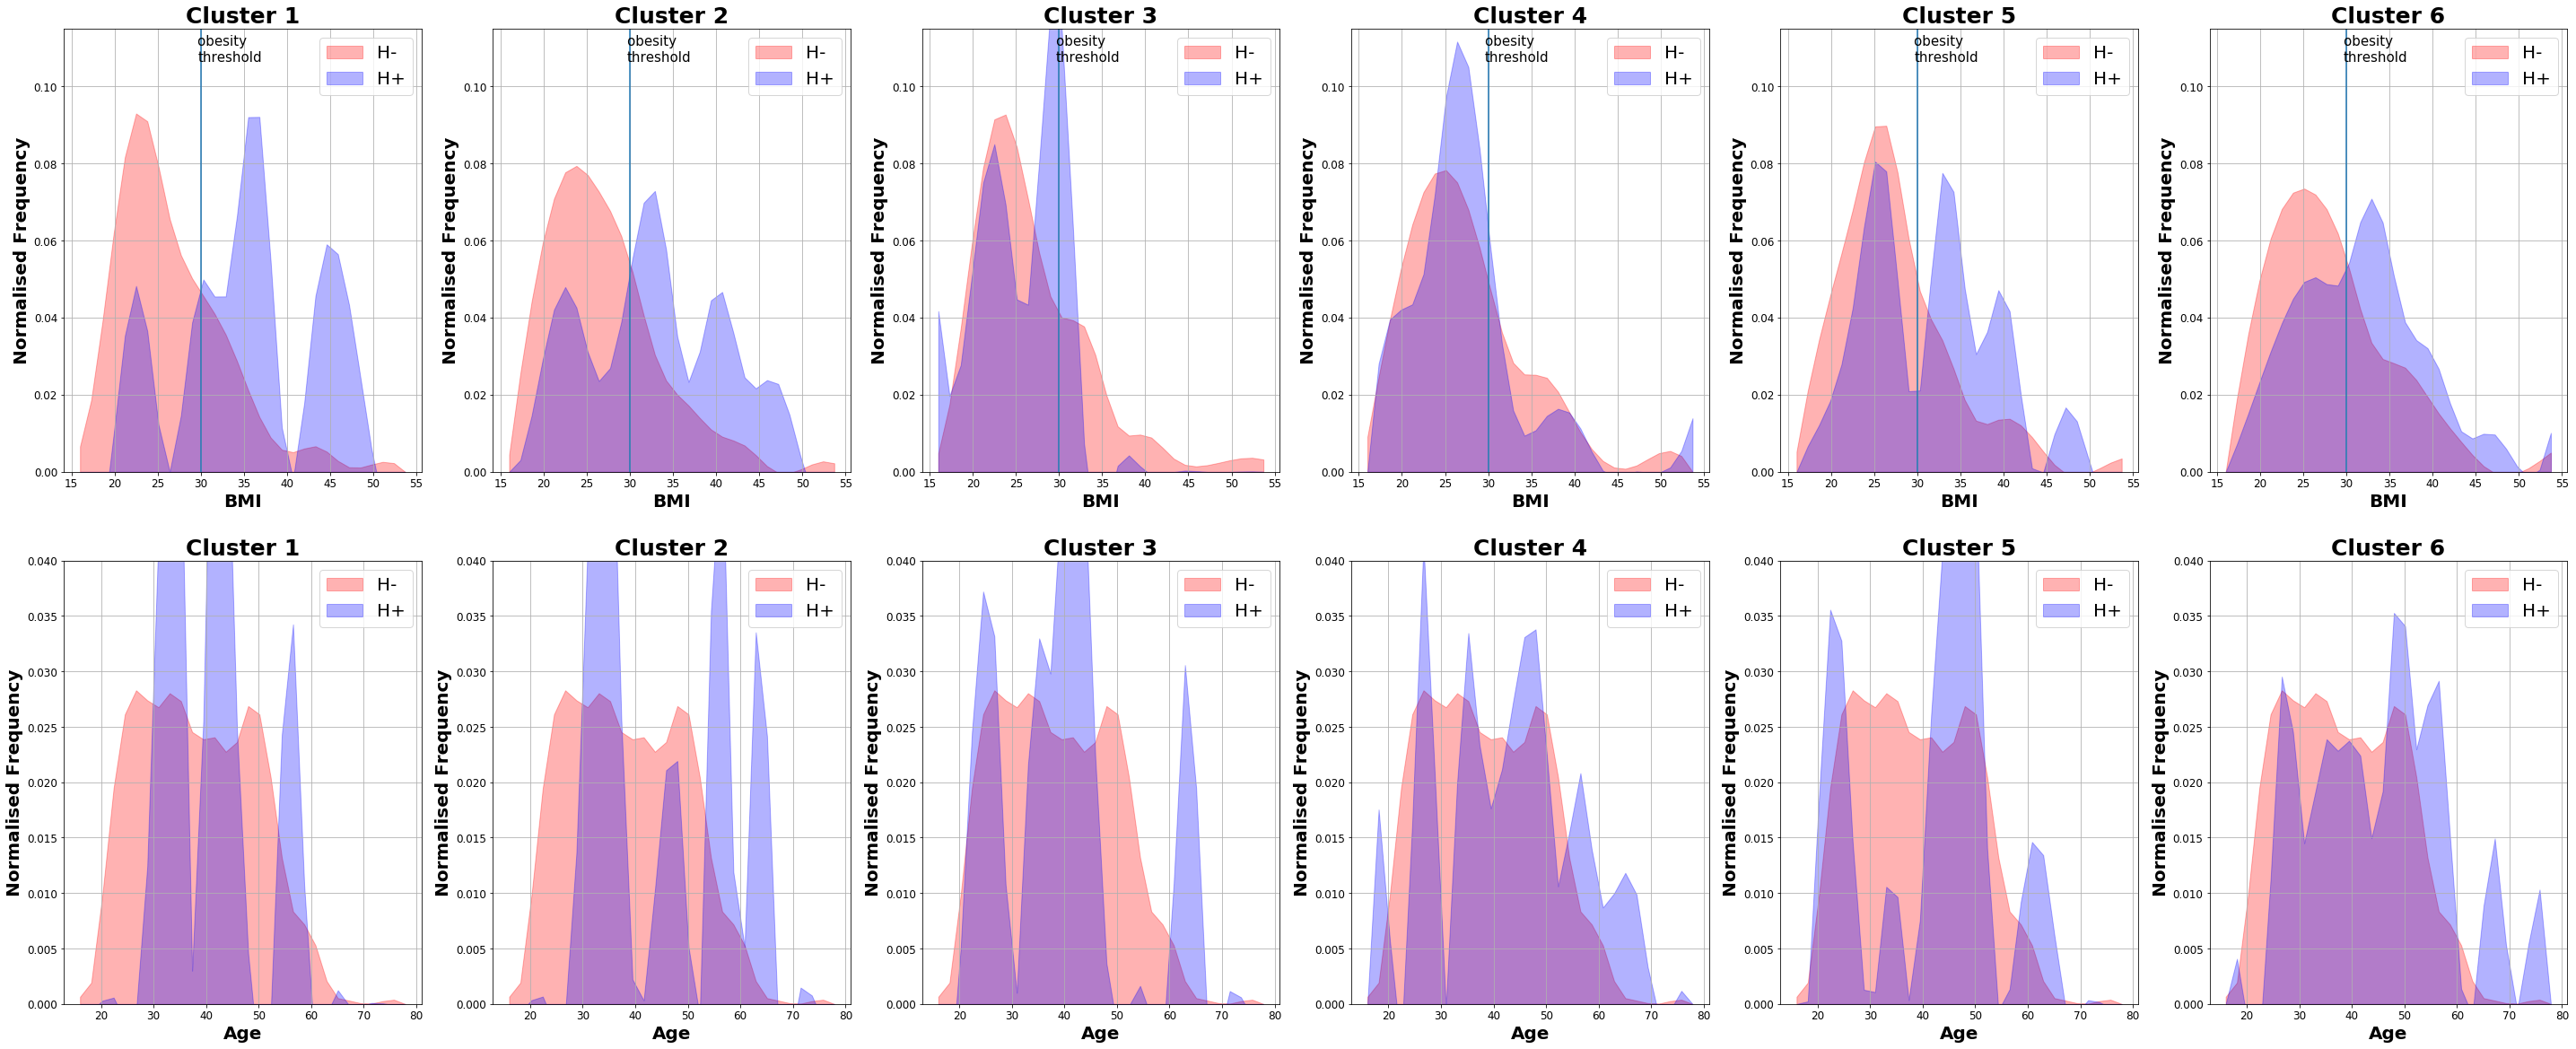

In [174]:
from scipy.interpolate import interp1d, CubicSpline

fig, ax = plt.subplots(2,6,figsize=(50,20))
for f in range(0,6):
    data_th = np.histogram(df_unique[(df_unique['treatment_bin']==1) & (df_unique['clust6']==f)]['bmi_clean'],density=True, bins=np.arange(16,55,3))
    data_tnh = np.histogram(df_unique[(df_unique['treatment_bin']==0) & (df_unique['clust6']==f)]['bmi_clean'],density=True, bins=np.arange(16,55,3))
    print(data_tnh)
    arr2_interp = CubicSpline(np.arange(data_th[0].size),data_th[0])
    to_add_th = arr2_interp(np.linspace(0,data_th[0].size-1,30))
    arr2_interp = CubicSpline(np.arange(data_tnh[0].size),data_tnh[0])
    to_add_tnh = arr2_interp(np.linspace(0,data_tnh[0].size-1,30))
    
    ax[0,f].fill_between(np.arange(16,55,(55-16)/len(to_add_tnh)),to_add_tnh,alpha=0.3, color='red')
    ax[0,f].fill_between(np.arange(16,55,(55-16)/len(to_add_th)),to_add_th,alpha=0.3,color='blue')
    ax[0,f].set_xlabel('BMI',fontsize=20,fontweight='bold')
    ax[0,f].set_ylabel('Normalised Frequency',fontsize=20,fontweight='bold')
    ax[0,f].set_title('Cluster %d' %(f+1),fontsize=25, fontweight='bold')
    ax[0,f].legend(['H-','H+'],fontsize=20)
    ax[0,f].set_ylim([0,0.115])
    ax[0,f].grid()
    ax[0,f].tick_params(labelsize=12)
    ax[0,f].plot(np.ones([9])*30, np.arange(0,0.9,0.1))
    ax[0,f].annotate('obesity \nthreshold',fontsize=15,
            xy=(0.6, 0.9), xycoords='axes fraction',
            xytext=(-90, 10), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')
    
    data_th = np.histogram(df_unique[(df_unique['treatment_bin']==1) & (df_unique['clust6']==f)]['age'],density=True, bins=np.arange(16,90,4))
    data_tnh = np.histogram(df_unique[df_unique['treatment_bin']==0 & (df_unique['clust6']==f)]['age'],density=True, bins=np.arange(16,90,4))
    arr2_interp = CubicSpline(np.arange(data_th[0].size),data_th[0])
    to_add_th = arr2_interp(np.linspace(0,data_th[0].size-1,30))
    arr2_interp = CubicSpline(np.arange(data_tnh[0].size),data_tnh[0])
    to_add_tnh = arr2_interp(np.linspace(0,data_tnh[0].size-1,30))
    
    ax[1,f].fill_between(np.arange(16,80,(80-16)/len(to_add_tnh)),to_add_tnh,alpha=0.3,color='red')
    ax[1,f].fill_between(np.arange(16,80,(80-16)/len(to_add_th)),to_add_th,alpha=0.3, color='blue')
    ax[1,f].set_xlabel('Age',fontsize=20,fontweight='bold')
    ax[1,f].set_ylabel('Normalised Frequency',fontsize=20,fontweight='bold')
    ax[1,f].set_title('Cluster %d' %(f+1),fontsize=25, fontweight='bold')
    ax[1,f].legend(['H-','H+'],fontsize=20)
    ax[1,f].set_ylim([0,0.04])
    ax[1,f].grid()
    ax[1,f].tick_params(labelsize=12)



In [175]:
df_unique.groupby(['country_code_x','treatment_bin']).size().unstack()

treatment_bin,0,1
country_code_x,,
GB,1515,106
US,31,1


In [176]:
df_utest.groupby(['country_code_x','treatment_bin']).size().unstack()

treatment_bin,0,1
country_code_x,,
GB,871,49
SE,73,8
US,47,2


In [ ]:
# User

In [66]:
# Calculating Projection using test set
# df_testpos = pd.read_csv('TestedPosNonHosp_1105.csv')
# df_testhosp = pd.read_csv('HospOfInterest_1105.csv')
# df_test = pd.concat([df_testpos,df_testhosp])
df_test = pd.read_csv('TestTH2805.csv')



/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,21,22,34,35,107,109,110,111,112,113,115,117,119,120,123,129,130,132,133,172,216) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [69]:
df_test_preg = df_test[df_test['is_pregnant']==True]
df_train_preg = df_train[df_train['is_pregnant']==True]

In [70]:
len(list(set(df_train_preg['patient_id'])))

3

In [27]:
df_test = df_test.dropna(subset=list_symptoms, how='all')
df_test_fin = df_test[~df_test['patient_id'].isin(list(set(df_train['patient_id'])))]

In [28]:
len(list(set(df_test_fin['patient_id'])))

1050

In [29]:
df_test_ind=df_test_fin.set_index(['patient_id','interval_days'])
classif_test,mean_test, error_test = attribution(df_test_ind[list_symptoms], proj)

In [30]:
df_test = df_test.reset_index(drop=True)
for f in list_symptoms:
    df_test['mean_'+f] = df_test.groupby('patient_id')[f].transform('mean')
    df_test['std_'+f] = df_test.groupby('patient_id')[f].transform('std')
    df_test['max_'+f] = df_test.groupby('patient_id')[f].transform('max')
df_utest = df_test.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
df_ztest = df_test[list_symptoms+['patient_id','max_duration2','interval_days']]
for f in list_symptoms:
    df_ztest['z_'+f] = (df_test[f] - df_utest['mean_'+f].mean()) / df_utest['mean_'+f].std()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
average_dictz = {}
duration_dictz = {}
list_z = ['z_'+s for s in list_symptoms]
list_average_h=[]
duration_array = []
for p in classif_test.keys():
    test_clust1 = df_ztest[(df_ztest['patient_id'].isin(classif_test[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_z,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictz[6] = list_average_h
duration_dictz[6] = duration_array

average_dictb = {}
duration_dictb = {}
list_z = ['z_'+s for s in list_symptoms]
classif_full = clt_hosp
list_average_h=[]
duration_array = []
for p in classif_test.keys():
    test_clust1 = df_ztest[(df_ztest['patient_id'].isin(classif_test[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictb[6] = list_average_h
duration_dictb[6] = duration_array

10.0 (404, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 404)
8.0 (200, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 200)
10.0 (130, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 130)
9.0 (102, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 102)
10.0 (119, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 119)
9.0 (95, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 95)
10.0 (404, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 404)
8.0 (200, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 200)
10.0 (130, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 130)
9.0 (102, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 102)
10.0 (119, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 119)
9.0 (95, 31)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 95)


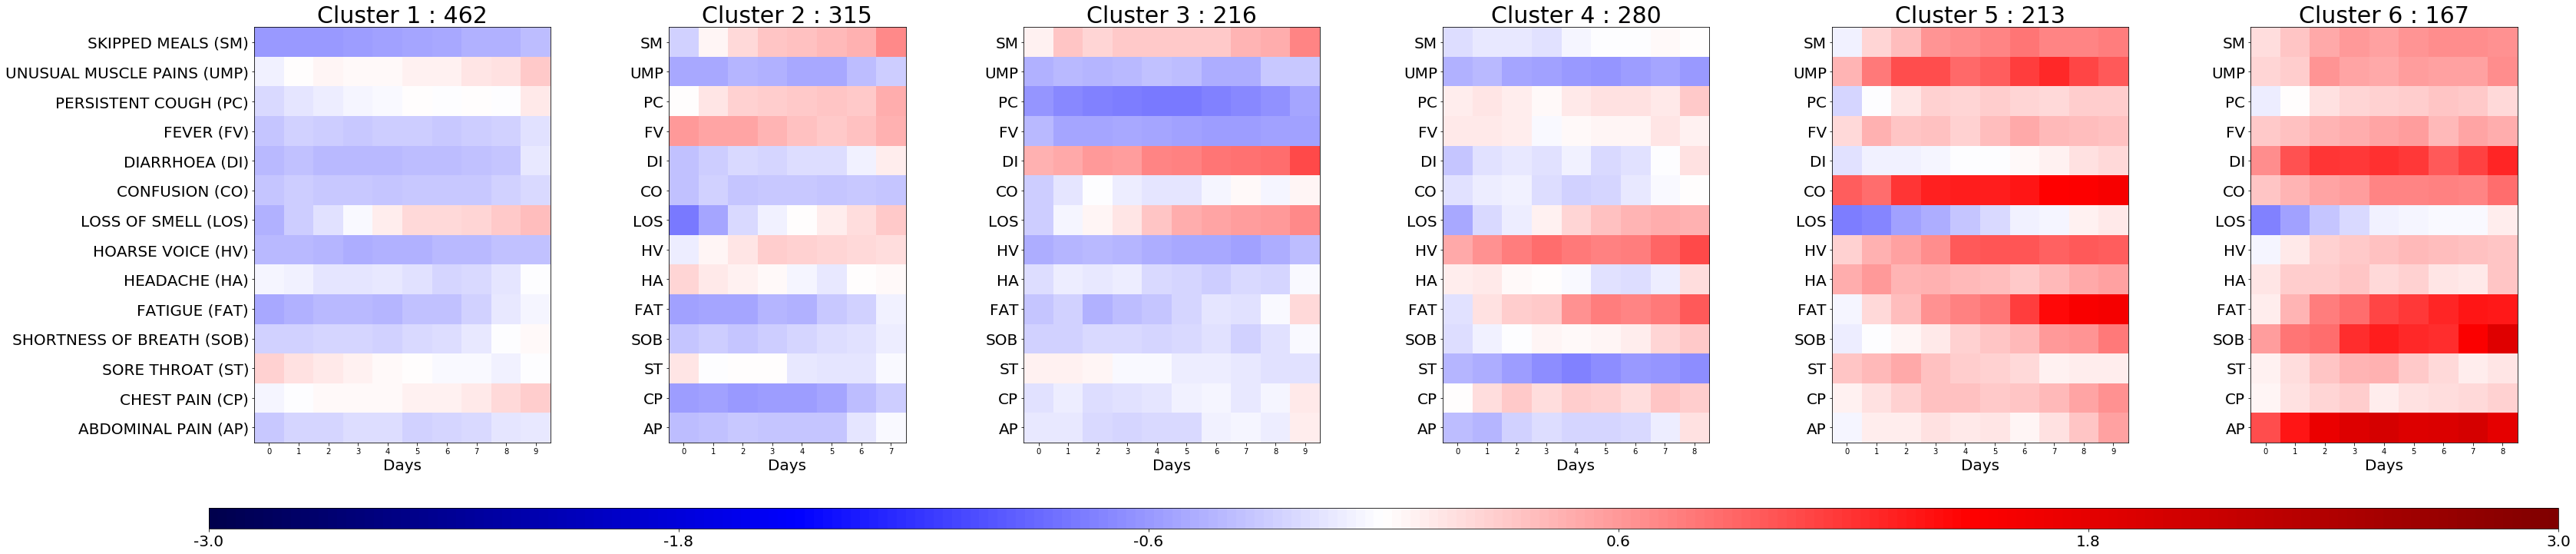

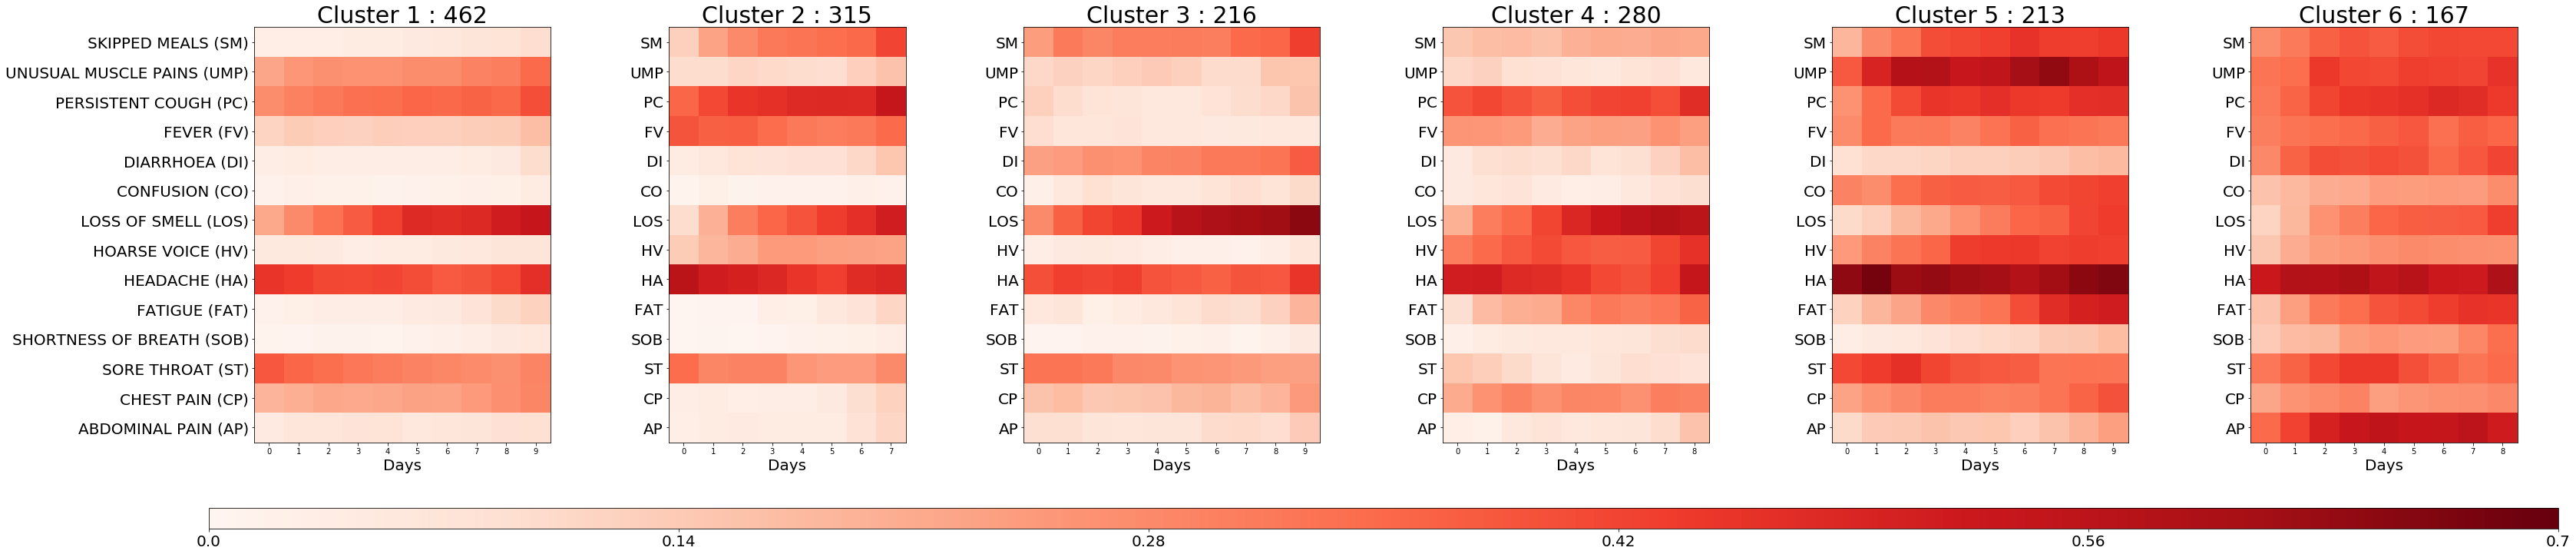

In [45]:
plotting_patterns_fromave(average_dictz[6],duration_dictz[6], clt_hosp,'',cmap='seismic',vmin=-3,vmax=3,save_name='ZScoreTest2805.pdf')

plotting_patterns_fromave(average_dictb[6],duration_dictb[6], clt_hosp,'',cmap='Reds',vmin=0,vmax=0.7,save_name='AverageTest2805.pdf')

In [53]:
df_unique.groupby(['guessed_pos','clust6']).size().unstack()

clust6,0,1,2,3,4,5
guessed_pos,,,,,,
0.0,4.0,3.0,NaN,6.0,13.0,11.0
1.0,59.0,35.0,45.0,52.0,36.0,55.0
2.0,4.0,6.0,2.0,4.0,4.0,4.0
3.0,7.0,11.0,4.0,7.0,5.0,6.0


In [31]:
# Calculate projections using limited number of days:
dict_projt ={}
dict_clustt = {}
dict_patt = {}
for d in range(2,10):
    print('Treating day %d'%d)
    df_test_ind = df_test_fin.set_index(['patient_id','interval_days'])
    projt, clustt, pat_listt = calculation_centroid(df_test_ind[list_symptoms],classif_test, numb_dim=6,drop='all',new_col='new_attribution',numbdays=d)
    dict_projt[d] = projt
    dict_clustt[d] = clustt
    dict_patt[d] = pat_listt

Treating day 2
Treating day 3
Treating day 4
Treating day 5
Treating day 6
Treating day 7
Treating day 8
Treating day 9


In [32]:
df_attributiont = pd.DataFrame([np.arange(0,len(dict_patt[2])).T, dict_patt[2]])
df_attributiont = df_attributiont.transpose()
df_attributiont.columns = ['ind','patient_id']

In [33]:
for d in range(2,10):
    print(np.unique(dict_clustt[d]))
    classif_temp = {}
    clust = dict_clustt[d]
    list_pat = dict_patt[d]
    for f in np.unique(dict_clustt[d]):
        classif_temp[f] = [l for (i,l) in enumerate(list_pat) if clust[i]==f]
    df_attributiont = allocate_cluster(df_attributiont,classif_temp,'clustproj_%ddays'%d)

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [39]:
dict_classif_ft = {}
for d in range(2,10):
    print('Treating day %d' %d)
    classif_temp ,mean_temp, error_temp = attribution(df_test_ind[list_symptoms], dict_proj[d],numbdays=d)
    dict_classif_ft[d] = classif_temp
    df_attributiont = allocate_cluster(df_attributiont,classif_temp,'trainproj_%ddays'%d)

Treating day 2
Treating day 3
Treating day 4
Treating day 5
Treating day 6
Treating day 7
Treating day 8
Treating day 9


In [41]:
df_attributiont = allocate_cluster(df_attributiont,classif_test, 'clustfull')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1


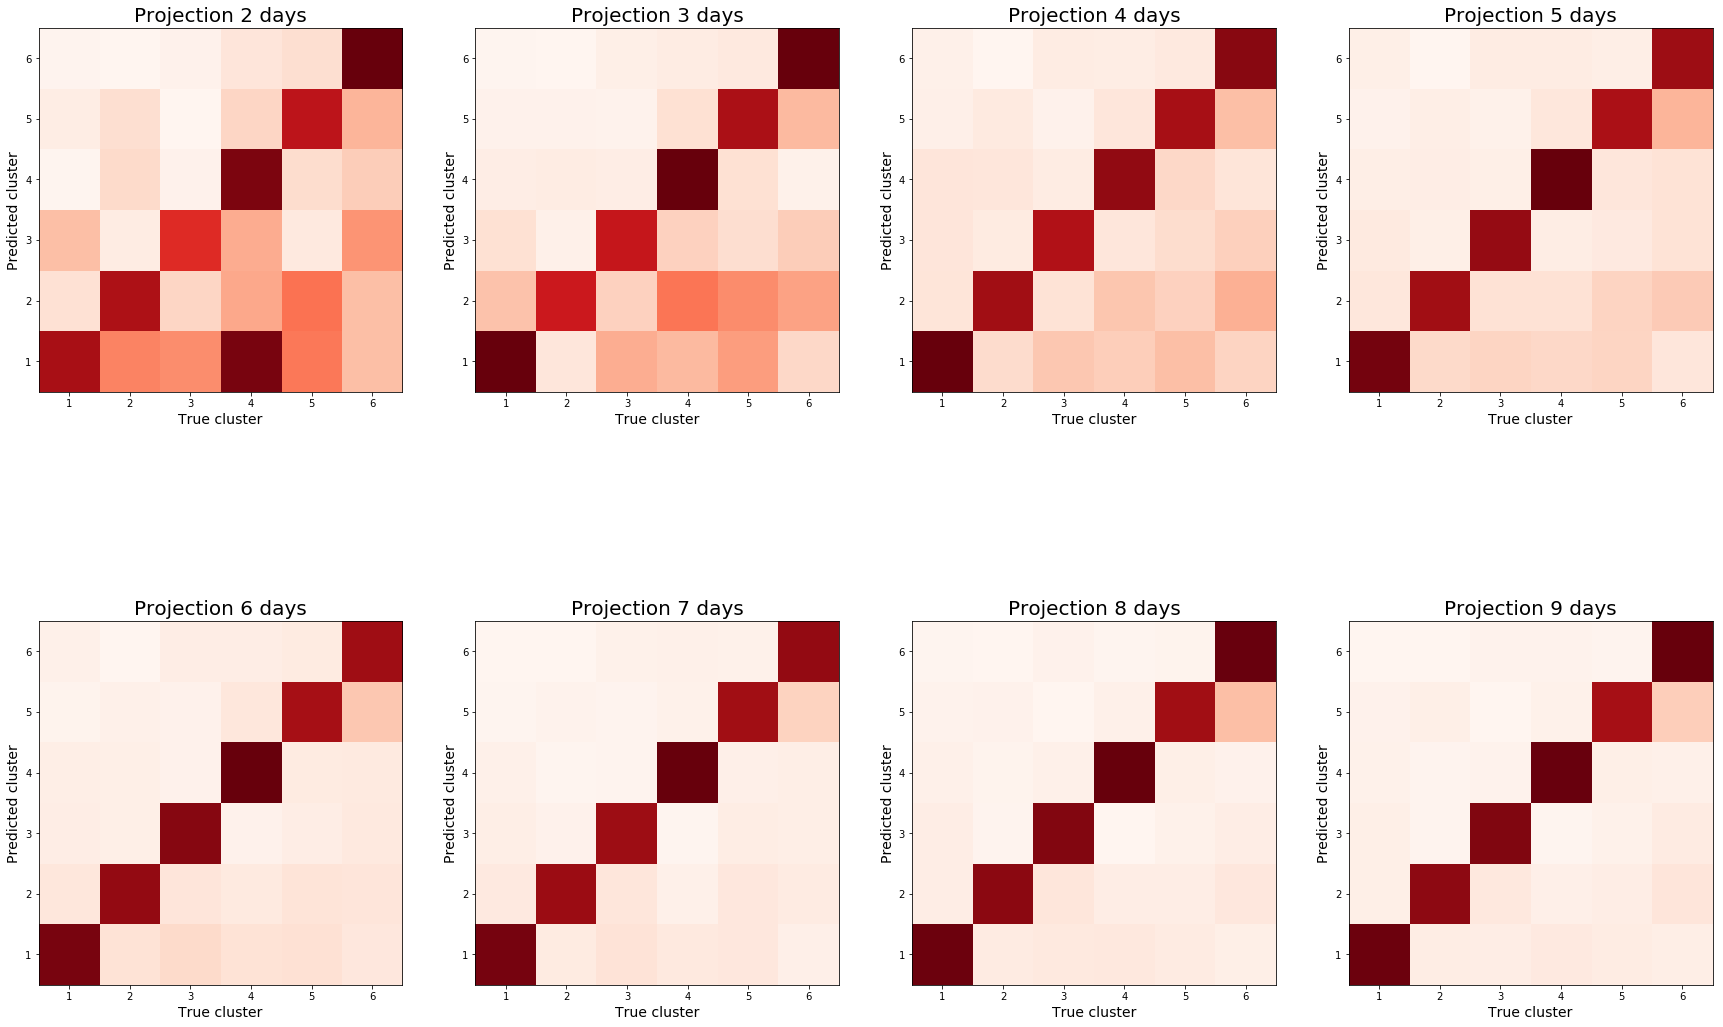

In [97]:
fig, ax = plt.subplots(2,4,figsize=(30,20))
for f in range(2,10):
    array = np.nan_to_num(np.asarray(df_attribution.groupby(['clustproj_%ddays'%f,'clustfull']).size().unstack()))
    array_norm = array / np.sum(array,1)
    print(int((f-2)/3),int((f-2)%3))
    ax[int((f-2)/4),int((f-2)%4)].imshow(array_norm,cmap='Reds')
    ax[int((f-2)/4),int((f-2)%4)].set_title('Projection %d days'%f, fontsize=20)
    ax[int((f-2)/4),int((f-2)%4)].set_xlabel('True cluster',fontsize=14)
    ax[int((f-2)/4),int((f-2)%4)].set_ylabel('Predicted cluster',fontsize=14)
    ax[int((f-2)/4),int((f-2)%4)].set_xticks(np.arange(0,6))
    ax[int((f-2)/4),int((f-2)%4)].set_yticks(np.arange(0,6))
    ax[int((f-2)/4),int((f-2)%4)].set_ylim([-0.5,5.5])
    ax[int((f-2)/4),int((f-2)%4)].set_xticklabels(np.arange(1,7))
    ax[int((f-2)/4),int((f-2)%4)].set_yticklabels(np.arange(1,7))
    
#     ax[int((f-2)/3),int((f-2)%3)].title('Projection at %d days'%f)
plt.savefig('ConfusionMatrix2805B.pdf')

In [80]:
from sklearn.metrics import classification_report as cr
f=5
cr(df_attribution['clustfull'], df_attribution['clustproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.7615062761506276,
  'precision': 0.7368421052631579,
  'recall': 0.7878787878787878,
  'support': 462},
 '1': {'f1-score': 0.7083333333333334,
  'precision': 0.6666666666666666,
  'recall': 0.7555555555555555,
  'support': 315},
 '2': {'f1-score': 0.6882217090069284,
  'precision': 0.6866359447004609,
  'recall': 0.6898148148148148,
  'support': 216},
 '3': {'f1-score': 0.7180451127819548,
  'precision': 0.7579365079365079,
  'recall': 0.6821428571428572,
  'support': 280},
 '4': {'f1-score': 0.6280193236714977,
  'precision': 0.6467661691542289,
  'recall': 0.6103286384976526,
  'support': 213},
 '5': {'f1-score': 0.5953177257525084,
  'precision': 0.6742424242424242,
  'recall': 0.5329341317365269,
  'support': 167},
 'accuracy': 0.7023593466424682,
 'macro avg': {'f1-score': 0.6832405801161417,
  'precision': 0.6948483029939077,
  'recall': 0.6764424642710325,
  'support': 1653},
 'weighted avg': {'f1-score': 0.7004450069260324,
  'precision': 0.7025507064654787

In [81]:
from sklearn.metrics import classification_report as cr
f=2
cr(df_attribution['clustfull'], df_attribution['clustproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.5374280230326296,
  'precision': 0.4827586206896552,
  'recall': 0.6060606060606061,
  'support': 462},
 '1': {'f1-score': 0.48286604361370716,
  'precision': 0.4740061162079511,
  'recall': 0.49206349206349204,
  'support': 315},
 '2': {'f1-score': 0.430327868852459,
  'precision': 0.3860294117647059,
  'recall': 0.4861111111111111,
  'support': 216},
 '3': {'f1-score': 0.4087912087912087,
  'precision': 0.5314285714285715,
  'recall': 0.33214285714285713,
  'support': 280},
 '4': {'f1-score': 0.40206185567010316,
  'precision': 0.44571428571428573,
  'recall': 0.36619718309859156,
  'support': 213},
 '5': {'f1-score': 0.47422680412371127,
  'precision': 0.5564516129032258,
  'recall': 0.41317365269461076,
  'support': 167},
 'accuracy': 0.47186932849364793,
 'macro avg': {'f1-score': 0.45595030068063647,
  'precision': 0.47939810311806585,
  'recall': 0.4492914836952115,
  'support': 1653},
 'weighted avg': {'f1-score': 0.4674180036657314,
  'precision': 0.479366

In [82]:
from sklearn.metrics import classification_report as cr
f=9
cr(df_attribution['clustfull'], df_attribution['clustproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.8756756756756756,
  'precision': 0.8747300215982722,
  'recall': 0.8766233766233766,
  'support': 462},
 '1': {'f1-score': 0.848854961832061,
  'precision': 0.8176470588235294,
  'recall': 0.8825396825396825,
  'support': 315},
 '2': {'f1-score': 0.8433179723502303,
  'precision': 0.8394495412844036,
  'recall': 0.8472222222222222,
  'support': 216},
 '3': {'f1-score': 0.8695652173913043,
  'precision': 0.8823529411764706,
  'recall': 0.8571428571428571,
  'support': 280},
 '4': {'f1-score': 0.7954545454545453,
  'precision': 0.7709251101321586,
  'recall': 0.8215962441314554,
  'support': 213},
 '5': {'f1-score': 0.7866666666666667,
  'precision': 0.8872180451127819,
  'recall': 0.7065868263473054,
  'support': 167},
 'accuracy': 0.8463399879007865,
 'macro avg': {'f1-score': 0.8365891732284139,
  'precision': 0.845387119687936,
  'recall': 0.8319518681678165,
  'support': 1653},
 'weighted avg': {'f1-score': 0.8459719114044937,
  'precision': 0.8484189231377137,


In [83]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix
n_bootstraps = 1000
rng_seed = 42  # control reproducibility



def bootstrap_results_mc(df, column_true, column_pred,type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5):
    rng = np.random.RandomState(rng_seed)
    y_true = np.asarray(df[column_true])
    y_pred = np.asarray(df[column_pred])
    bootstrapped_scores_prec = []
    bootstrapped_scores_rec = []
    bootstrapped_scores_f1 = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        cr_temp = cr(y_true[indices], y_pred[indices],output_dict=True)
        bootstrapped_scores_f1.append(cr_temp[type_out]['f1-score'])
        bootstrapped_scores_prec.append(cr_temp[type_out]['precision'])
        bootstrapped_scores_rec.append(cr_temp[type_out]['recall'])
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

    
    sorted_scores_prec = np.array(bootstrapped_scores_prec)
    sorted_scores_rec = np.array(bootstrapped_scores_rec)
    sorted_scores_f1 = np.array(bootstrapped_scores_f1)

    sorted_scores_prec.sort()
    sorted_scores_rec.sort()
    sorted_scores_f1.sort()
    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    
    confidence_lower_rec = sorted_scores_rec[int(0.05 * len(sorted_scores_rec))]
    confidence_upper_rec = sorted_scores_rec[int(0.95 * len(sorted_scores_rec))]
    confidence_mean_rec = np.mean(sorted_scores_rec)
    
    confidence_lower_prec = sorted_scores_prec[int(0.05 * len(sorted_scores_prec))]
    confidence_upper_prec = sorted_scores_prec[int(0.95 * len(sorted_scores_prec))]
    confidence_mean_prec = np.mean(sorted_scores_prec)
    
    confidence_lower_f1 = sorted_scores_f1[int(0.05 * len(sorted_scores_f1))]
    confidence_upper_f1 = sorted_scores_f1[int(0.95 * len(sorted_scores_f1))]
    confidence_mean_f1 = np.mean(sorted_scores_f1)
    print("Confidence interval for the precision:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_prec,
        confidence_lower_prec, confidence_upper_prec))
    print("Confidence interval for the F1:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_f1,
        confidence_lower_f1, confidence_upper_f1))
    print("Confidence interval for the recall:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_rec,
        confidence_lower_rec, confidence_upper_rec))

In [84]:
bootstrap_results_mc(df_attribution, 'clustfull', 'clustproj_5days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.704 [0.684 - 0.722]
Confidence interval for the F1:0.701 [0.682 - 0.719]
Confidence interval for the recall:0.703 [0.684 - 0.721]


In [85]:
bootstrap_results_mc(df_attribution, 'clustfull', 'clustproj_2days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.480 [0.459 - 0.503]
Confidence interval for the F1:0.468 [0.446 - 0.49]
Confidence interval for the recall:0.472 [0.451 - 0.495]


In [86]:
bootstrap_results_mc(df_attribution, 'clustfull', 'clustproj_9days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.849 [0.835 - 0.863]
Confidence interval for the F1:0.846 [0.832 - 0.861]
Confidence interval for the recall:0.846 [0.832 - 0.861]


In [87]:
df_attributiont.groupby(['trainproj_%ddays'%f,'clustfull'])

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1


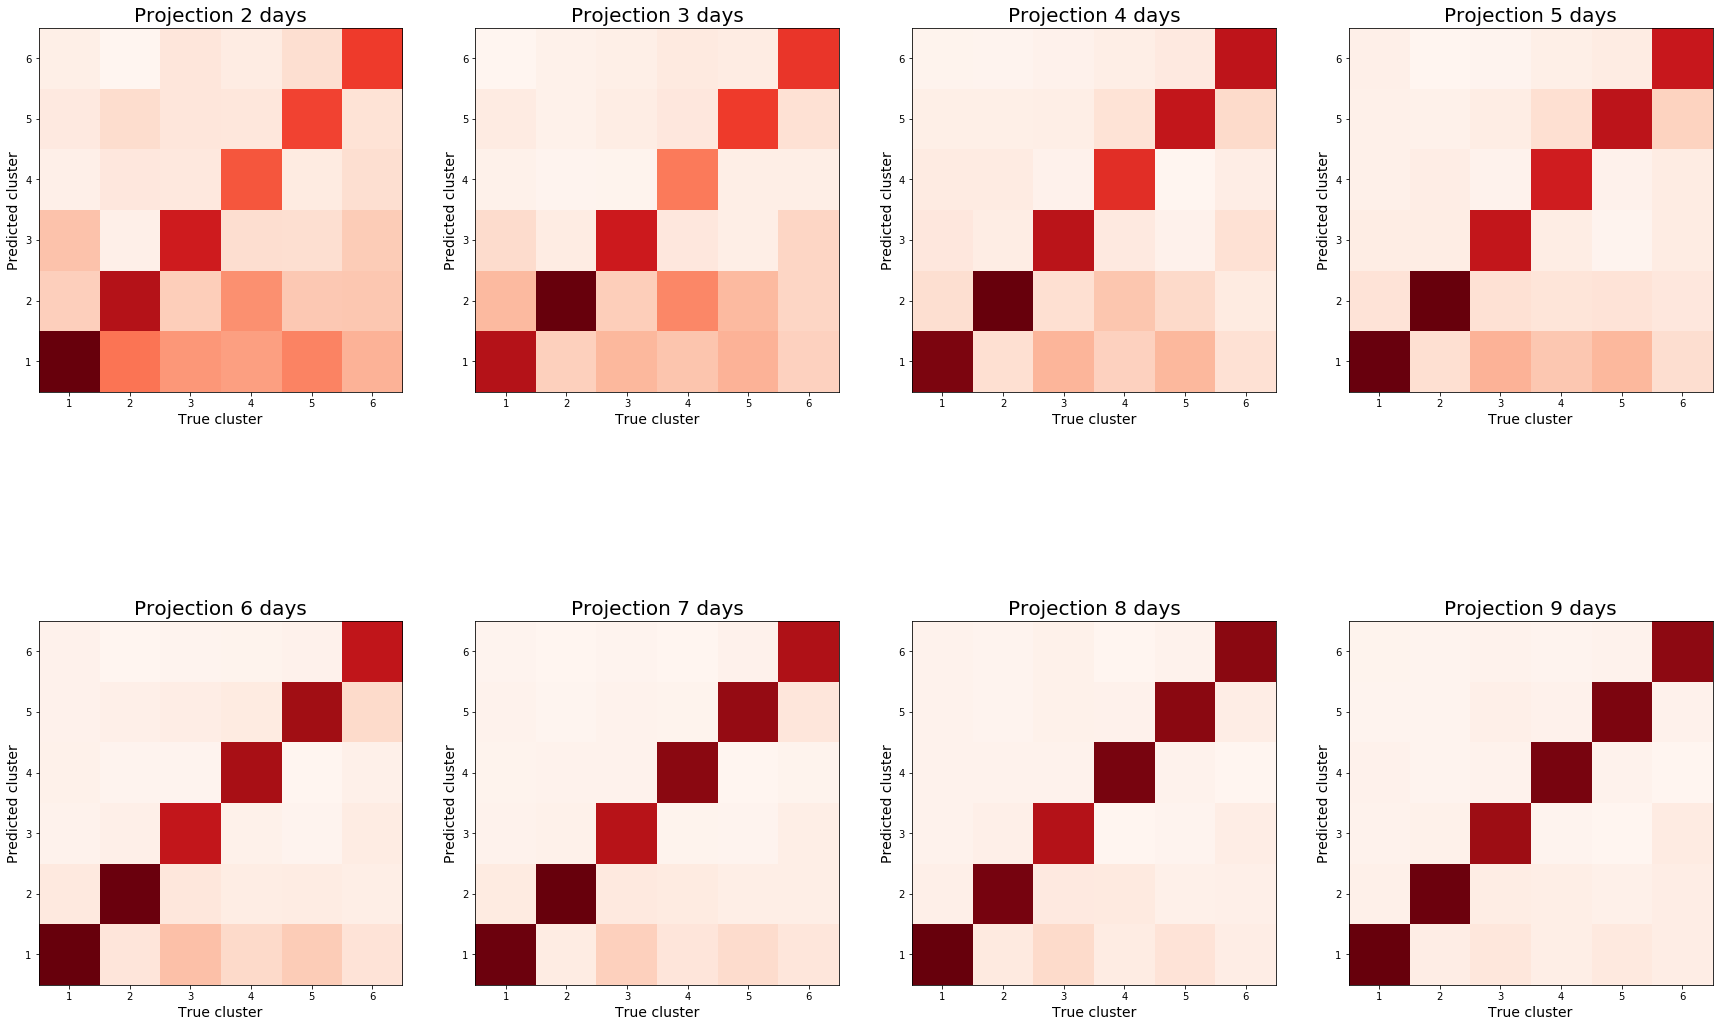

In [42]:
fig, ax = plt.subplots(2,4,figsize=(30,20))
for f in range(2,10):
    array = np.nan_to_num(np.asarray(df_attributiont.groupby(['trainproj_%ddays'%f,'clustfull']).size().unstack()))
    array_norm = array / np.sum(array,0)
    print(int((f-2)/3),int((f-2)%3))
    ax[int((f-2)/4),int((f-2)%4)].imshow(array_norm,cmap='Reds')
    ax[int((f-2)/4),int((f-2)%4)].set_title('Projection %d days'%f, fontsize=20)
    ax[int((f-2)/4),int((f-2)%4)].set_xlabel('True cluster',fontsize=14)
    ax[int((f-2)/4),int((f-2)%4)].set_ylabel('Predicted cluster',fontsize=14)
    ax[int((f-2)/4),int((f-2)%4)].set_xticks(np.arange(0,6))
    ax[int((f-2)/4),int((f-2)%4)].set_yticks(np.arange(0,6))
    ax[int((f-2)/4),int((f-2)%4)].set_ylim([-0.5,5.5])
    ax[int((f-2)/4),int((f-2)%4)].set_xticklabels(np.arange(1,7))
    ax[int((f-2)/4),int((f-2)%4)].set_yticklabels(np.arange(1,7))
#     ax[int((f-2)/3),int((f-2)%3)].title('Projection at %d days'%f)

In [89]:
from sklearn.metrics import classification_report as cr
f=5
cr(df_attributiont['clustfull'], df_attributiont['trainproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.7801932367149759,
  'precision': 0.7617924528301887,
  'recall': 0.7995049504950495,
  'support': 404},
 '1': {'f1-score': 0.7470997679814386,
  'precision': 0.696969696969697,
  'recall': 0.805,
  'support': 200},
 '2': {'f1-score': 0.6639344262295082,
  'precision': 0.7105263157894737,
  'recall': 0.6230769230769231,
  'support': 130},
 '3': {'f1-score': 0.6417112299465241,
  'precision': 0.7058823529411765,
  'recall': 0.5882352941176471,
  'support': 102},
 '4': {'f1-score': 0.6413502109704641,
  'precision': 0.6440677966101694,
  'recall': 0.6386554621848739,
  'support': 119},
 '5': {'f1-score': 0.6705202312138728,
  'precision': 0.7435897435897436,
  'recall': 0.6105263157894737,
  'support': 95},
 'accuracy': 0.7228571428571429,
 'macro avg': {'f1-score': 0.6908015171761307,
  'precision': 0.7104713931217415,
  'recall': 0.6774998242773279,
  'support': 1050},
 'weighted avg': {'f1-score': 0.720384894442212,
  'precision': 0.7226777188834316,
  'recall': 0.

In [90]:
from sklearn.metrics import classification_report as cr
f=9
cr(df_attributiont['clustfull'], df_attributiont['trainproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.9158415841584159,
  'precision': 0.9158415841584159,
  'recall': 0.9158415841584159,
  'support': 404},
 '1': {'f1-score': 0.8850855745721271,
  'precision': 0.8660287081339713,
  'recall': 0.905,
  'support': 200},
 '2': {'f1-score': 0.8346456692913387,
  'precision': 0.8548387096774194,
  'recall': 0.8153846153846154,
  'support': 130},
 '3': {'f1-score': 0.8737864077669903,
  'precision': 0.8653846153846154,
  'recall': 0.8823529411764706,
  'support': 102},
 '4': {'f1-score': 0.8813559322033899,
  'precision': 0.8888888888888888,
  'recall': 0.8739495798319328,
  'support': 119},
 '5': {'f1-score': 0.8556149732620322,
  'precision': 0.8695652173913043,
  'recall': 0.8421052631578947,
  'support': 95},
 'accuracy': 0.8866666666666667,
 'macro avg': {'f1-score': 0.8743883568757157,
  'precision': 0.8767579539391027,
  'recall': 0.8724389972848883,
  'support': 1050},
 'weighted avg': {'f1-score': 0.8864876608634561,
  'precision': 0.8866575981752773,
  'recall': 

In [91]:
from sklearn.metrics import classification_report as cr
f=2
cr(df_attributiont['clustfull'], df_attributiont['trainproj_%ddays'%f],output_dict=True)

{'0': {'f1-score': 0.6253041362530414,
  'precision': 0.6148325358851675,
  'recall': 0.6361386138613861,
  'support': 404},
 '1': {'f1-score': 0.49645390070921985,
  'precision': 0.47085201793721976,
  'recall': 0.525,
  'support': 200},
 '2': {'f1-score': 0.42657342657342656,
  'precision': 0.391025641025641,
  'recall': 0.46923076923076923,
  'support': 130},
 '3': {'f1-score': 0.4022346368715084,
  'precision': 0.4675324675324675,
  'recall': 0.35294117647058826,
  'support': 102},
 '4': {'f1-score': 0.4125560538116592,
  'precision': 0.4423076923076923,
  'recall': 0.3865546218487395,
  'support': 119},
 '5': {'f1-score': 0.45508982035928147,
  'precision': 0.5277777777777778,
  'recall': 0.4,
  'support': 95},
 'accuracy': 0.5171428571428571,
 'macro avg': {'f1-score': 0.4697019957630228,
  'precision': 0.48572135541099426,
  'recall': 0.46164419690191383,
  'support': 1050},
 'weighted avg': {'f1-score': 0.5149750789916486,
  'precision': 0.517959902266858,
  'recall': 0.5171428

In [92]:
bootstrap_results_mc(df_attributiont, 'clustfull', 'trainproj_5days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.724 [0.701 - 0.746]
Confidence interval for the F1:0.720 [0.698 - 0.742]
Confidence interval for the recall:0.723 [0.701 - 0.745]


In [93]:
bootstrap_results_mc(df_attributiont, 'clustfull', 'trainproj_2days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.520 [0.494 - 0.546]
Confidence interval for the F1:0.515 [0.489 - 0.542]
Confidence interval for the recall:0.518 [0.491 - 0.543]


In [94]:
bootstrap_results_mc(df_attributiont, 'clustfull', 'trainproj_9days',type_out='weighted avg', n_bootstrap=1000, rng_seed=42,opt_thresh=0.5)


Confidence interval for the precision:0.887 [0.871 - 0.904]
Confidence interval for the F1:0.886 [0.870 - 0.903]
Confidence interval for the recall:0.887 [0.870 - 0.903]


In [95]:
df_attributiont.to_csv('TestedAttribution_FullSet2805.csv')

In [96]:

df_test3 = df_test_fin.groupby('patient_id').apply(lambda group: start_sum_freq(group, list_symptoms))

In [98]:
df_test3 = df_test3.reset_index(drop=True)
df_test3 = df_test3.groupby('patient_id').apply(lambda group: max_duration(group, 'max_duration2'))

In [99]:

df_utest = df_test3.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
df_utest = allocate_cluster(df_utest, classif_test,'learnt_clust')
for f in ['has_diabetes', 'has_lung_disease','has_heart_disease','has_kidney_disease']:
    df_utest[f] = df_utest[f].replace('False',0)
    df_utest[f] = df_utest[f].replace('True',1)
    df_utest[f] = df_utest[f].astype(float)


In [100]:
df_utest['treatment_bin'] = np.where(df_utest['max_treat']>2,1,0)

In [101]:
df_utest.groupby(['learnt_clust'])['hosp_bin'].mean()

learnt_clust
0    0.116337
1    0.135000
2    0.138462
3    0.245098
4    0.378151
5    0.505263
Name: hosp_bin, dtype: float64

In [102]:
df_utest.groupby(['learnt_clust'])['treatment_bin'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,404.0,0.002475,0.049752,0.0,0.0,0.0,0.0,1.0
1,200.0,0.025000,0.156517,0.0,0.0,0.0,0.0,1.0
2,130.0,0.023077,0.150729,0.0,0.0,0.0,0.0,1.0
3,102.0,0.078431,0.270177,0.0,0.0,0.0,0.0,1.0
4,119.0,0.168067,0.375507,0.0,0.0,0.0,0.0,1.0
5,95.0,0.231579,0.424079,0.0,0.0,0.0,0.0,1.0


In [103]:
df_unique['treatment_bin'] = np.where(df_unique['max_treat']>2,1,0)
df_unique.groupby(['clust6'])['treatment_bin'].describe()

,count,mean,std,min,25%,50%,75%,max
clust6,,,,,,,,
0,462.0,0.015152,0.122288,0.0,0.0,0.0,0.0,1.0
1,315.0,0.044444,0.206408,0.0,0.0,0.0,0.0,1.0
2,216.0,0.037037,0.189291,0.0,0.0,0.0,0.0,1.0
3,280.0,0.085714,0.280443,0.0,0.0,0.0,0.0,1.0
4,213.0,0.098592,0.298815,0.0,0.0,0.0,0.0,1.0
5,167.0,0.197605,0.399390,0.0,0.0,0.0,0.0,1.0


In [115]:
df_utest = prisma_score_encoding(df_utest)

In [116]:
df_utest = encode_hcw(df_utest)

In [105]:
df_utest.groupby('learnt_clust')['gender'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,404.0,0.212871,0.409845,0.0,0.0,0.0,0.00,1.0
1,200.0,0.245000,0.431166,0.0,0.0,0.0,0.00,1.0
2,130.0,0.215385,0.412679,0.0,0.0,0.0,0.00,1.0
3,102.0,0.254902,0.437958,0.0,0.0,0.0,0.75,1.0
4,119.0,0.285714,0.471975,0.0,0.0,0.0,1.00,2.0
5,95.0,0.336842,0.475138,0.0,0.0,0.0,1.00,1.0


In [136]:
df_utest['hosp_fin'] = np.where(df_utest['patient_id'].isin(list(set(df_testhosp['patient_id']))),1,0)

In [137]:
df_utest['hosp_fin'].sum()

194

In [106]:
df_utest.groupby('country_code_x').size()

country_code_x
GB    920
SE     81
US     49
dtype: int64

In [107]:
df_utest['age'] = 2020 - df_utest['year_of_birth']
#df_utest = salvaging_bmi(df_utest)
df_utest.groupby('learnt_clust')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,404.0,44.225248,12.343361,20.0,34.00,45.0,54.00,76.0
1,200.0,46.515000,14.081949,18.0,35.75,47.0,55.25,93.0
2,130.0,45.900000,13.515337,19.0,35.25,48.0,55.00,86.0
3,102.0,48.901961,14.512207,21.0,39.00,49.0,58.00,95.0
4,119.0,48.478992,16.076011,19.0,36.00,47.0,57.00,96.0
5,95.0,46.431579,15.905073,20.0,33.50,45.0,57.00,93.0


In [108]:

df_utest.groupby('learnt_clust')['bmi_clean'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,357.0,27.128418,5.647948,18.077073,22.819405,25.696690,30.497746,48.269993
1,173.0,27.987110,5.822500,17.361111,23.806302,26.169791,31.634877,45.546464
2,112.0,28.717007,6.411790,17.029353,24.275873,27.189516,31.790690,53.627181
3,77.0,27.465283,5.632018,18.920936,23.847668,26.040958,29.838769,46.344881
4,74.0,28.175643,6.514528,16.134884,24.475102,26.832426,30.297212,48.748950
5,47.0,29.249146,6.054665,18.365884,24.931837,28.974775,34.082293,43.853714


In [109]:
df_utest['treatment_bin'].sum()

59

In [110]:
df_utest['hosp_bin'].sum()

210.0

In [120]:
df_unique.groupby('clust6')[['max_duration2','has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin','hosp_bin','treatment_bin']].mean()

,max_duration2,has_diabetes,has_lung_disease,has_heart_disease,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin
clust6,,,,,,,,
0,9.038961,0.021645,0.136364,0.015152,0.004329,0.000000,0.160173,0.015152
1,8.520635,0.031746,0.104762,0.009524,0.006349,0.012698,0.174603,0.044444
2,8.777778,0.041667,0.101852,0.018519,0.004630,0.000000,0.236111,0.037037
3,9.114286,0.032143,0.196429,0.021429,0.010714,0.000000,0.246429,0.085714
4,8.882629,0.042254,0.197183,0.037559,0.009390,0.032864,0.272300,0.098592
5,9.011976,0.047904,0.281437,0.041916,0.017964,0.053892,0.455090,0.197605


In [ ]:
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])

In [117]:
df_utest.groupby('learnt_clust')[['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin','hosp_bin','treatment_bin']].mean()

,has_diabetes,has_lung_disease,has_heart_disease,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin
learnt_clust,,,,,,,
0,0.017327,0.121287,0.007426,0.004950,0.009901,0.116337,0.002475
1,0.040000,0.150000,0.020000,0.005000,0.020000,0.135000,0.025000
2,0.069231,0.115385,0.015385,0.000000,0.015385,0.138462,0.023077
3,0.019608,0.186275,0.039216,0.000000,0.019608,0.245098,0.078431
4,0.050420,0.168067,0.067227,0.016807,0.067227,0.378151,0.168067
5,0.073684,0.315789,0.010526,0.021053,0.084211,0.505263,0.231579


In [60]:
df_unique['hosp_bin'].describe()

count    1303.000000
mean        0.255564
std         0.436345
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: hosp_bin, dtype: float64

In [61]:
df_utest['hosp_bin'].describe()

count    606.000000
mean       0.433993
std        0.496033
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: hosp_bin, dtype: float64

In [55]:
df_utest.groupby('learnt_clust')['hcw'].mean()

learnt_clust
0    0.522727
1    0.343891
2    0.356322
3    0.390244
4    0.416667
Name: hcw, dtype: float64

In [70]:
df_unique['treatment_bin'] = np.where(df_unique['treatment_coded']>2,1,0)
df_unique['treatment_bin'].mean()

0.07981580966999233

In [76]:
for f in ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin']:
    print(f, df_unique[f].mean())

has_diabetes 0.030721966205837174
has_lung_disease 0.15745007680491552
has_heart_disease 0.020737327188940093
has_kidney_disease 0.008448540706605223
prisma_bin 0.010744435917114352


In [77]:
for f in ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin']:
    print(f, df_utest[f].mean())

has_diabetes 0.033003300330033
has_lung_disease 0.15016501650165018
has_heart_disease 0.026402640264026403
has_kidney_disease 0.0049504950495049506
prisma_bin 0.0165016501650165


In [71]:
df_utest['treatment_bin'] = np.where(df_utest['treatment_max']>2,1,0)
df_utest['treatment_bin'].mean()

0.09075907590759076

In [341]:

df_utest.groupby(['learnt_clust','hosp_bin'])['treatment_bin'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.0,0.117647
1,0.0,0.074074
2,0.0,0.400000
3,0.0,0.289474
4,0.0,0.301887


In [310]:
df_utest.groupby(['learnt_clust','hosp_bin'])['prisma_bin'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.012048,0.000000
1,0.007143,0.000000
2,0.000000,0.075000
3,0.000000,0.026316
4,0.000000,0.075472


In [311]:
df_utest.groupby(['learnt_clust','hosp_bin'])['age'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,43.530120,49.416667
1,39.892857,45.138889
2,39.909091,46.882353
3,39.950000,52.083333
4,41.694444,50.562500


In [312]:
df_utest.groupby(['learnt_clust','hosp_bin'])['bmi_clean'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,27.338799,29.232275
1,26.232300,27.662010
2,28.329077,28.332927
3,27.946701,29.199738
4,26.525143,28.429833


In [313]:
df_utest.groupby(['learnt_clust','hosp_bin'])['has_diabetes'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.036145,0.039216
1,0.014286,0.012346
2,0.045455,0.150000
3,0.000000,0.000000
4,0.027778,0.056604


In [314]:
df_utest.groupby(['learnt_clust','hosp_bin'])['has_heart_disease'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.024096,0.019608
1,0.021429,0.024691
2,0.022727,0.050000
3,0.025000,0.052632
4,0.000000,0.037736


In [315]:
df_utest.groupby(['learnt_clust','hosp_bin'])['has_lung_disease'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.156627,0.235294
1,0.114286,0.135802
2,0.227273,0.175000
3,0.075000,0.078947
4,0.166667,0.188679


In [315]:
df_utest.groupby(['learnt_clust','hosp_bin'])['has_lung_disease'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,0.156627,0.235294
1,0.114286,0.135802
2,0.227273,0.175000
3,0.075000,0.078947
4,0.166667,0.188679


In [78]:
df_utest.groupby(['learnt_clust','hosp_bin'])['max_duration2'].mean().unstack()

hosp_bin,0.0,1.0
learnt_clust,,
0,7.112500,7.442308
1,6.275362,9.204819
2,6.510204,8.052632
3,5.979592,8.575758
4,4.629630,7.105263


In [319]:
df_test3 = df_test.dropna(subset=list_symptoms, how='all')

In [302]:
df_test2.shape

(4923, 246)

In [121]:
average_dictt = {}
duration_dictt = {}
list_average_h=[]
duration_array = []
df_test2 = df_test3.groupby('patient_id').apply(max_duration,'max_duration2')
for p in classif_test.keys():
    test_clust1 = df_test2[(df_test2['patient_id'].isin(classif_test[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictt[6] = list_average_h
duration_dictt[6] = duration_array

10.0 (404, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 404)
8.0 (200, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 8, 200)
10.0 (130, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 130)
9.0 (102, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 102)
10.0 (119, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 10, 119)
9.0 (95, 2153)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(14, 9, 95)


In [24]:
for f in df_train.columns:
    if 'clust' in f:
        print(f)

clust3
clust4
clust5
clust6
clust7
clust8


In [21]:
average_dictt = {}
duration_dictt = {}
list_average_h=[]
duration_array = []
classif_test = create_classif_fromdf(df_test,'learnt_clust')
for p in classif_test.keys():
    test_clust1 = df_test[(df_test['patient_id'].isin(classif_test[p]))]
    df_temp = test_clust1.sort_values('interval_days').drop_duplicates('patient_id')
    duration = np.round(df_temp['max_duration2'].quantile(0.5)+1,0)
    print(duration, df_temp.shape)
    if np.isnan(duration):
        duration=8
    test_clust1 = test_clust1.set_index(['patient_id','interval_days'])
    test_average_hosp = create_average_evolution_withscaling(test_clust1,'patient_id',list_symptoms,duration)
    print(test_average_hosp.shape)
    list_average_h.append(test_average_hosp)
    duration_array.append(duration)
average_dictt[6] = list_average_h
duration_dictt[6] = duration_array

KeyError: 'learnt_clust'

In [328]:
df_utest.reported_by_another.sum()

33

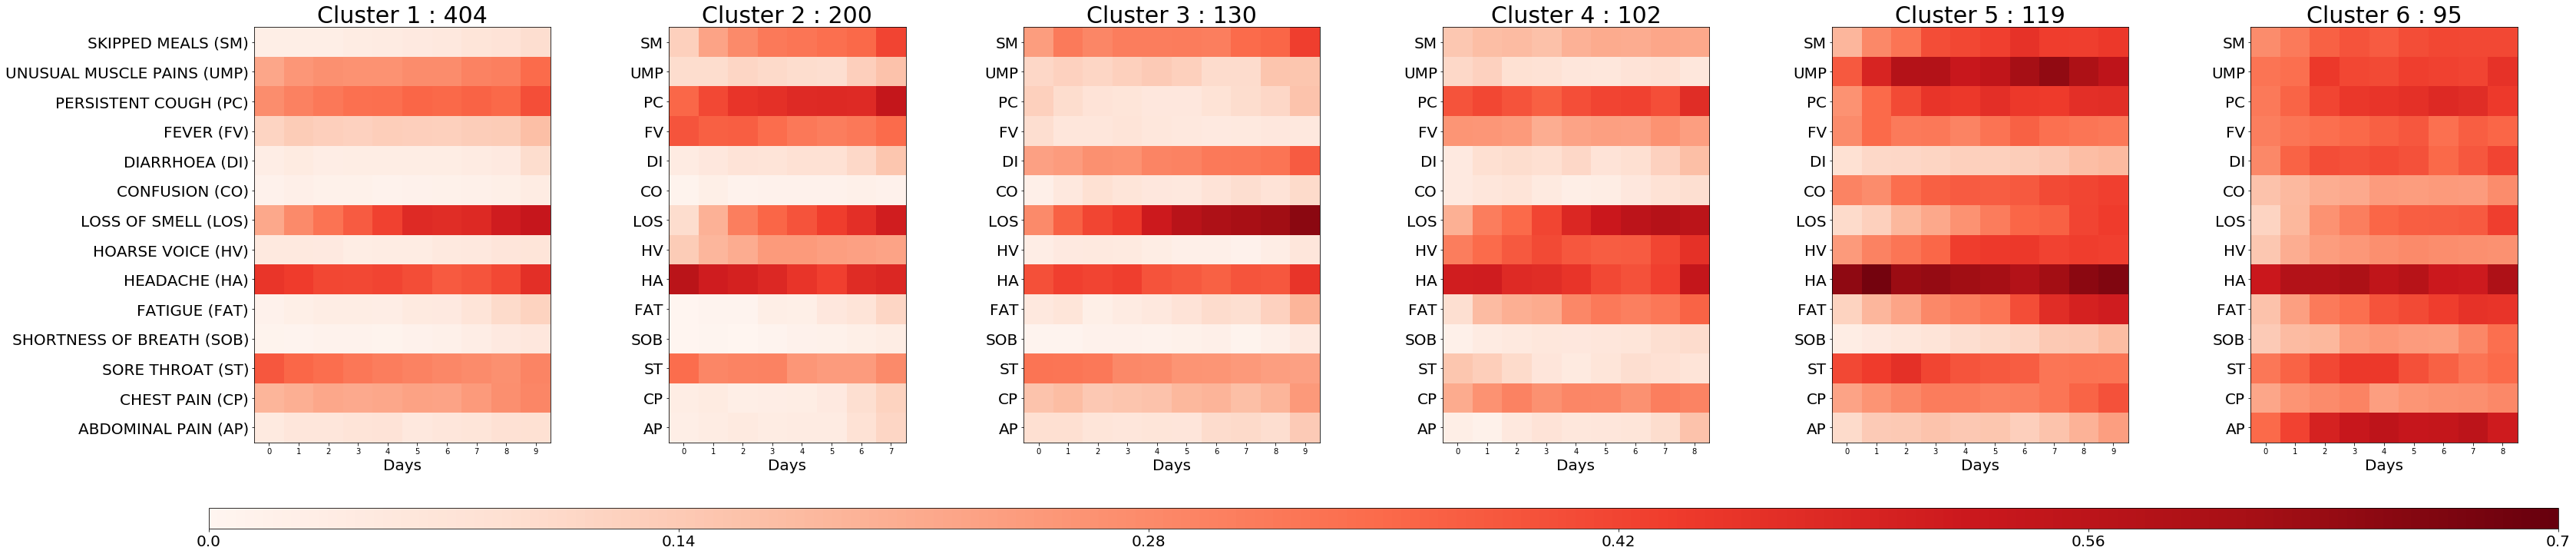

In [122]:
plotting_patterns_fromave(average_dictt[6],duration_dictt[6], classif_test,'',cmap='Reds',vmin=0,vmax=0.7)

# On tested models

In [19]:
df_train = pd.read_csv('Full2805WithAllStartFreq.csv')
df_test = pd.read_csv('FullTest2805.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,12,18,31,34,37,38,39,48,50,52,60,65,66,67,68,69,70,71,72,73,77,94,98,99,100,106,107,108,110,111,112,114,121,122,123,127,129,131,134,136,138,140,166,171,175,176,185,186,187,188,189,190,191,192,193,194,195,196,219,220,222,228,230,231,233,236,238,245,251,252,255) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,15,22,23,24,30,33,36,37,38,40,45,49,64,93,109,110,111,112,113,114,115,117,119,120,121,122,125,126,128,130,131,132,133,134,135,137,150,165,174,175,184,185,186,187,188,189,190,191,192,193,194,195,218,221,229,230,232,237,244,245,246,251,254) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [124]:

df_train = df_train.groupby('patient_id').apply(lambda group: start_sum_freq(group, list_symptoms))
    

In [125]:
df_train = prisma_score_encoding(df_train)
df_train['treatment_bin'] = np.where(df_train['max_treat']>2,1,0)

In [126]:
df_train.to_csv('Full2805WithAllStartFreq.csv')
df_test3.to_csv('FullTest2805.csv')

In [127]:
df_unique_train = df_train.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
df_unique_train.groupby(['clust6','hosp_bin'])['agg9_sum'].mean().unstack()

hosp_bin,0.0,1.0
clust6,,
0,17.093311,18.032143
1,19.337791,24.094872
2,18.506410,21.000000
3,22.441176,30.675532
4,25.636257,38.625000
5,27.903086,39.039474


In [87]:
df_unique_train = prisma_score_encoding(df_unique_train)

In [90]:
len(list(set(df_test3[df_test3['treatment_coded']>2]['patient_id'])))

41

In [128]:
import pandas as pd
import numpy as np
# from joblib import load
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score,f1_score, roc_curve

import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


criterion = ["gini", "entropy"]
n_estimators = [int(x) for x in np.logspace(start = 0, stop = 3, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 8, num = 8)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = [None,'balanced']
random_grid = {'criterion':criterion,
              'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}





In [89]:
df_unique_train['treatment_coded'].value_counts()

-1.0    174
 3.0     82
 0.0     23
 4.0     22
 2.0     21
 1.0     11
Name: treatment_coded, dtype: int64

In [129]:
df_unique_train['treatment_bin'].sum()

107

In [130]:
from sklearn.model_selection import cross_val_score
dict_sum = {}
dict_start = {}
dict_df = {}
df_unique_train= salvaging_bmi(df_unique_train)
df_unique_train['treatment_bin'] = np.where(df_unique_train['treatment_coded']>2,1,0)
df_unique = df_unique_train[(df_unique_train['bmi_clean']>16) & (df_unique_train['bmi_clean']<55) & (df_unique_train['age']>16) & (df_unique_train['age']<100)]
for d in range(2, 10):
    clust_proj = create_classif_fromdf(df_attribution, 'clustproj_%ddays'%d)
    dict_sum[d] = [c for c in df_unique.columns if 'sum%d'%d in c]
    dict_start[d] = [c for c in df_unique.columns if 'start%d'%d in c]
    df_unique = allocate_cluster(df_unique, clust_proj,'clustproj%d'%d)
    dict_df[d] = df_unique[df_unique['max_duration2']>=d].fillna(-1)
    
# # df_maxsum['any_treat'] = np.where(df_maxsum['treatment_coded']>1,1,0)
# df_maxsum7 = salvaging_bmi(df_unique_train[df_unique_train['max_duration2']>=7])
# df_maxsum_clean7 = df_maxsum7[(df_maxsum7['bmi_clean']>16) & (df_maxsum7['bmi_clean']<55) & (df_maxsum7['age']>16) & (df_maxsum7['age']<100)]
# df_maxsum_clean7 = df_maxsum_clean7.fillna(-1)



In [131]:
from sklearn.model_selection import cross_val_score

dict_dft = {}
for d in range(2, 10):
    clust_proj = create_classif_fromdf(df_attributiont, 'trainproj_%ddays'%d)
    df_utest = allocate_cluster(df_utest, clust_proj,'clustproj%d'%d)
    dict_dft[d] = df_utest[df_utest['max_duration2']>=d].fillna(-1)
    
# # df_maxsum['any_treat'] = np.where(df_maxsum['treatment_coded']>1,1,0)
# df_maxsum7 = salvaging_bmi(df_unique_train[df_unique_train['max_duration2']>=7])
# df_maxsum_clean7 = df_maxsum7[(df_maxsum7['bmi_clean']>16) & (df_maxsum7['bmi_clean']<55) & (df_maxsum7['age']>16) & (df_maxsum7['age']<100)]
# df_maxsum_clean7 = df_maxsum_clean7.fillna(-1)



In [317]:
df_unique.groupby('clust5')['hosp_bin'].mean()

clust5
0    0.171930
1    0.188720
2    0.285024
3    0.383085
4    0.409396
Name: hosp_bin, dtype: float64

In [132]:
for f in ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin']:
    df_unique[f] = df_unique[f].fillna(0)

In [133]:

FEATURES_D = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin']  
TARGET = ['treatment_bin']
rf_D = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_D = RandomizedSearchCV(estimator = rf_D, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

scores_D = cross_val_score(rf_random_D, 
                         df_unique[FEATURES_D], 
                         df_unique[TARGET].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
np.mean(scores_D)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.5s finished


0.7454767757210601

In [153]:

FEATURES_D = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin']  
TARGET_H = ['hosp_bin']
rf_HD = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_HD = RandomizedSearchCV(estimator = rf_HD, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

scores_HD = cross_val_score(rf_random_HD, 
                         df_unique[FEATURES_D], 
                         df_unique[TARGET_H].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
np.mean(scores_HD)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished


0.5901866109439668

In [136]:
df_unique['agg5_sum'] = np.where(df_unique['agg5_sum'].isna(),df_unique['agg4_sum'],df_unique['agg5_sum'])
df_unique['agg5_sum'] = np.where(df_unique['agg5_sum'].isna(),df_unique['agg3_sum'],df_unique['agg5_sum'])
df_unique['agg5_sum'] = np.where(df_unique['agg5_sum'].isna(),df_unique['agg2_sum'],df_unique['agg5_sum'])
df_unique['agg5_sum'] = np.where(df_unique['agg5_sum'].isna(),df_unique['agg1_sum'],df_unique['agg5_sum'])
np.unique(df_unique['agg5_sum'])




array([ 0.        ,  0.33333333,  0.5       ,  1.        ,  1.5       ,
        2.        ,  2.25      ,  2.5       ,  2.6       ,  2.66666667,
        2.75      ,  3.        ,  3.33333333,  3.5       ,  4.        ,
        4.33333333,  4.4       ,  4.5       ,  4.66666667,  4.75      ,
        5.        ,  5.33333333,  5.33333333,  5.5       ,  5.6       ,
        5.6       ,  5.66666667,  5.75      ,  6.        ,  6.2       ,
        6.25      ,  6.33333333,  6.5       ,  6.75      ,  7.        ,
        7.2       ,  7.25      ,  7.33333333,  7.5       ,  7.66666667,
        7.75      ,  8.        ,  8.2       ,  8.3       ,  8.3       ,
        8.33333333,  8.5       ,  8.6       ,  8.6       ,  8.66666667,
        8.8       ,  8.83333333,  9.        ,  9.33333333,  9.5       ,
        9.66666667,  9.66666667,  9.75      ,  9.8       , 10.        ,
       10.33333333, 10.5       , 10.6       , 10.75      , 10.8       ,
       10.83333333, 11.        , 11.33333333, 11.5       , 11.66

In [137]:
FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin'] + ['clustproj5'] +['agg5_sum']  
TARGET_T = ['treatment_bin']
rf_T = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_T = RandomizedSearchCV(estimator = rf_T, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

scores_T = cross_val_score(rf_random_T, 
                         df_unique[FEATURES_T], 
                         df_unique[TARGET_T].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
np.mean(scores_T)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.5s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.0s finished


0.8037167342522806

In [152]:
FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin'] + ['clustproj5'] +['agg5_sum']  
TARGET_H = ['hosp_bin']
rf_HT = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_HT = RandomizedSearchCV(estimator = rf_HT, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

scores_HT = cross_val_score(rf_random_HT, 
                         df_unique[FEATURES_T], 
                         df_unique[TARGET_H].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
np.mean(scores_HT)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.2s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.7s finished


0.6975448867336558

In [183]:
FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin'] + ['clustproj5'] +['agg5_sum']  
TARGET_T = ['treatment_bin']
rf_BT = RandomForestClassifier(class_weight='balanced')
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_BT = RandomizedSearchCV(estimator = rf_BT, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

scores_BT = cross_val_score(rf_random_BT, 
                         df_unique[FEATURES_T], 
                         df_unique[TARGET_T].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
np.mean(scores_BT)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.7s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.5s finished


0.7847428922123566

In [204]:
FEATURES_C = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','prisma_bin'] + dict_sum[5] 
TARGET_C = ['clust5']
rf_C = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random_C = RandomizedSearchCV(estimator = rf_C, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='accuracy',
                               random_state=33, 
                               n_jobs = -1)

scores_C = cross_val_score(rf_random_C, 
                         dict_df[5][FEATURES_C], 
                         dict_df[5][TARGET_C].values[:,0], 
                         cv=5, 
                         scoring='roc_auc_ovo')
np.mean(scores_C)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.3s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.2s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.3s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.3s finished


0.8287191149682898

In [2]:
import sklearn
# sklearn.metrics.SCORERS.keys()
sklearn.__version__

'0.22.2.post1'

(array([0.02923977, 0.07797271, 0.10818713, 0.12183236, 0.13255361,
        0.12768031, 0.11111111, 0.08187135, 0.0711501 , 0.0662768 ,
        0.03606238, 0.03606238]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 12 Patch objects>)

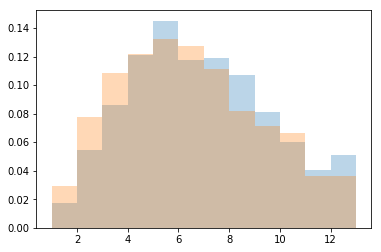

In [154]:
plt.hist(df_unique['sum_symp'],bins=np.arange(1,14),alpha=0.3,density=True)
plt.hist(df_utest['sum_symp'],bins=np.arange(1,14),alpha=0.3,density=True)

(array([0.00344234, 0.27538726, 0.19621343, 0.13769363, 0.07056799,
        0.07228916, 0.04991394, 0.03958692, 0.04130809, 0.02237522,
        0.02065404, 0.0172117 , 0.01549053, 0.00688468, 0.00516351,
        0.00344234, 0.00860585, 0.        , 0.00344234, 0.00172117,
        0.00516351, 0.00344234, 0.        , 0.        , 0.        ,
        0.        ]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 26 Patch objects>)

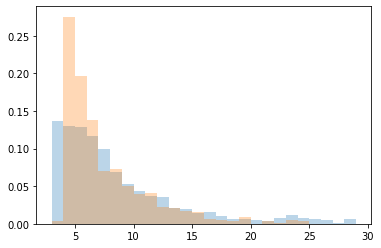

In [228]:
plt.hist(df_unique['max_duration2'],bins=np.arange(3,30),alpha=0.3,density=True)
plt.hist(df_utest['max_duration2'],bins=np.arange(3,30),alpha=0.3,density=True)

In [138]:
X_trainD = df_unique[FEATURES_D]
y_trainD = df_unique[TARGET]
clf_D = rf_random_D.fit(X_trainD, y_trainD)
pd.Series({fea:imp for fea, imp in zip(FEATURES_D, clf_D.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.4s finished
/mnt/data/csudre/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


has_lung_disease      0.251
bmi_clean             0.192
age                   0.185
prisma_bin            0.129
has_diabetes          0.107
has_heart_disease     0.055
has_kidney_disease    0.051
gender                0.030
dtype: float64

In [139]:
#FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','prisma_bin'] + ['clustproj5'] +['agg5_sum']  

X_train_T = df_unique[FEATURES_T]
y_train_T = df_unique[TARGET]
clf_T = rf_random_T.fit(X_train_T, y_train_T)
pd.Series({fea:imp for fea, imp in zip(FEATURES_T, clf_T.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.6s finished
/mnt/data/csudre/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


agg5_sum              0.311838
has_lung_disease      0.170029
bmi_clean             0.159899
age                   0.143717
clustproj5            0.104018
prisma_bin            0.068244
has_diabetes          0.030099
has_kidney_disease    0.005741
gender                0.003421
has_heart_disease     0.002994
dtype: float64

In [161]:
#FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','prisma_bin'] + ['clustproj5'] +['agg5_sum']  

X_train_HT = df_unique[FEATURES_T]
y_train_HT = df_unique[TARGET_H]
clf_HT = rf_random_HT.fit(X_train_HT, y_train_HT)
pd.Series({fea:imp for fea, imp in zip(FEATURES_T, clf_HT.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.8s finished


agg5_sum              0.353790
age                   0.198009
clustproj5            0.155432
prisma_bin            0.095691
bmi_clean             0.092564
has_lung_disease      0.028892
has_heart_disease     0.025249
has_diabetes          0.022477
has_kidney_disease    0.014922
gender                0.012976
dtype: float64

In [184]:
#FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','prisma_bin'] + ['clustproj5'] +['agg5_sum']  

X_train_BT = df_unique[FEATURES_T]
y_train_BT = df_unique[TARGET_T]
clf_BT = rf_random_BT.fit(X_train_BT, y_train_BT)
pd.Series({fea:imp for fea, imp in zip(FEATURES_T, clf_BT.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.3s finished
/mnt/data/csudre/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


agg5_sum              0.285422
bmi_clean             0.208348
age                   0.160202
has_lung_disease      0.140013
clustproj5            0.089165
prisma_bin            0.053210
has_diabetes          0.029796
gender                0.015475
has_kidney_disease    0.009873
has_heart_disease     0.008497
dtype: float64

In [162]:
#FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','prisma_bin'] + ['clustproj5'] +['agg5_sum']  

X_train_HD = df_unique[FEATURES_D]
y_train_HD = df_unique[TARGET_H]
clf_HD = rf_random_HD.fit(X_train_HD, y_train_HD)
pd.Series({fea:imp for fea, imp in zip(FEATURES_D, clf_HD.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.6s finished


age                   0.330445
prisma_bin            0.220733
bmi_clean             0.181832
has_lung_disease      0.085284
has_diabetes          0.083349
has_heart_disease     0.050950
has_kidney_disease    0.037509
gender                0.009899
dtype: float64

In [156]:
y_pred_t = clf_T.best_estimator_.predict_proba(X_train_T)
fpr_t, tpr_t, thresh_t = roc_curve(np.asarray(y_train_T), y_pred_t[:,1])
thresh_opt = thresh_t[np.argmax(tpr_t-fpr_t)]
print(thresh_opt, fpr_t[np.argmax(tpr_t-fpr_t)], tpr_t[np.argmax(tpr_t-fpr_t)])

0.23714160409544033 0.2846054333764554 0.7383177570093458


In [141]:
y_pred_d = clf_D.best_estimator_.predict_proba(X_trainD)
fpr_d, tpr_d, thresh_d = roc_curve(np.asarray(y_trainD), y_pred_d[:,1])
thresh_opt = thresh_t[np.argmax(tpr_d-fpr_d)]
print(thresh_opt, fpr_d[np.argmax(tpr_d-fpr_d)], tpr_d[np.argmax(tpr_d-fpr_d)])

0.05908621478219853 0.3311772315653299 0.7663551401869159


In [379]:
len(np.unique(y_pred_t[:,1]))

1288

In [149]:
import pickle

handle = 'ModelSeverityTreatment2805.pkl'

with open('ModelSeverityTreatment2805.pkl', 'wb') as handle:
    pickle.dump([clf_T, clf_D], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [165]:
import pickle

handle = 'ModelSeverityHosp2805.pkl'

with open('ModelSeverityHosp2805.pkl', 'wb') as handle:
    pickle.dump([clf_HT, clf_HD], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
import pickle
clf_T, clf_D = pickle.load( open( "ModelSeverityTreatment.pkl", "rb" ) )

In [99]:
FEATURES_D = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin']
FEATURES_T = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','has_kidney_disease','prisma_bin'] + ['clustproj5'] +['agg5_sum']  


In [344]:
test_pred = clf.best_estimator_.predict_proba(dict_dft[5][FEATURES_1])
np.max(test_pred[:,1])

0.7963684463684463

In [189]:
df_utest = salvaging_bmi(df_utest)
df_utest2 = df_utest[(df_utest['bmi_clean']<55) & (df_utest['bmi_clean']>16)]
df_utest2.groupby('learnt_clust')['bmi_clean'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,404.0,27.144771,5.680692,17.374453,22.816346,25.852574,30.439845,48.269993
1,199.0,28.230251,5.946620,16.361144,23.927816,26.775510,32.259991,45.546464
2,130.0,28.572086,6.471041,17.029353,24.023552,27.023588,32.266859,53.627181
3,102.0,27.248370,5.312205,18.920936,23.755343,25.992120,29.759928,46.344881
4,118.0,28.672511,6.460841,16.134884,24.514698,27.404970,31.613748,48.748950
5,94.0,29.311968,6.232016,16.213632,24.867642,28.988767,34.082293,44.245908


0.6945206889453098
0.09117690509551739 0.09210526315789473 0.4406779661016949


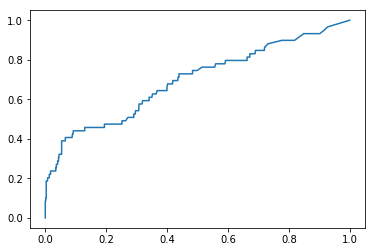

In [191]:
TARGET='treatment_bin'
test_predD = clf_D.best_estimator_.predict_proba(df_utest2[FEATURES_D])
fpr, tpr, thresh = roc_curve(df_utest2[TARGET], test_predD[:,1])
print(roc_auc_score(df_utest2[TARGET],test_predD[:,1]))
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])
plt.plot(fpr,tpr)

0.6123157596371882
0.23652626090170742 0.4154761904761905 0.6095238095238096


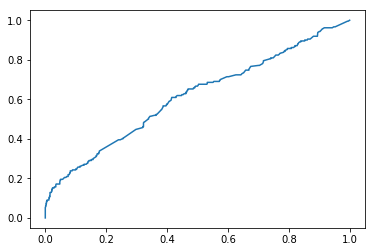

In [163]:
TARGET_H='hosp_bin'
test_predHD = clf_HD.best_estimator_.predict_proba(df_utest[FEATURES_D])
fpr, tpr, thresh = roc_curve(df_utest[TARGET_H], test_predHD[:,1])
print(roc_auc_score(df_utest[TARGET_H],test_predHD[:,1]))
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])
plt.plot(fpr,tpr)

In [146]:
df_utest['agg5_sum'] = np.where(df_utest['agg5_sum'].isna(), df_utest['agg4_sum'], df_utest['agg5_sum'])
df_utest['agg5_sum'] = np.where(df_utest['agg5_sum'].isna(), df_utest['agg3_sum'], df_utest['agg5_sum'])
df_utest['agg5_sum'] = np.where(df_utest['agg5_sum'].isna(), df_utest['agg2_sum'], df_utest['agg5_sum'])
df_utest['agg5_sum'] = np.where(df_utest['agg5_sum'].isna(), df_utest['sum_symp'], df_utest['agg5_sum'])

In [203]:
df_unique = encode_hcw(df_unique)
df_unique.groupby('clust6')[FEATURES_D+['hosp_bin','treatment_bin','hcw']].mean()

,age,bmi_clean,gender,has_lung_disease,has_heart_disease,has_diabetes,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin,hcw
clust6,,,,,,,,,,,
0,41.060606,26.854520,0.294372,0.136364,0.015152,0.021645,0.004329,0.000000,0.160173,0.015152,0.422078
1,43.247619,27.305985,0.263492,0.104762,0.009524,0.031746,0.006349,0.012698,0.174603,0.044444,0.482540
2,40.976852,26.851858,0.199074,0.101852,0.018519,0.041667,0.004630,0.000000,0.236111,0.037037,0.351852
3,43.028571,27.399746,0.167857,0.196429,0.021429,0.032143,0.010714,0.000000,0.246429,0.085714,0.335714
4,43.680751,27.951256,0.276995,0.197183,0.037559,0.042254,0.009390,0.032864,0.272300,0.098592,0.441315
5,43.772455,28.887696,0.245509,0.281437,0.041916,0.047904,0.017964,0.053892,0.455090,0.197605,0.293413


In [200]:
df_utest2.groupby('learnt_clust')[FEATURES_D+['hosp_bin','treatment_bin','hcw']].mean()

,age,bmi_clean,gender,has_lung_disease,has_heart_disease,has_diabetes,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin,hcw
learnt_clust,,,,,,,,,,,
0,44.225248,27.144771,0.212871,0.121287,0.007426,0.017327,0.004950,0.009901,0.116337,0.002475,0.519802
1,46.422111,28.230251,0.246231,0.150754,0.020101,0.040201,0.005025,0.020101,0.130653,0.025126,0.638191
2,45.900000,28.572086,0.215385,0.115385,0.015385,0.069231,0.000000,0.015385,0.138462,0.023077,0.476923
3,48.901961,27.248370,0.254902,0.186275,0.039216,0.019608,0.000000,0.019608,0.245098,0.078431,0.441176
4,48.076271,28.672511,0.288136,0.161017,0.059322,0.050847,0.016949,0.059322,0.372881,0.169492,0.440678
5,46.712766,29.311968,0.340426,0.308511,0.010638,0.074468,0.021277,0.085106,0.500000,0.234043,0.446809


In [209]:
df_unique.groupby(['clust6'])['bmi_clean','age'].describe()

bmi_clean                                                        \
           count       mean       std        min        25%        50%   
clust6                                                                   
0          462.0  26.854520  5.479315  18.328443  22.946412  25.513114   
1          315.0  27.305985  5.723337  18.144869  23.154442  26.014568   
2          216.0  26.851858  5.793881  16.301646  22.631259  25.686907   
3          280.0  27.399746  5.908541  16.640687  23.044363  26.354558   
4          213.0  27.951256  5.865368  18.637569  24.011739  26.747870   
5          167.0  28.887696  6.334223  19.076961  23.939874  27.822636   

                                age                                           \
              75%        max  count       mean        std   min    25%   50%   
clust6                                                                         
0       29.697253  48.959390  462.0  41.060606  11.606930  19.0  31.00  40.0   
1       30.227877  51.837607  315.0  43.247619  12.085245  19.0  33.00  43.0   
2       30.155987  51.503188  216.0  40.976852  12.386956  18.0  30.00  41.0   
3       30.120939  50.034755  280.0  43.028571  11.936476  20.0  34.75  42.0   
4       30.872541  49.599224  213.0  43.680751  13.196321  20.0  32.00  43.0   
5       32.509964  50.480501  167.0  43.772455  12.186145  18.0  33.00  44.0   

                     
          75%   max  
clust6               
0       50.75  74.0  
1       53.00  82.0  
2       51.00  74.0  
3       52.00  75.0  
4       53.00  92.0  
5       53.00  81.0

In [211]:
df_utest2.groupby(['learnt_clust'])['bmi_clean','age'].describe()

bmi_clean                                                        \
                 count       mean       std        min        25%        50%   
learnt_clust                                                                   
0                404.0  27.144771  5.680692  17.374453  22.816346  25.852574   
1                199.0  28.230251  5.946620  16.361144  23.927816  26.775510   
2                130.0  28.572086  6.471041  17.029353  24.023552  27.023588   
3                102.0  27.248370  5.312205  18.920936  23.755343  25.992120   
4                118.0  28.672511  6.460841  16.134884  24.514698  27.404970   
5                 94.0  29.311968  6.232016  16.213632  24.867642  28.988767   

                                      age                                     \
                    75%        max  count       mean        std   min    25%   
learnt_clust                                                                   
0             30.439845  48.269993  404.0  44.225248  12.343361  20.0  34.00   
1             32.259991  45.546464  199.0  46.422111  14.055903  18.0  35.50   
2             32.266859  53.627181  130.0  45.900000  13.515337  19.0  35.25   
3             29.759928  46.344881  102.0  48.901961  14.512207  21.0  39.00   
4             31.613748  48.748950  118.0  48.076271  15.530041  19.0  36.00   
5             34.082293  44.245908   94.0  46.712766  15.751172  21.0  34.00   

                                
               50%   75%   max  
learnt_clust                    
0             45.0  54.0  76.0  
1             47.0  54.5  93.0  
2             48.0  55.0  86.0  
3             49.0  58.0  95.0  
4             47.0  57.0  91.0  
5             45.5  57.0  93.0

In [196]:
with open('ModelSeverityTreatment2805.pkl', "rb") as input_file:
    clf_T, clf_D = pickle.load(input_file)
print(clf_T)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

0.7887789061963906
0.08785229531390663 0.19534412955465588 0.6779661016949152


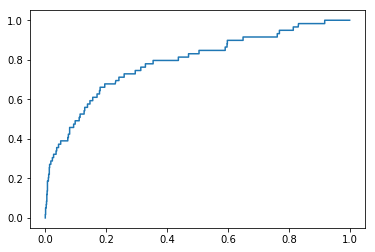

In [197]:

test_predT = clf_T.best_estimator_.predict_proba(df_utest2[FEATURES_T])
fpr, tpr, thresh = roc_curve(df_utest2[TARGET], test_predT[:,1])
print(roc_auc_score(df_utest2[TARGET],test_predT[:,1]))
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])
plt.plot(fpr,tpr)

0.7820212420256889
0.07835481064308134 0.27547931382441976 0.7627118644067796


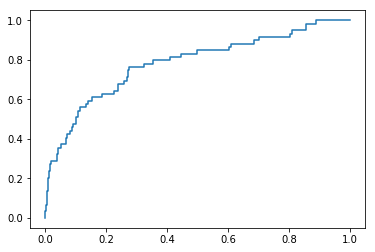

In [185]:

test_predBT = clf_BT.best_estimator_.predict_proba(df_utest[FEATURES_T])
fpr, tpr, thresh = roc_curve(df_utest[TARGET], test_predBT[:,1])
print(roc_auc_score(df_utest[TARGET],test_predBT[:,1]))
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])
plt.plot(fpr,tpr)

0.7349546485260772
0.20425907443570374 0.40476190476190477 0.7523809523809524


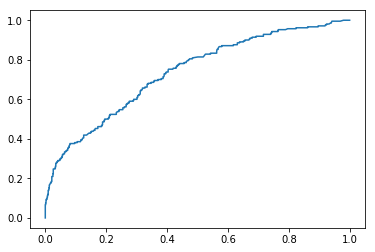

In [164]:

test_predHT = clf_HT.best_estimator_.predict_proba(df_utest[FEATURES_T])
fpr, tpr, thresh = roc_curve(df_utest[TARGET_H], test_predHT[:,1])
print(roc_auc_score(df_utest[TARGET_H],test_predHT[:,1]))
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])
plt.plot(fpr,tpr)

In [388]:
print(thresh[np.argmax(tpr-fpr)], fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)])

0.08603348067471982 0.2992565055762082 0.7450980392156863


In [394]:
print(thresh[59], fpr[58],tpr[58])

0.0903718420756592 0.2732342007434944 0.7058823529411765


In [177]:
y_bin_T = test_predT[:,1]>0.066
print(precision_score(df_utest[TARGET],y_bin_T))

0.11084905660377359


In [178]:
df_utest['predRS'] = y_bin_T
df_utest.groupby(['country_code_x','treatment_bin','predRS']).size().unstack()

predRS                        False  True 
country_code_x treatment_bin              
GB             0                543    328
               1                  8     41
SE             0                 47     26
               1                  3      5
US             0                 24     23
               1                  1      1

In [179]:
df_utest['FP'] = np.where(np.logical_and(df_utest['predRS']==1, df_utest['treatment_bin']==0),1,0)
df_utest['TP'] = np.where(np.logical_and(df_utest['predRS']==1, df_utest['treatment_bin']==1),1,0)
df_utest['TN'] = np.where(np.logical_and(df_utest['predRS']==0, df_utest['treatment_bin']==0),1,0)
df_utest['FN'] = np.where(np.logical_and(df_utest['predRS']==0, df_utest['treatment_bin']==1),1,0)

In [212]:
df_utest2.groupby(['learnt_clust','FP'])['bmi_clean'].mean().unstack()

FP,0,1
learnt_clust,,
0,26.428799,29.642718
1,26.986944,30.118818
2,27.322927,31.099455
3,25.948647,29.262940
4,26.531207,30.140834
5,27.960961,30.403167


In [213]:
df_utest2.groupby(['learnt_clust','FP'])['agg5_sum'].mean().unstack()

FP,0,1
learnt_clust,,
0,8.568949,18.140926
1,9.322222,15.611603
2,8.435057,15.627907
3,11.014516,17.420833
4,15.267708,23.188095
5,17.698413,22.357372


In [400]:
y_bin_T = np.where(test_predT[:,1]>=0.2,1,0)
np.sum(y_bin_T * np.asarray(df_utest[TARGET]))

2907

In [150]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix
n_bootstraps = 1000
rng_seed = 42  # control reproducibility

y_true = np.asarray(df_utest[TARGET])
y_pred = np.asarray(test_predT[:,1])


def bootstrap_results(y_true, y_pred, n_bootstrap=1000, rng_seed=42,opt_thresh=0.5):
    rng = np.random.RandomState(rng_seed)
    y_bin = y_pred>=opt_thresh
    bootstrapped_scores_auc = []
    bootstrapped_scores_prec = []
    bootstrapped_scores_rec = []
    bootstrapped_scores_fpr = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score_auc = roc_auc_score(y_true[indices], y_pred[indices])
        score_prec = precision_score(y_true[indices],y_bin[indices])
        score_rec = recall_score(y_true[indices],y_bin[indices])
        tn, fp, fn, tp = confusion_matrix(y_true[indices],y_bin[indices]).ravel()
        bootstrapped_scores_fpr.append(fp/(fp+tn))
        bootstrapped_scores_auc.append(score_auc)
        bootstrapped_scores_prec.append(score_prec)
        bootstrapped_scores_rec.append(score_rec)
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

    sorted_scores_auc = np.array(bootstrapped_scores_auc)
    sorted_scores_prec = np.array(bootstrapped_scores_prec)
    sorted_scores_rec = np.array(bootstrapped_scores_rec)
    sorted_scores_fpr = np.array(bootstrapped_scores_fpr)
    sorted_scores_auc.sort()
    sorted_scores_prec.sort()
    sorted_scores_rec.sort()
    sorted_scores_fpr.sort()
    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower_auc = sorted_scores_auc[int(0.05 * len(sorted_scores_auc))]
    confidence_upper_auc = sorted_scores_auc[int(0.95 * len(sorted_scores_auc))]
    confidence_mean_auc = np.mean(sorted_scores_auc)
    
    confidence_lower_rec = sorted_scores_rec[int(0.05 * len(sorted_scores_rec))]
    confidence_upper_rec = sorted_scores_rec[int(0.95 * len(sorted_scores_rec))]
    confidence_mean_rec = np.mean(sorted_scores_rec)
    
    confidence_lower_prec = sorted_scores_prec[int(0.05 * len(sorted_scores_prec))]
    confidence_upper_prec = sorted_scores_prec[int(0.95 * len(sorted_scores_prec))]
    confidence_mean_prec = np.mean(sorted_scores_prec)
    
    confidence_lower_fpr = sorted_scores_fpr[int(0.05 * len(sorted_scores_fpr))]
    confidence_upper_fpr = sorted_scores_fpr[int(0.95 * len(sorted_scores_fpr))]
    confidence_mean_fpr = np.mean(sorted_scores_fpr)
    print("Confidence interval for the AUC:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_auc,
        confidence_lower_auc, confidence_upper_auc))
    print("Confidence interval for the FPR:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_fpr,
        confidence_lower_fpr, confidence_upper_fpr))
    print("Confidence interval for the recall:{:0.3f} [{:0.3f} - {:0.3}]".format(confidence_mean_rec,
        confidence_lower_rec, confidence_upper_rec))

In [151]:
label = np.asarray(df_utest[TARGET])
y_predT = np.asarray(test_predT[:,1])
y_predD = np.asarray(test_predD[:,1])
bootstrap_results(y_true, y_predT, n_bootstrap=1000, rng_seed=42,opt_thresh=0.066)
bootstrap_results(y_true, y_predD, n_bootstrap=1000, rng_seed=42,opt_thresh=0.059)

Confidence interval for the AUC:0.788 [0.731 - 0.842]
Confidence interval for the FPR:0.380 [0.353 - 0.406]
Confidence interval for the recall:0.799 [0.712 - 0.877]
Confidence interval for the AUC:0.693 [0.623 - 0.758]
Confidence interval for the FPR:0.465 [0.438 - 0.49]
Confidence interval for the recall:0.728 [0.632 - 0.822]


In [110]:
bootstrap_results(y_true, y_predT, n_bootstrap=1000, rng_seed=42,opt_thresh=0.1244)
bootstrap_results(y_true, y_predD, n_bootstrap=1000, rng_seed=42,opt_thresh=0.0722)

Confidence interval for the AUC:0.787 [0.723 - 0.847]
Confidence interval for the FPR:0.214 [0.192 - 0.236]
Confidence interval for the recall:0.754 [0.636 - 0.861]
Confidence interval for the AUC:0.684 [0.608 - 0.755]
Confidence interval for the FPR:0.447 [0.421 - 0.473]
Confidence interval for the recall:0.753 [0.638 - 0.861]


In [111]:
df_test3.to_csv('FinalTestDataWithStartSumFreq_1105.csv')

In [112]:
df_utest.to_csv('UniqueFinalTest_1105.csv')

In [362]:
df_utest.groupby(['learnt_clust','hosp_bin'])['max_duration2'].mean()

learnt_clust  hosp_bin
0             0.0         45
              1.0         45
1             0.0         45
              1.0         45
2             0.0         45
              1.0         45
3             0.0         45
              1.0         45
4             0.0         45
              1.0         45
Name: max_duration2, dtype: int64

In [354]:
roc_auc_score(dict_dft[5][TARGET_T],test_pred[:,1])

0.7585546939448936

In [361]:
roc_auc_score(dict_dft[5][TARGET_T],test_pred1[:,1])

0.6461475004124733

# Association between clusters and comorbidities

In [215]:

# statsmodels.formula.api.mnlogit(formula, data, subset=None, drop_cols=None, *args, **kwargs)¶

formula_clust='clust6 ~ bmi_clean + age + C(has_lung_disease) + C(gender) + C(has_diabetes) + C(has_heart_disease) + C(has_kidney_disease)'
from statsmodels.formula.api import mnlogit
# df_unique_full = df_interp.sort_values('interval_days',ascending=False).drop_duplicates('patient_id')
df_maxsum = df_unique_train
df_maxsum_clean = df_maxsum[(df_maxsum['age']>16) & (df_maxsum['age']<100) & (df_maxsum['bmi_clean']>16) & (df_maxsum['bmi_clean']<55)]
df_maxsum_clean = df_maxsum_clean.fillna(-1)
df_maxsum_clean = df_maxsum_clean.replace('False',0)
df_maxsum_clean = df_maxsum_clean.replace('True',1)
test_logit = mnlogit(formula=formula_clust, data=df_maxsum_clean)
res_logit = test_logit.fit()
res_logit.summary()

         Current function value: 1.704894
         Iterations: 35


/mnt/data/csudre/.local/lib/python3.5/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 clust6   No. Observations:                 1653
Model:                        MNLogit   Df Residuals:                     1608
Method:                           MLE   Df Model:                           40
Date:                Sat, 30 May 2020   Pseudo R-squ.:                 0.01708
Time:                        12:48:37   Log-Likelihood:                -2818.2
converged:                      False   LL-Null:                       -2867.2
Covariance Type:            nonrobust   LLR p-value:                 9.193e-07
=================================================================================================
                     clust6=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.2705      0.427     -2.978      0.003      -2.107      -0.434
C(has_lung_disease)[T.True]      -0.3162      0.230     -1.374      0.169      -0.767       0.135
C(gender)[T.1.0]                 -0.2314      0.167     -1.389      0.165      -0.558       0.095
C(gender)[T.2.0]                 13.9442    762.849      0.018      0.985   -1481.213    1509.102
C(has_diabetes)[T.True]           0.2769      0.464      0.597      0.550      -0.632       1.186
C(has_heart_disease)[T.True]     -0.6508      0.703     -0.926      0.355      -2.029       0.727
C(has_kidney_disease)[T.True]     0.2128      1.010      0.211      0.833      -1.768       2.193
bmi_clean                         0.0112      0.013      0.841      0.400      -0.015       0.037
age                               0.0161      0.006      2.561      0.010       0.004       0.029
-------------------------------------------------------------------------------------------------
                     clust6=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.5939      0.470     -1.263      0.206      -1.515       0.327
C(has_lung_disease)[T.True]      -0.3521      0.265     -1.331      0.183      -0.871       0.166
C(gender)[T.1.0]                 -0.5393      0.201     -2.686      0.007      -0.933      -0.146
C(gender)[T.2.0]                 -0.0615   1311.341  -4.69e-05      1.000   -2570.242    2570.119
C(has_diabetes)[T.True]           0.7760      0.478      1.622      0.105      -0.162       1.714
C(has_heart_disease)[T.True]      0.2623      0.644      0.407      0.684      -0.999       1.524
C(has_kidney_disease)[T.True]    -0.0280      1.233     -0.023      0.982      -2.445       2.389
bmi_clean                        -0.0006      0.015     -0.041      0.968      -0.030       0.029
age                              -0.0001      0.007     -0.015      0.988      -0.014       0.014
-------------------------------------------------------------------------------------------------
                     clust6=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.3020      0.439     -2.967      0.003      -2.162      -0.442
C(has_lung_disease)[T.True]       0.4078      0.205      1.988      0.047       0.006       0.810
C(gender)[T.1.0]                 -0.7914      0.193     -4.109      0.000      -1.169      -0.414
C(gender)[T.2.0]                  0.0844   1311.327   6.44e-05      1.000   -2570.069    2570.238
C(has_diabetes)[T.True]           0.2701      0.478      0.565      0.572      -0.666       1.206
C(has_heart_disease)[T.True]      0.2354      0.573      0.411      0.681      -0.888       1.359
C(has_k

In [37]:
df_unique_nohosp['patient_id'].to_csv('ListNoHospRecovLong.csv')

/home/csudre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
df_interp2 = df_interp.groupby('patient_id').apply(lambda group: average_start_fin_freq(group))

In [128]:
df_unique_temp = df_interp2.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
list_ever2 = [c for c in df_unique_temp.columns if 'ever2_' in c]
df_unique_temp[list_ever2].mean()

ever2_abdominal_pain          0.115076
ever2_chest_pain              0.222902
ever2_sore_throat             0.403226
ever2_sob2                    0.018364
ever2_fatigue2                0.066778
ever2_headache                0.563275
ever2_hoarse_voice            0.173951
ever2_loss_of_smell           0.233392
ever2_delirium                0.076795
ever2_diarrhoea               0.139399
ever2_fever                   0.214708
ever2_persistent_cough        0.352254
ever2_unusual_muscle_pains    0.277922
ever2_skipped_meals           0.187813
dtype: float64

In [10]:
def startrat_days(df, list_symptoms, numbdays):
    for f in list_symptoms:
        df['start%d_' % numbdays +f] = np.where(np.logical_and(df['start_'+f]<numbdays, df['start_'+f]>0),df['start_'+f]/(numbdays-1.0),-1 )
    return df

In [12]:
def sumat_days(dfg, list_symptoms):
    for n in range(1,11):
        for f in list_symptoms:
            dfg['sum%d_' %n+f] = dfg[f].head(n).fillna(0).sum()
    return dfg


In [13]:
def values_at_days(dfg, list_symptoms, numbdays):
    for f in list_symptoms:
        if dfg['idx_interval'].max()>=numbdays:
#             print(dfg['idx_interval'].max(),dfg[dfg['idx_interval']==numbdays][f])
            dfg['value%d_'%numbdays +f] = dfg[dfg['idx_interval']==numbdays][f]
        else:
            dfg['value%d_'%numbdays+f] = dfg[f].tail(1)
        #print(dfg['value%d_'%numbdays+f].max())
    return dfg




In [14]:
def aggregate_features_importance(model_list):
    list_fi = []
    list_rank_fi = []
    for m in model_list:
        fi = m.feature_importances_
        list_rank_fi.append(np.argsort(np.argsort(-1*fi)))
        list_fi.append(fi)
    array_fi = np.asarray(list_fi)
    print(array_fi.shape)
    array_rank = np.asarray(list_rank_fi)
    return np.mean(array_fi,0), np.mean(array_rank,0)

In [35]:
def salvaging_bmi(df_reg_new):

    df_reg_new['weight_clean'] = df_reg_new['weight_kg']
    #Stone range
    df_reg_new['weight_clean'] = np.where(df_reg_new['weight_kg']<25, 6.35029*df_reg_new['weight_kg'], df_reg_new['weight_clean'])
    # Pounds range
    df_reg_new['weight_clean'] = np.where(np.logical_and(df_reg_new['weight_kg']>150,df_reg_new['weight_kg']<300),0.453592*df_reg_new['weight_kg'], df_reg_new['weight_clean'])
    # Mix up imperial for metric
    df_reg_new['weight_clean'] = np.where(np.logical_and(df_reg_new['weight_kg']>300,df_reg_new['weight_kg']<450),df_reg_new['weight_kg']/6.35029, df_reg_new['weight_clean'])
    df_reg_new['weight_clean'] = np.where(np.logical_and(df_reg_new['weight_kg']>600,df_reg_new['weight_kg']<1500),df_reg_new['weight_kg']/10, df_reg_new['weight_clean'])
    df_reg_new['weight_clean'] = np.where(np.logical_and(df_reg_new['weight_clean']>450,df_reg_new['weight_clean']<600),df_reg_new['weight_clean']/6.35029, df_reg_new['weight_clean'])


    df_reg_new['height_clean'] = df_reg_new['height_cm']
    # Mix up meters for cm
    df_reg_new['height_clean'] = np.where(df_reg_new['height_cm']<2.4, 100*df_reg_new['height_cm'], df_reg_new['height_clean'])
    # Mix up imperial for metric
    df_reg_new['height_clean'] = np.where(df_reg_new['height_clean']<7.4, 30.48*np.round(df_reg_new['height_cm']/10,0) + 2.54*df_reg_new['height_cm']%10, df_reg_new['height_clean'])
    #df_reg_new['height_clean'] = np.where(np.logical_and(df_reg_new['height_clean']>40, df_reg_new['height_clean']<75), 
    # Mix up metric for imperial
    df_reg_new['height_clean'] = np.where(df_reg_new['height_clean']>4000, df_reg_new['height_clean']/30.48, df_reg_new['height_clean'])
    
    # Cleaning up bmi
    df_reg_new['bmi_clean'] = df_reg_new['weight_clean']/np.square(df_reg_new['height_clean']/100)
    return df_reg_new

In [16]:
df_interp3 = df_interp2.drop(columns=['level_0','level_1','patient_id','Unnamed: 0'])

In [17]:

df_interp3 = df_interp3.reset_index().rename(columns={'level_1':'idx_interval'})

In [18]:
df_interp4 = df_interp3.groupby('patient_id').apply(lambda group: values_at_days(group,list_symptoms,7))

In [19]:
df_interp4 = df_interp4.groupby('patient_id').apply(lambda group: sumat_days(group,list_symptoms))
list_values = [c for c in df_interp4.columns if 'value7' in c]
for f in list_values: 
    df_interp4[f] = df_interp4.groupby('patient_id')[f].transform('max')


In [20]:
df_maxsum=df_interp4.sort_values('sum_symp').drop_duplicates('patient_id')
#df_maxsum = df_maxsum.drop(columns=['patient_id'])
for f in range(4,10):
    df_maxsum = startrat_days(df_maxsum,list_symptoms,f)
list_start = ['start_'+f for f in list_symptoms]
list_startrat = ['startrat_'+f for f in list_symptoms]
list_sumrat = ['sumrat_'+f for f in list_symptoms]
list_sum = ['sum_'+f for f in list_symptoms]
list_ever = ['ever_'+f for f in list_symptoms]

In [21]:
for n in range(1,11):
    df_maxsum['sum%d_symp'%n] =0
    for f in list_symptoms:
        df_maxsum['sum%d_symp'%n] += df_maxsum['sum%d_'%n+f]

In [114]:
prisma_7 = ['age',
            'gender',
            'limited_activity',
            'needs_help', 
            'housebound_problems',
            'help_available',
            'mobility_aid']
def prisma_score_encoding(df):
    df['prisma'] = np.asarray(df['age']>85).astype(float) + np.asarray(df['gender']==1).astype(float) + np.asarray(df['needs_help']==1).astype(float) + np.asarray(df['housebound_problems']==1).astype(float) + np.asarray(df['help_available']==0).astype(float) + np.asarray(df['mobility_aid']==1).astype(float)
    df['prisma_bin'] = np.where(df['prisma']>=3, 1,0)
    return df

df_unique = prisma_score_encoding(df_unique)

In [184]:
df_unique.groupby(['clust5','hosp_bin'])['prisma_bin'].mean().unstack()

hosp_bin,0.0,1.0
clust5,,
0,0.000000,0.000000
1,0.000000,0.011494
2,0.006757,0.016949
3,0.000000,0.077922
4,0.011364,0.065574


In [23]:
for f in list_symptoms:
    df_maxsum['ever_'+f] = np.where(df_maxsum['startrat_'+f]>-1,1,0)
#list_ever = [c for c in df_maxsum.columns if 'ever_' in c and 'smo' not in c]

In [24]:
df_unique3 = df_maxsum
df_unique3 = df_unique3.replace(-1,np.nan)
for f in list_symptoms:
    df_unique3['end_'+f] = df_unique3['start_'+f] + df_unique3['sum_'+f]
    df_unique3['endrat_'+f] = df_unique3['startrat_'+f] + df_unique3['sumrat_'+f]

In [14]:
df_interp2 = pd.read_csv('FinalClusteringUpdateBetter_Data2104.csv')

/home/csudre/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (74,76,78,80,81,86,158) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0, 0.5, 'Cluster')

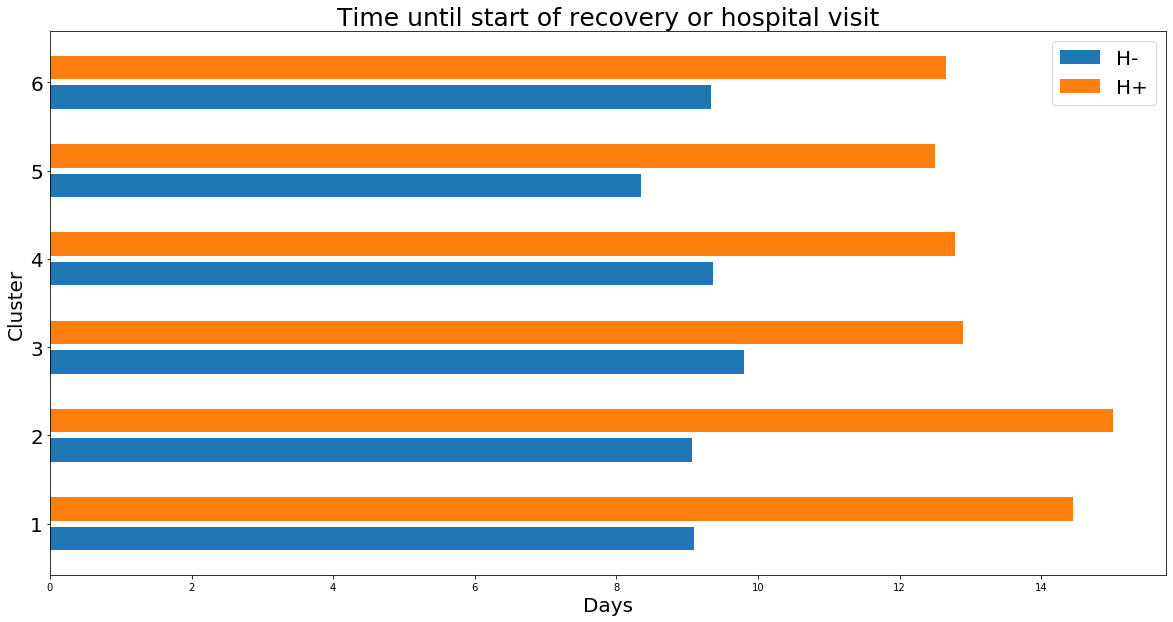

In [125]:
max_dura = np.asarray(df_maxsum_clustproj.groupby(['old','hosp_bin'])['max_duration'].mean().unstack())

fig = plt.figure(figsize=(20,10))
plt.barh(np.arange(0,18,3),np.asarray(max_dura)[:,0].T)
plt.barh(np.arange(0,18,3)+1,np.asarray(max_dura)[:,1].T)
plt.yticks(np.arange(0.5,18,3),labels=['1','2','3','4','5','6'],fontsize=20)
plt.legend(['H-','H+'],fontsize=20)
plt.title('Time until start of recovery or hospital visit',fontsize=25)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Cluster',fontsize=20)

In [128]:
df_maxsum_clustproj[df_maxsum_clustproj['hosp_bin']==1].groupby('old')['treatment_bin'].mean()

old
1    0.155556
2    0.095745
3    0.189655
4    0.582090
5    0.500000
6    0.378788
Name: treatment_bin, dtype: float64

In [112]:
for f in df_train.columns:
    print(f)

level_0
Unnamed: 0
Unnamed: 0.1
patient_id
interval_sick
Unnamed: 0.1.1
Unnamed: 0.1.1.1
abdominal_pain
age
already_had_covid
always_used_shortage_x
always_used_shortage_y
bmi
bmi_clean
cancer_clinical_trial_site
cancer_type
chest_pain
classic_sum
classic_symptoms
classic_symptoms_days_ago
classic_symptoms_x
classic_symptoms_y
clinical_study_institutions
clinical_study_names
clinical_study_nct_ids
consecutive
contact_health_worker
country_code_x
country_code_y
created_at_x
created_at_y
days_to_hosp
delirium
diarrhoea
diff_21st
diff_lh
does_chemotherapy
ethnicity
fatigue
fatigue2
fever
first_entry_sum
gender
guessed_pos
had_covid_test
has_cancer
has_diabetes
has_heart_disease
has_kidney_disease
has_lung_disease
have_used_PPE_x
have_used_PPE_y
have_worked_in_hospital_care_facility
have_worked_in_hospital_clinic
have_worked_in_hospital_home_health
have_worked_in_hospital_inpatient
have_worked_in_hospital_other
have_worked_in_hospital_outpatient
have_worked_in_hospital_school_clinic
headac

In [166]:
df_train = df_train.reset_index(drop=True)
for f in list_symptoms:
    df_train['ever_'+f] = df_train.groupby('patient_id')[f].transform('max')
df_unique3 = df_train.sort_values('sum_symp',ascending=False).drop_duplicates('patient_id')
list_startrat=[c for c in df_unique3.columns if 'start5_' in c]
list_sumrat=[c for c in df_unique3.columns if 'sum5_' in c]
list_ever=[c for c in df_unique3.columns if 'ever5_' in c]

In [167]:
for f in list_symptoms:
    df_unique3['ever5_'+f] = df_unique3['ever5_'+f].replace(-1,np.nan)
    df_unique3['ever5_'+f] = np.where(df_unique3['ever5_'+f].isna(),df_unique3['ever4_'+f], df_unique3['ever5_'+f])
    df_unique3['ever5_'+f] = df_unique3['ever5_'+f].replace(-1,np.nan)
    df_unique3['ever5_'+f] = np.where(df_unique3['ever5_'+f].isna(),df_unique3['ever3_'+f], df_unique3['ever5_'+f]) 
    df_unique3['ever5_'+f] = df_unique3['ever5_'+f].replace(-1,np.nan)
    df_unique3['ever5_'+f] = np.where(df_unique3['ever5_'+f].isna(),df_unique3['ever2_'+f], df_unique3['ever5_'+f])
    df_unique3['ever5_'+f] = df_unique3['ever5_'+f].replace(-1,np.nan)
    df_unique3['ever5_'+f] = np.where(df_unique3['ever5_'+f].isna(),df_unique3['ever1_'+f], df_unique3['ever5_'+f])
    df_unique3['ever5_'+f] = df_unique3['ever5_'+f].replace(-1,np.nan)
df_unique3['ever5_headache'].describe()

count    1572.000000
mean        0.747169
std         0.427819
min         0.000000
25%         0.500000
50%         1.000000
75%         1.000000
max         1.000000
Name: ever5_headache, dtype: float64

In [230]:
for f in list_symptoms:
    df_unique3['sum5_'+f] = df_unique3['sum5_'+f].replace(-1,np.nan)
    df_unique3['sum5_'+f] = np.where(df_unique3['sum5_'+f].isna(),df_unique3['sum4_'+f], df_unique3['sum5_'+f])
    df_unique3['sum5_'+f] = df_unique3['sum5_'+f].replace(-1,np.nan)
    df_unique3['sum5_'+f] = np.where(df_unique3['sum5_'+f].isna(),df_unique3['sum3_'+f], df_unique3['sum5_'+f]) 
    df_unique3['sum5_'+f] = df_unique3['sum5_'+f].replace(-1,np.nan)
    df_unique3['sum5_'+f] = np.where(df_unique3['sum5_'+f].isna(),df_unique3['sum2_'+f], df_unique3['sum5_'+f])
    df_unique3['sum5_'+f] = df_unique3['sum5_'+f].replace(-1,np.nan)
    df_unique3['sum5_'+f] = np.where(df_unique3['sum5_'+f].isna(),df_unique3['sum1_'+f], df_unique3['sum5_'+f])
    df_unique3['sum5_'+f] = df_unique3['sum5_'+f].replace(-1,np.nan)
df_unique3['sum5_headache'].describe()

count    1653.000000
mean        2.059095
std         1.729842
min         0.000000
25%         0.000000
50%         2.000000
75%         3.500000
max         5.000000
Name: sum5_headache, dtype: float64

In [231]:
for f in list_symptoms:
    df_unique3['nsum5_'+f] = np.where(df_unique3['ever5_'+f]==0, np.nan, df_unique3['sum5_'+f])
df_unique3['nsum5_headache'].describe()

count    1360.000000
mean        2.502708
std         1.589481
min         0.000000
25%         1.000000
50%         2.500000
75%         4.000000
max         5.000000
Name: nsum5_headache, dtype: float64

In [232]:
for f in list_symptoms:
    df_unique3['z_ever5_'+f] = (df_unique3['ever5_'+f] - df_unique3['ever5_'+f].mean()) / df_unique3['ever5_'+f].std()
    df_unique3['z_sum5_'+f] = (df_unique3['sum5_'+f] - df_unique3['sum5_'+f].mean()) / df_unique3['sum5_'+f].std()
    df_unique3['z_nsum5_'+f] = (df_unique3['nsum5_'+f] - df_unique3['nsum5_'+f].mean()) / df_unique3['nsum5_'+f].std()
    

[Text(0, 0, '0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0')]

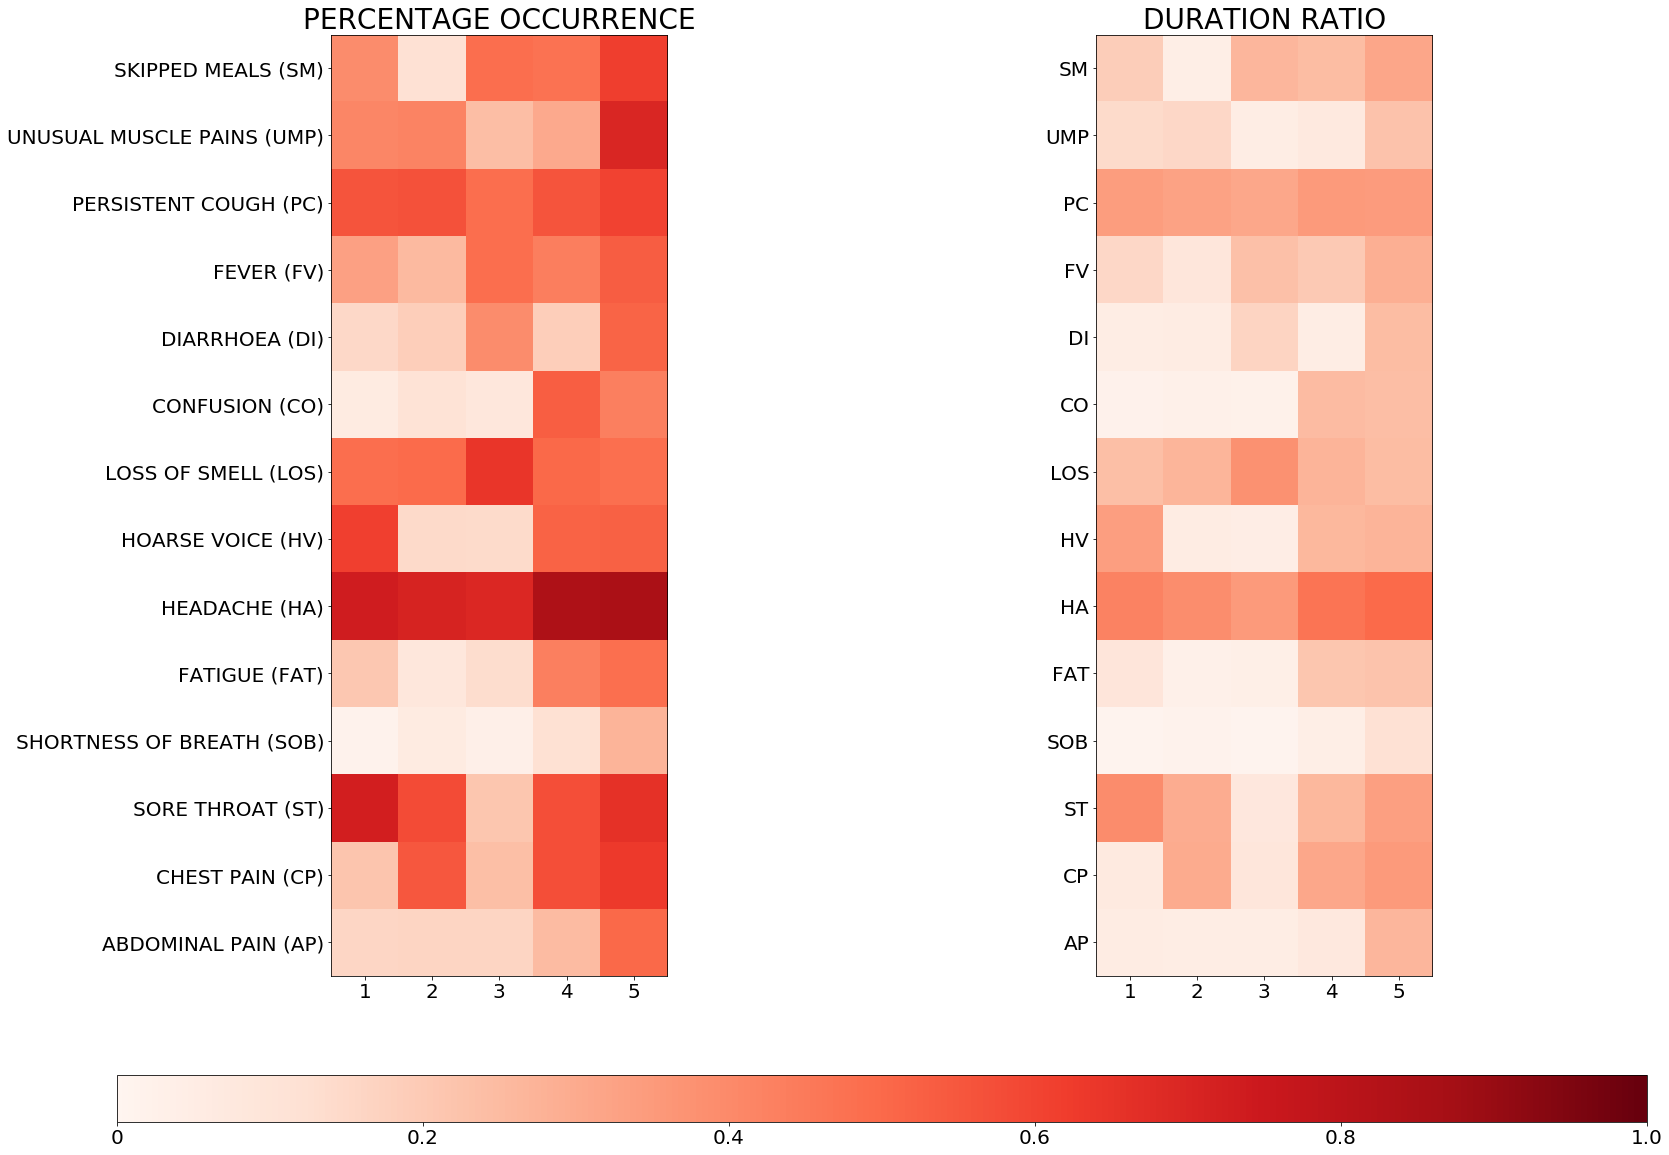

In [233]:
list_SE = ['ABDOMINAL PAIN','CHEST PAIN','SORE THROAT', 'SHORTNESS OF BREATH','FATIGUE','HEADACHE','HOARSE VOICE','LOSS OF SMELL',
          'CONFUSION','DIARRHOEA','FEVER','PERSISTENT COUGH','UNUSUAL MUSCLE PAINS','SKIPPED MEALS']


list_startrat=[c for c in df_unique3.columns if 'sum5_' in c]
list_sumrat=[c for c in df_unique3.columns if 'sum5_' in c]
list_ever=[c for c in df_unique3.columns if 'ever5_' in c]

clust_column = 'clust5'
fig=plt.figure(figsize=(25,20))
from matplotlib import gridspec
import matplotlib as mpl
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,0.05])
gs.update(left=0.1, right=0.95, wspace=0, hspace=0.2)


axl=plt.subplot( gs[0,0] ) 
axl.imshow(df_unique3.groupby(clust_column)[list_ever].mean().T,cmap='Reds',vmin=0,vmax=1)
axl.set_yticks(np.arange(0,len(list_startrat)))
axl.set_yticklabels(labels=list_SEA,fontsize=20)
axl.set_xticks(np.arange(0,5))
axl.set_xticklabels(np.arange(1,6),fontsize=20)
axl.set_title('PERCENTAGE OCCURRENCE', fontsize=28)
axl.set_ylim([-0.5,13.5])

# axm=plt.subplot( gs[0,1])
# axm.imshow(df_unique3.groupby(clust_column)[list_startrat].mean().T,cmap='Reds',vmin=0,vmax=5)
# # axm.set_yticks(np.arange(-0.5,len(list_startrat)))
# # axm.set_yticklabels(labels=list_S)
# axm.set_yticks(np.arange(0,len(list_startrat)))
# axm.set_xticks(np.arange(0,5))
# axm.set_xticklabels(np.arange(1,6),fontsize=20)
# axm.set_title('ONSET RATIO', fontsize=28)
# axm.set_yticklabels(list_S,fontsize=20)
# axm.set_ylim([-0.5,13.5])

axr=plt.subplot( gs[0,1] )
axr.imshow(df_unique3.groupby(clust_column)[list_sumrat].mean().T,cmap='Reds',vmin=0,vmax=5)
# axr.set_yticks(np.arange(-0.5,len(list_startrat)))
# axr.set_yticklabels(labels=list_S)
axr.set_xticks(np.arange(0,5))
axr.set_xticklabels(np.arange(1,6),fontsize=20)
axr.set_yticklabels(list_S,fontsize=20)
axr.set_yticks(np.arange(0,len(list_startrat)))
axr.set_title('DURATION RATIO', fontsize=28)
axr.set_ylim([-0.5,13.5])
# plt.setp(axm.get_yticklabels(), visible=False)
# plt.setp(axr.get_yticklabels(), visible=False)

axc=plt.subplot(gs[1,:]  )
# fig.suptitle(title, fontsize = 44)
cmap_chosen = mpl.cm.get_cmap('Reds')
cb1 = matplotlib.colorbar.ColorbarBase(axc, cmap=cmap_chosen, orientation='horizontal')
cb1.ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8',  '1.0'], fontsize=20)

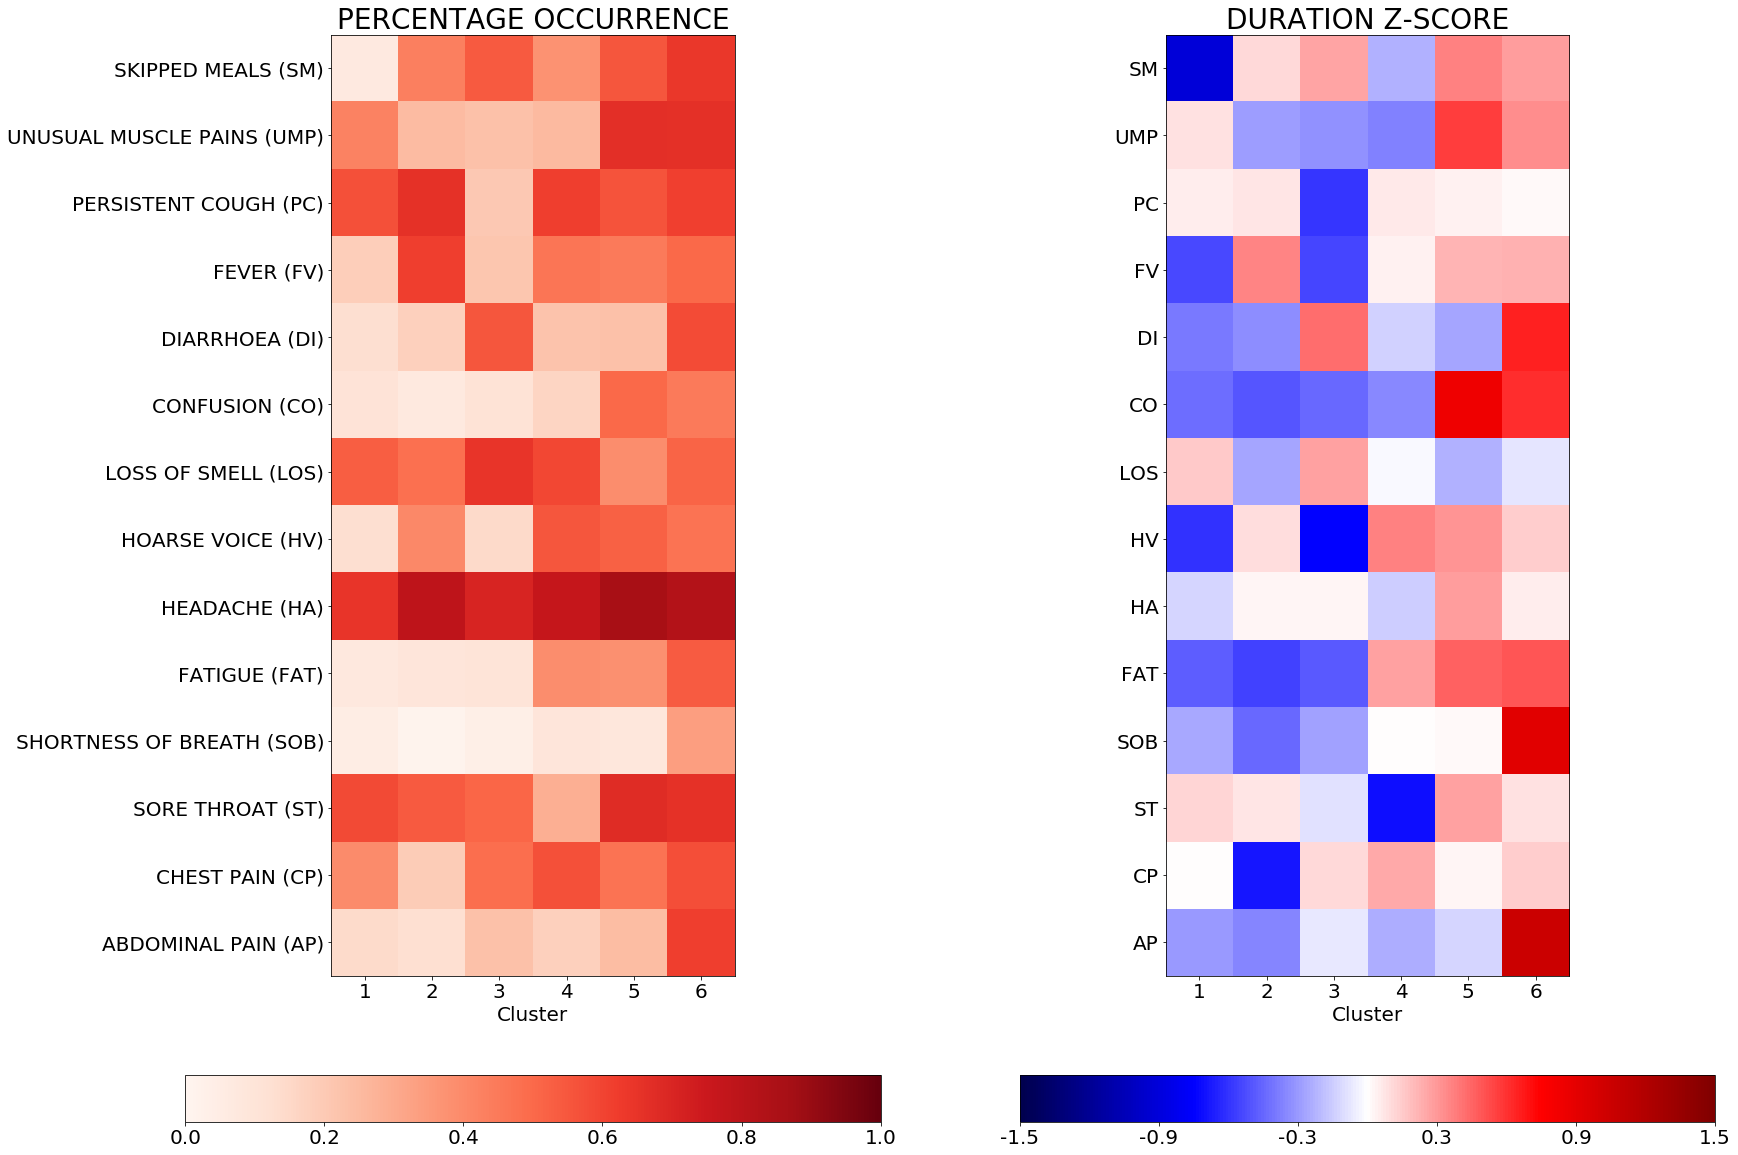

In [234]:
list_SE = ['ABDOMINAL PAIN','CHEST PAIN','SORE THROAT', 'SHORTNESS OF BREATH','FATIGUE','HEADACHE','HOARSE VOICE','LOSS OF SMELL',
          'CONFUSION','DIARRHOEA','FEVER','PERSISTENT COUGH','UNUSUAL MUSCLE PAINS','SKIPPED MEALS']


list_startrat=[c for c in df_unique3.columns if 'z_sum5_' in c]
list_sumrat=[c for c in df_unique3.columns if 'z_nsum5' in c]
list_ever=[c for c in df_unique3.columns if 'ever5_' in c]
vmin = -1.5
vmax= 1.5
clust_column = 'clust6'
fig=plt.figure(figsize=(25,20))
from matplotlib import gridspec
import matplotlib as mpl
gs = gridspec.GridSpec(2, 3, width_ratios=[1,0.2,1], height_ratios=[1,0.05])
gs.update(left=0.1, right=0.95, wspace=0, hspace=0.2)


axl=plt.subplot( gs[0,0] ) 
axl.imshow(df_unique3.groupby(clust_column)[list_ever].mean().T,cmap='Reds',vmin=0,vmax=1)
axl.set_yticks(np.arange(0,len(list_startrat)))
axl.set_yticklabels(labels=list_SEA,fontsize=20)
axl.set_xticks(np.arange(0,6))
axl.set_xticklabels(np.arange(1,7),fontsize=20)
axl.set_title('PERCENTAGE OCCURRENCE', fontsize=28)
axl.set_ylim([-0.5,13.5])
axl.set_xlabel('Cluster',fontsize=20)

# axm=plt.subplot( gs[0,1])
# axm.imshow(df_unique3.groupby(clust_column)[list_startrat].mean().T,cmap='Reds',vmin=0,vmax=5)
# # axm.set_yticks(np.arange(-0.5,len(list_startrat)))
# # axm.set_yticklabels(labels=list_S)
# axm.set_yticks(np.arange(0,len(list_startrat)))
# axm.set_xticks(np.arange(0,5))
# axm.set_xticklabels(np.arange(1,6),fontsize=20)
# axm.set_title('ONSET RATIO', fontsize=28)
# axm.set_yticklabels(list_S,fontsize=20)
# axm.set_ylim([-0.5,13.5])

axr=plt.subplot( gs[0,2] )
axr.imshow(df_unique3.groupby(clust_column)[list_sumrat].mean().T,cmap='seismic',vmin=vmin,vmax=vmax)
# axr.set_yticks(np.arange(-0.5,len(list_startrat)))
# axr.set_yticklabels(labels=list_S)
axr.set_xticks(np.arange(0,6))
axr.set_xticklabels(np.arange(1,7),fontsize=20)
axr.set_yticklabels(list_S,fontsize=20)
axr.set_yticks(np.arange(0,len(list_startrat)))
axr.set_title('DURATION Z-SCORE', fontsize=28)
axr.set_ylim([-0.5,13.5])
axr.set_xlabel('Cluster',fontsize=20)
# plt.setp(axm.get_yticklabels(), visible=False)
# plt.setp(axr.get_yticklabels(), visible=False)

axc=plt.subplot(gs[1,0]  )
# fig.suptitle(title, fontsize = 44)
cmap_chosen = mpl.cm.get_cmap('Reds')
cb1 = matplotlib.colorbar.ColorbarBase(axc, cmap=cmap_chosen, orientation='horizontal')
cb1.ax.set_xticklabels(np.round(np.arange(0,1+0.1,0.2),2), fontsize=20)

axc2=plt.subplot(gs[1,2]  )
# fig.suptitle(title, fontsize = 44)
cmap_chosen2 = mpl.cm.get_cmap('seismic')
cb12 = matplotlib.colorbar.ColorbarBase(axc2, cmap=cmap_chosen2, orientation='horizontal')
cb12.ax.set_xticklabels(np.round(np.arange(vmin,vmax+0.1,(vmax-vmin)/5),2), fontsize=20)
plt.savefig('PercDurFig.pdf')

In [235]:
df_unique3.hosp_bin.sum()

383.0

In [ ]:
df_unique3.groupby(['clust6',''])

In [217]:
formula = 'treatment_bin ~ bmi_clean + age + C(has_lung_disease) + C(gender) + C(has_diabetes) + C(has_heart_disease) + C(has_kidney_disease) + C(prisma_bin)'
formula_b = 'treatment_bin ~ bmi_clean + age + C(has_lung_disease) + C(gender) + C(has_diabetes) + C(prisma_bin) '

from statsmodels.formula.api import logit, mnlogit
def logit_formula(df, formula):
    test_logit = logit(formula=formula, data=df)
    res_logit = test_logit.fit()
    res_logit.summary()
    print(res_logit.summary())
    return res_logit
                     

In [234]:
df_unique3.groupby('clust5')['gender'].mean()

clust5
0    0.157895
1    0.284165
2    0.222222
3    0.248756
4    0.161074
Name: gender, dtype: float64

In [130]:
df_utest.groupby('learnt_clust')['gender'].mean()

learnt_clust
0    0.287879
1    0.298643
2    0.321839
3    0.243902
4    0.238095
Name: gender, dtype: float64

0.227168073676132

In [271]:
list_test = list(df_utest['patient_id'])
list_train = list(df_unique['patient_id'])
list_inter = [c for c in list_test if c in list_train]
len(list_inter)

17

In [238]:
list(set(df_unique['has_diabetes']))

[False, True, -1]

In [254]:
df_unique[df_unique['max_duration2']>5].shape

(752, 1319)

In [255]:
df_unique.groupby('clust5')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
clust5,,,,,,,,
0,285.0,42.596491,11.444077,22.0,33.0,43.0,52.0,69.0
1,461.0,40.722343,11.436446,19.0,31.0,40.0,49.0,76.0
2,207.0,42.995169,12.285637,22.0,33.0,43.0,53.0,71.0
3,201.0,43.407960,12.812601,20.0,34.0,43.0,52.0,92.0
4,149.0,44.557047,13.085675,22.0,33.0,46.0,53.0,81.0


In [260]:
df_utest['age'] = 2020 - df_utest['year_of_birth']
df_utest.groupby('learnt_clust')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,132.0,45.522727,13.464381,18.0,34.0,45.0,54.25,86.0
1,221.0,40.954751,12.901294,19.0,30.0,40.0,52.00,77.0
2,87.0,43.137931,13.465868,17.0,33.5,42.0,53.00,76.0
3,82.0,42.853659,13.447770,20.0,32.0,44.0,50.00,89.0
4,84.0,44.595238,13.370638,18.0,35.0,42.0,56.00,75.0


In [302]:
df_utest.groupby('learnt_clust')['gender'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,134.0,0.261194,0.489424,0.0,0.0,0.0,0.00,3.0
1,241.0,0.298755,0.458665,0.0,0.0,0.0,1.00,1.0
2,92.0,0.250000,0.435385,0.0,0.0,0.0,0.25,1.0
3,84.0,0.297619,0.459957,0.0,0.0,0.0,1.00,1.0
4,38.0,0.368421,0.488852,0.0,0.0,0.0,1.00,1.0


In [301]:
df_utest = prisma_score_encoding(df_utest)
df_utest['treatment_bin'] = np.where(df_utest['treatment_max']>2,1,0)
df_utest.groupby('learnt_clust')[['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin','hosp_bin','treatment_bin']].mean()

,has_diabetes,has_lung_disease,has_heart_disease,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin
learnt_clust,,,,,,,
0,0.037313,0.156716,0.022388,0.000000,0.007463,0.350746,0.059701
1,0.024896,0.124481,0.012448,0.000000,0.008299,0.427386,0.045643
2,0.043478,0.195652,0.043478,0.000000,0.021739,0.445652,0.195652
3,0.023810,0.119048,0.011905,0.023810,0.011905,0.500000,0.083333
4,0.078947,0.236842,0.131579,0.026316,0.105263,0.657895,0.184211


In [267]:
df_unique.groupby('clust5')[['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','prisma_bin','hosp_bin','treatment_bin']].mean()

,has_diabetes,has_lung_disease,has_heart_disease,has_kidney_disease,prisma_bin,hosp_bin,treatment_bin
clust5,,,,,,,
0,0.024561,0.143860,0.024561,0.007018,0.000000,0.171930,0.031579
1,0.021692,0.130152,0.013015,0.004338,0.002169,0.188720,0.034707
2,0.048544,0.116505,0.024272,0.004854,0.009662,0.285024,0.106280
3,0.039801,0.208955,0.029851,0.019900,0.029851,0.383085,0.159204
4,0.033557,0.255034,0.020134,0.013423,0.033557,0.409396,0.167785


In [262]:
df_unique.groupby('clust5')['gender'].describe()

,count,mean,std,min,25%,50%,75%,max
clust5,,,,,,,,
0,285.0,0.157895,0.365284,0.0,0.0,0.0,0.0,1.0
1,461.0,0.284165,0.456295,0.0,0.0,0.0,1.0,2.0
2,207.0,0.222222,0.416748,0.0,0.0,0.0,0.0,1.0
3,201.0,0.248756,0.433372,0.0,0.0,0.0,0.0,1.0
4,149.0,0.161074,0.368839,0.0,0.0,0.0,0.0,1.0


In [268]:
df_unique.groupby('clust5')['bmi_clean'].describe()

,count,mean,std,min,25%,50%,75%,max
clust5,,,,,,,,
0,285.0,27.442829,5.884702,18.343233,22.794165,26.074581,30.896585,48.959393
1,461.0,27.120726,6.140619,16.301646,22.813871,25.747154,30.119376,51.837604
2,207.0,28.650935,6.475314,19.076962,23.881496,27.277843,31.322964,50.480504
3,201.0,28.475134,6.590422,16.307874,23.962590,27.251949,32.603292,51.494309
4,149.0,28.537078,5.964535,18.399878,24.193598,27.336150,32.024857,49.711950


In [270]:
df_utest = salvaging_bmi(df_utest)
df_utest.groupby('learnt_clust')['bmi_clean'].describe()

,count,mean,std,min,25%,50%,75%,max
learnt_clust,,,,,,,,
0,132.0,28.191282,5.514941,18.745313,23.798359,27.434488,32.197249,43.161147
1,221.0,26.542044,5.580865,18.537952,22.853594,25.106333,29.286669,49.922060
2,87.0,28.056399,5.841350,19.206890,24.063913,27.095330,30.695291,43.746516
3,82.0,27.258260,4.896546,18.990905,23.323559,26.227752,31.032001,39.937648
4,84.0,29.771560,6.348797,19.420930,24.949539,28.823034,33.858995,53.772708


In [272]:
df_test_fin = df_test3[~df_test3['patient_id'].isin(list_inter)]

In [274]:
df_test_fin.to_csv('FinalTestSet_ClusterWork.csv')
df_train.to_csv('FinalTrainSet_ClusterWork')

In [218]:
df_unique3 = df_unique
for f in ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease']:
    df_unique3[f] = df_unique3[f].replace(-1,np.nan)
    df_unique3[f] = df_unique3[f].astype(float)
df_unique3['gender'] = df_unique3['gender'].replace(2,0)
logit_formula(df_unique3, formula)

Optimization terminated successfully.
         Current function value: 0.212273
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                 1653
Model:                          Logit   Df Residuals:                     1644
Method:                           MLE   Df Model:                            8
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.1148
Time:                        12:57:10   Log-Likelihood:                -350.89
converged:                       True   LL-Null:                       -396.37
Covariance Type:            nonrobust   LLR p-value:                 2.948e-16
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -6.0741      0.638     -9.515      0.000

In [219]:
df_unique3 = df_unique
for f in ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease']:
    df_unique3[f] = df_unique3[f].replace(-1,np.nan)
    df_unique3[f] = df_unique3[f].astype(float)
df_unique3['gender'] = df_unique3['gender'].replace(2,0)
logit_formula(df_utest2, formula)

         Current function value: 0.186316
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1037
Method:                           MLE   Df Model:                            9
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.1406
Time:                        12:58:38   Log-Likelihood:                -195.07
converged:                      False   LL-Null:                       -227.00
Covariance Type:            nonrobust   LLR p-value:                 2.412e-10
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -5.1109      0.885     -5.773      0.000      -6.846      -3.376
C(has_lung_

/mnt/data/csudre/.local/lib/python3.5/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [220]:
logit_formula(df_unique3[df_unique3['clust6']==0], formula)

         Current function value: 0.061441
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  462
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            7
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.2175
Time:                        12:59:58   Log-Likelihood:                -28.386
converged:                      False   LL-Null:                       -36.274
Covariance Type:            nonrobust   LLR p-value:                   0.02723
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -11.7324      3.014     -3.893      0.000     -17.639      -5.826
C(has_lung_

/mnt/data/csudre/.local/lib/python3.5/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [221]:
logit_formula(df_unique3[df_unique3['clust6']==1], formula)

         Current function value: 0.162832
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  315
Model:                          Logit   Df Residuals:                      306
Method:                           MLE   Df Model:                            8
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.1044
Time:                        13:00:19   Log-Likelihood:                -51.292
converged:                      False   LL-Null:                       -57.273
Covariance Type:            nonrobust   LLR p-value:                    0.1529
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -8.3540      1.891     -4.418      0.000     -12.060      -4.648
C(has_lung_

/mnt/data/csudre/.local/lib/python3.5/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [222]:
logit_formula(df_unique3[df_unique3['clust6']==2], formula)

         Current function value: 0.150287
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  216
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                            7
Date:                Sat, 30 May 2020   Pseudo R-squ.:                 0.05128
Time:                        13:00:37   Log-Likelihood:                -32.462
converged:                      False   LL-Null:                       -34.217
Covariance Type:            nonrobust   LLR p-value:                    0.8342
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.7330      2.122     -0.817      0.414      -5.892       2.426
C(has_lung_

/mnt/data/csudre/.local/lib/python3.5/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [223]:
logit_formula(df_unique3[df_unique3['clust6']==3], formula_b)

Optimization terminated successfully.
         Current function value: 0.282854
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  280
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 May 2020   Pseudo R-squ.:                 0.03300
Time:                        13:01:13   Log-Likelihood:                -79.199
converged:                       True   LL-Null:                       -81.902
Covariance Type:            nonrobust   LLR p-value:                    0.3683
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.0179      1.328     -3.027      0.002      

In [224]:
logit_formula(df_unique3[df_unique3['clust6']==4], formula_b)

Optimization terminated successfully.
         Current function value: 0.273424
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  213
Model:                          Logit   Df Residuals:                      206
Method:                           MLE   Df Model:                            6
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.1508
Time:                        13:01:40   Log-Likelihood:                -58.239
converged:                       True   LL-Null:                       -68.581
Covariance Type:            nonrobust   LLR p-value:                  0.002091
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.2506      1.460     -3.597      0.000      

In [225]:
logit_formula(df_unique3[df_unique3['clust6']==5], formula_b)

Optimization terminated successfully.
         Current function value: 0.384287
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                  167
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                            6
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.2269
Time:                        13:02:01   Log-Likelihood:                -64.176
converged:                       True   LL-Null:                       -83.010
Covariance Type:            nonrobust   LLR p-value:                 1.305e-06
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.0814      1.556     -3.909      0.000      

In [236]:
df_tot['gender'] =df_tot['gender'].replace(2,0)
logit_formula(df_tot,formula)

Optimization terminated successfully.
         Current function value: 0.205651
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          treatment_bin   No. Observations:                 2700
Model:                          Logit   Df Residuals:                     2691
Method:                           MLE   Df Model:                            8
Date:                Sat, 30 May 2020   Pseudo R-squ.:                  0.1098
Time:                        14:31:30   Log-Likelihood:                -555.26
converged:                       True   LL-Null:                       -623.77
Covariance Type:            nonrobust   LLR p-value:                 9.900e-26
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -5.5869      0.504    -11.079      0.000

In [228]:
df_tot = pd.concat([df_unique3,df_utest2])
df_preg = df_tot[df_tot['is_pregnant']==True]
df_preg[['age','bmi_clean','clust6','learnt_clust','hosp_bin','treatment_bin','country_code_x','sum_symp']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,age,bmi_clean,clust6,learnt_clust,hosp_bin,treatment_bin,country_code_x,sum_symp
"(b576e1fdd18a1c77bcca357541f3b3fa, 18)",34.0,34.436104,0.0,NaN,1.0,1,GB,12.0
"(60268c60e6e283ca07d836aa7c9cc1ff, 2)",30.0,31.754826,1.0,NaN,0.0,0,GB,6.0
"(5e0a840a0bbb9acfab8645b5c0cc5a06, 3)",35.0,20.112497,0.0,NaN,0.0,0,GB,2.0
10935,35.0,31.313184,NaN,0.0,1.0,0,GB,9.0
1742,32.0,36.753650,NaN,3.0,1.0,0,SE,7.0
5013,38.0,25.826446,NaN,0.0,1.0,0,SE,6.0
990,28.0,26.090451,NaN,1.0,1.0,0,GB,4.0
9740,37.0,27.208260,NaN,2.0,0.0,0,GB,3.0
64,39.0,21.971336,NaN,0.0,0.0,0,SE,2.0


In [24]:
df_unique3['ever_smoked'] = 0
df_unique3['ever_smoked'] = np.where(df_unique3['smoker_status'].isin(['not_currently','yes']),1,df_unique3['ever_smoked'])
df_unique3['ever_smoked'] = np.where(np.nan_to_num(df_unique3['is_smoker'].astype(float))==1,1,df_unique3['ever_smoked'])
df_unique3['smo_bin'] = 0
df_unique3['smo_bin'] = np.where(np.logical_or(df_unique3['smoker_status']=='yes',np.nan_to_num(df_unique3['is_smoker'].astype(float))),1,0)

df_unique3.groupby(['clust6_new','country_code_y']).size().unstack()

country_code_y,GB,US
clust6_new,,
1,336,4
2,276,10
3,141,1
4,148,4
5,130,3
6,141,4


In [25]:
for f in list_symptoms:
    df_unique3['sum_'+f] = df_unique3['sum_'+f].replace(0,np.nan)
test_round = np.round(df_unique3.groupby('clust6_new')[list_sum].mean(),1)
test_round

,sum_abdominal_pain,sum_chest_pain,sum_sore_throat,sum_sob2,sum_fatigue2,sum_headache,sum_hoarse_voice,sum_loss_of_smell,sum_delirium,sum_diarrhoea,sum_fever,sum_persistent_cough,sum_unusual_muscle_pains,sum_skipped_meals
clust6_new,,,,,,,,,,,,,,
1,2.0,4.7,4.7,1.5,1.6,4.9,1.9,5.8,2.9,2.0,3.6,6.4,2.2,2.3
2,2.5,2.5,4.7,1.9,2.2,4.5,4.9,7.9,4.2,1.9,2.0,5.8,2.7,4.7
3,5.8,6.1,4.7,2.1,2.0,5.2,5.5,6.3,4.2,6.2,4.5,5.7,3.7,5.5
4,3.3,4.0,2.9,2.4,2.9,4.9,2.8,5.3,3.7,5.4,4.9,7.4,2.5,6.0
5,2.0,5.9,2.3,2.5,3.1,5.8,3.3,4.8,3.6,2.5,4.4,6.2,4.1,4.8
6,5.1,6.7,6.1,2.6,2.6,6.4,6.5,5.2,6.2,2.9,5.5,6.8,3.5,5.1


In [71]:
list_end = ['end_'+f for f in list_symptoms]
list_endrat = ['endrat_'+f for f in list_symptoms]
test_round = np.round(df_unique3.groupby('clust6_new')[list_endrat].mean(),1)
test_round

,endrat_abdominal_pain,endrat_chest_pain,endrat_sore_throat,endrat_sob2,endrat_fatigue2,endrat_headache,endrat_hoarse_voice,endrat_loss_of_smell,endrat_delirium,endrat_diarrhoea,endrat_fever,endrat_persistent_cough,endrat_unusual_muscle_pains,endrat_skipped_meals
clust6_new,,,,,,,,,,,,,,
1,0.6,0.8,0.7,1.0,0.9,0.7,0.7,1.0,0.6,0.7,0.7,0.9,0.5,0.8
2,0.8,0.7,0.6,0.9,0.9,0.7,0.8,1.0,0.7,0.7,0.6,0.9,0.5,0.8
3,0.8,0.8,0.7,0.9,0.8,0.7,0.9,1.0,0.8,0.9,0.9,0.9,0.6,0.9
4,0.7,0.8,0.4,0.9,0.9,0.6,0.6,0.9,0.8,0.8,0.8,0.9,0.4,0.9
5,0.6,0.8,0.6,0.9,0.8,0.7,0.8,1.0,0.8,0.6,0.8,0.9,0.7,0.9
6,0.8,0.9,0.7,0.9,0.8,0.8,0.9,0.9,0.9,0.7,0.9,1.0,0.5,0.9


In [82]:

start_rat = np.round(df_unique3.groupby(clust_column)[list_startrat].mean(),1)
end_rat = np.round(df_unique3.groupby(clust_column)[list_endrat].mean(),1)
bin_rat = np.round(df_unique3.groupby(clust_column)[list_ever].mean(),1)
list_path = []
for f in list_symptoms:
    path = np.zeros([6,11])
    for p in range(0,6):
        new_path = np.zeros(11)
        start = int(start_rat.iloc[p]['startrat_'+f]*10)
        end = int(end_rat.iloc[p]['endrat_'+f]*10+2)
#         print(f,start,end,p)
        new_path[start:np.minimum(end,11)] = bin_rat.iloc[p]['ever_'+f]
        path[p,:] = new_path
    list_path.append(path)


In [74]:
start_rat = np.round(df_unique3[df_unique3['hosp_bin']==1].groupby(clust_column)[list_startrat].mean(),1)
end_rat = np.round(df_unique3[df_unique3['hosp_bin']==1].groupby(clust_column)[list_endrat].mean(),1)
bin_rat = np.round(df_unique3[df_unique3['hosp_bin']==1].groupby(clust_column)[list_ever].mean(),1)
list_path = []
for f in list_symptoms:
    path = np.zeros([6,11])
    for p in range(0,6):
        new_path = np.zeros(11)
        start = int(start_rat.iloc[p]['startrat_'+f]*10)
        end = int(end_rat.iloc[p]['endrat_'+f]*10+2)
#         print(f,start,end,p)
        new_path[start:np.minimum(end,11)] = bin_rat.iloc[p]['ever_'+f]
        path[p,:] = new_path
    list_path.append(path)


In [81]:
df_maxsum['treatment_bin'] = np.where(df_maxsum['treatment_coded']>2,1,0)
df_maxsum = allocate_cluster(df_maxsum,classif_dict[6],'clust6_opt')
df_maxsum.groupby(['clust6_opt','treatment_coded']).size().unstack()

treatment_coded,-1.0,0.0,1.0,2.0,3.0,4.0
clust6_opt,,,,,,
0,350.0,5.0,3.0,2.0,8.0,10.0
1,145.0,2.0,2.0,2.0,23.0,7.0
2,210.0,3.0,2.0,5.0,12.0,2.0
3,120.0,NaN,4.0,5.0,30.0,5.0
4,112.0,3.0,4.0,3.0,7.0,3.0
5,81.0,1.0,1.0,5.0,17.0,4.0


[<matplotlib.lines.Line2D object at 0x7fc0b1721b38>, <matplotlib.lines.Line2D object at 0x7fc0b1721d30>, <matplotlib.lines.Line2D object at 0x7fc0b17460b8>, <matplotlib.lines.Line2D object at 0x7fc0b1746400>, <matplotlib.lines.Line2D object at 0x7fc0b1746748>, <matplotlib.lines.Line2D object at 0x7fc0b1746a90>, <matplotlib.lines.Line2D object at 0x7fc0b1746dd8>, <matplotlib.lines.Line2D object at 0x7fc0b1755160>, <matplotlib.lines.Line2D object at 0x7fc0b17554a8>, <matplotlib.lines.Line2D object at 0x7fc0b17557f0>, <matplotlib.lines.Line2D object at 0x7fc0b1755b38>, <matplotlib.lines.Line2D object at 0x7fc0b1755e80>, <matplotlib.lines.Line2D object at 0x7fc0b172d208>, <matplotlib.lines.Line2D object at 0x7fc0b172d550>]


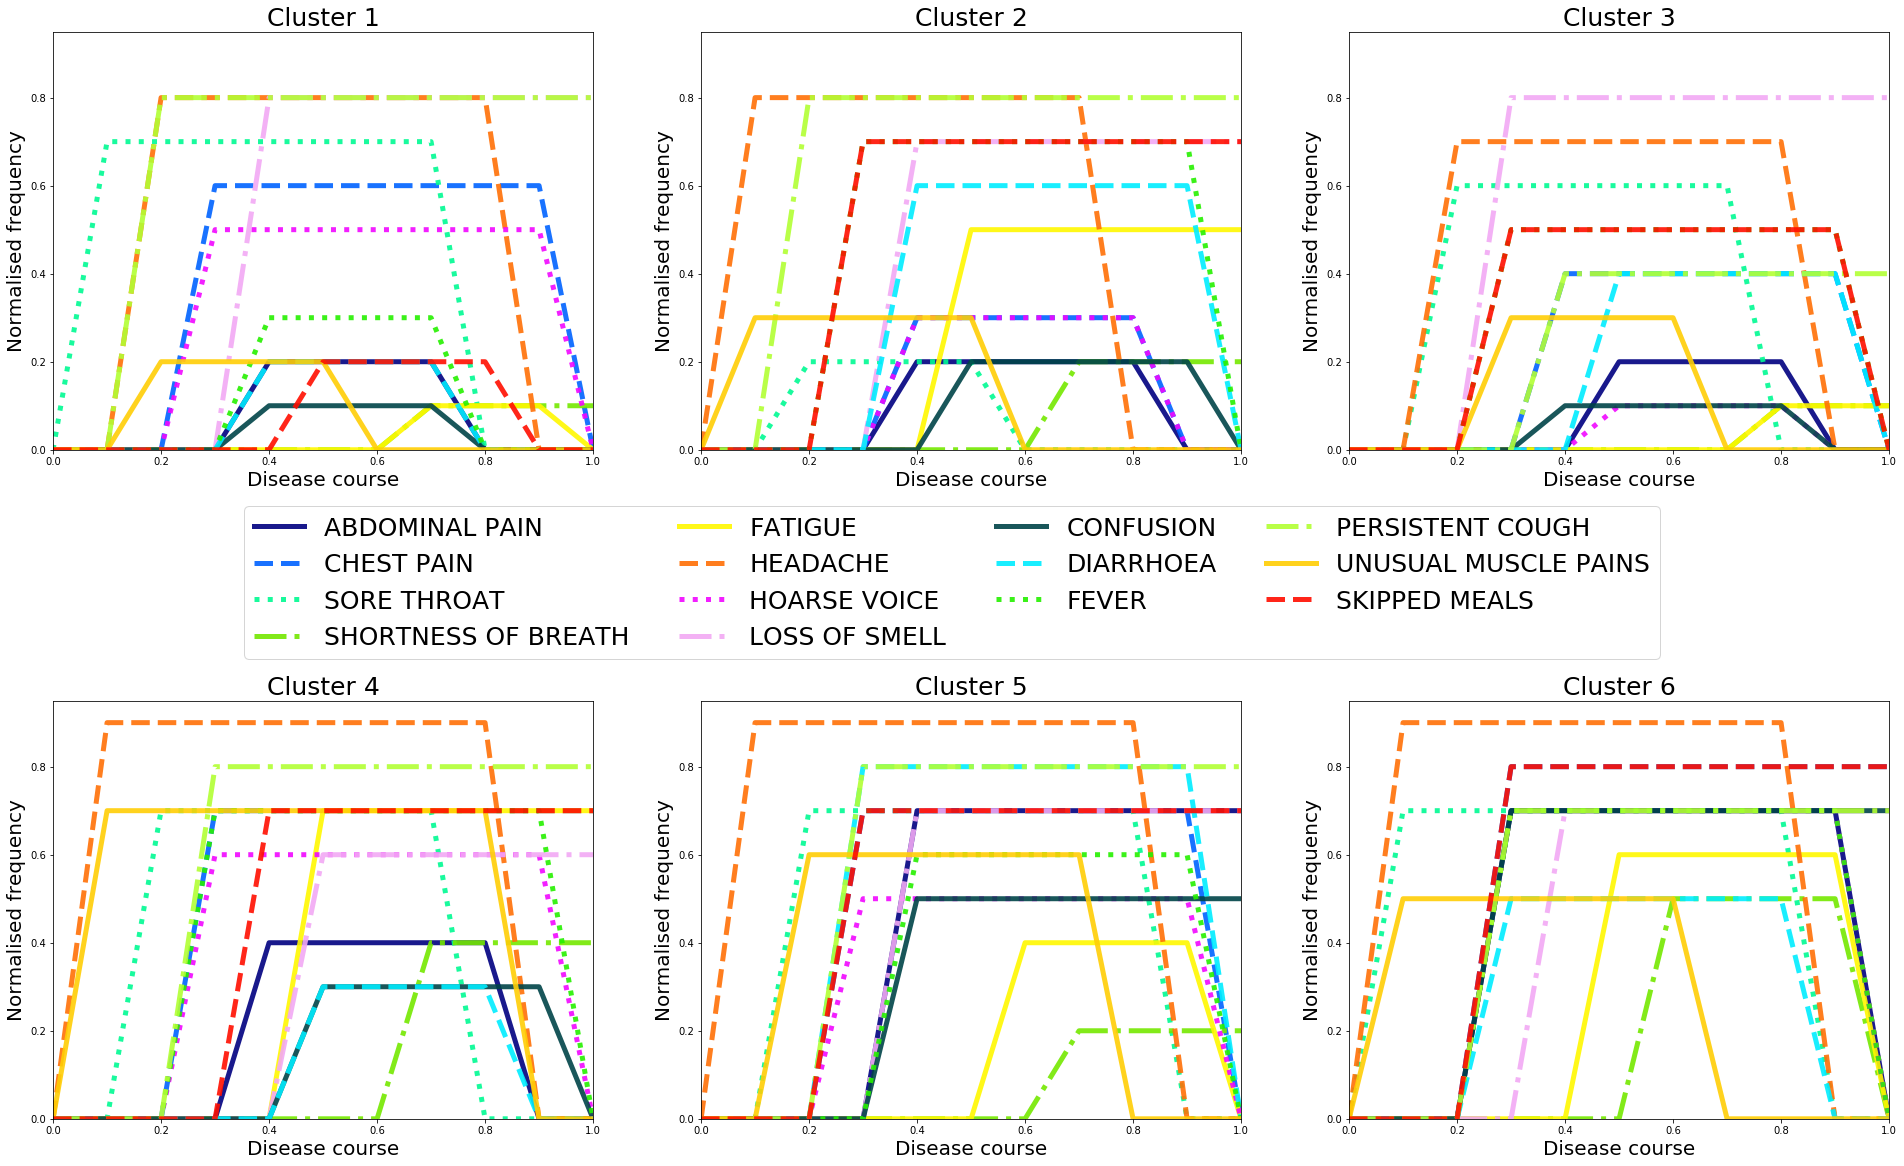

In [83]:
NUM_COLORS = 15

cm = plt.get_cmap('gist_ncar')
list_init = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
# list_cols = list_init[[0,2,4,6,8,10,12,14,1,3,5,7,9,11,13]]
list_idx = [0,2,4,6,8,10,12,14,1,3,5,7,9,11,13]
list_cols = [list_init[i] for i in list_idx]
fig=plt.figure(figsize=(30,20))
from matplotlib import gridspec
import matplotlib as mpl
gs = gridspec.GridSpec(2,3, width_ratios=[1,1,1], height_ratios=[1,1])
gs.update(left=0.1, right=0.95, wspace=0.2, hspace=0.6)


for c in range(0,6):
    list_lines = []
    axh=plt.subplot( gs[int(c/3), int(c%3)] ) 
    axh.set_ylim([0,0.95])
    axh.set_xlim([0,1])
    axh.set_xlabel('Disease course', fontsize=20)
    axh.set_ylabel('Normalised frequency', fontsize=20)
    axh.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    axh.set_prop_cycle(color=list_cols, linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--', ':', '-.','-', '--', ':'])
    for p in range(0,len(list_path)):
#         axh.plot(np.arange(0,list_path[0].shape[1]),list_path[p][c,:],alpha=0.9)
        l_temp = axh.plot(np.arange(0,list_path[0].shape[1]/10,0.1),list_path[p][c,:],alpha=0.9,linewidth=5)[0]
        list_lines.append(l_temp)
    axh.set_title('Cluster %d' %(c+1), fontsize=25)
#     axh.legend(list_S,loc='center left', bbox_to_anchor=(0.5, -0.5))
# handles, labels = axh.get_legend_handles_labels()
print(list_lines)
fig.legend( list(list_lines), list_SE,loc='center',fontsize=25,ncol=4 )


In [85]:
df_unique3.groupby(['clust6_opt','hosp_bin'])['age'].mean().unstack()

hosp_bin,0.0,1.0
clust6_opt,,
0,39.823105,43.960396
1,43.867257,48.220588
2,39.111111,41.944444
3,41.919192,43.553846
4,41.384615,45.740741
5,39.250000,45.701754


In [95]:
df_unique3.groupby(['clust6_opt'])['hosp_bin'].mean()

clust6_opt
0    0.267196
1    0.375691
2    0.384615
3    0.396341
4    0.409091
5    0.522936
Name: hosp_bin, dtype: float64

In [96]:
df_unique3.groupby(['clust6_opt'])['treatment_bin'].mean()

clust6_opt
0    0.047619
1    0.165746
2    0.059829
3    0.213415
4    0.075758
5    0.192661
Name: treatment_bin, dtype: float64

In [30]:
df_unique3 = salvaging_bmi(df_unique3)
df_unique3['treatment_bin'] = np.where(df_unique3['treatment_coded']>2,1,0)
df_unique3.groupby(['clust6_opt','hosp_bin'])['age'].describe()

count       mean        std   min    25%   50%    75%  \
clust6_new hosp_bin                                                          
1          0.0       250.0  39.248000  10.584641  19.0  30.00  38.0  47.00   
           1.0        90.0  44.333333  12.927629  22.0  34.00  44.0  55.00   
2          0.0       192.0  41.151042  12.748189  18.0  29.75  40.0  50.00   
           1.0        94.0  43.329787  13.120933  19.0  32.00  45.0  54.00   
3          0.0        84.0  42.238095  11.575440  22.0  32.00  43.0  52.00   
           1.0        58.0  42.000000  11.493705  23.0  32.00  41.5  49.50   
4          0.0        85.0  43.682353  10.707376  23.0  36.00  45.0  51.00   
           1.0        67.0  46.104478  13.936147  23.0  35.00  45.0  57.00   
5          0.0        73.0  39.575342   9.626234  25.0  32.00  38.0  46.00   
           1.0        60.0  45.433333  11.427541  20.0  38.75  44.0  53.00   
6          0.0        79.0  40.202532  11.561851  21.0  29.00  40.0  48.50   
           1.0        66.0  46.757576  14.130230  23.0  35.25  46.5  55.75   

                      max  
clust6_new hosp_bin        
1          0.0       67.0  
           1.0       75.0  
2          0.0       77.0  
           1.0       72.0  
3          0.0       66.0  
           1.0       69.0  
4          0.0       65.0  
           1.0       76.0  
5          0.0       66.0  
           1.0       82.0  
6          0.0       66.0  
           1.0       81.0

In [97]:
df_unique3.groupby(['clust6_opt'])['has_lung_disease'].mean()

clust6_opt
0    0.137566
1    0.127072
2    0.123932
3    0.219512
4    0.174242
5    0.311927
Name: has_lung_disease, dtype: float64

In [98]:
df_unique3.groupby(['clust6_opt'])['has_heart_disease'].mean()

clust6_opt
0    0.018519
1    0.022099
2    0.017094
3    0.000000
4    0.037879
5    0.036697
Name: has_heart_disease, dtype: float64

In [99]:
df_unique3.groupby(['clust6_opt'])['has_diabetes'].mean()

clust6_opt
0    0.031746
1    0.049724
2    0.008547
3    0.036585
4    0.075758
5    0.036697
Name: has_diabetes, dtype: float64

In [113]:
df_unique3 = salvaging_bmi(df_unique3)
df_unique3['obese_bin'] = np.where(df_unique3['bmi_clean']>30,1,0)
df_unique3.groupby(['clust6_opt','hosp_bin'])['has_diabetes'].mean().unstack()




hosp_bin,0.0,1.0
clust6_opt,,
0,0.025271,0.049505
1,0.026549,0.088235
2,0.000000,0.022222
3,0.040404,0.030769
4,0.051282,0.111111
5,0.000000,0.070175


Text(0, 0.5, 'Cluster')

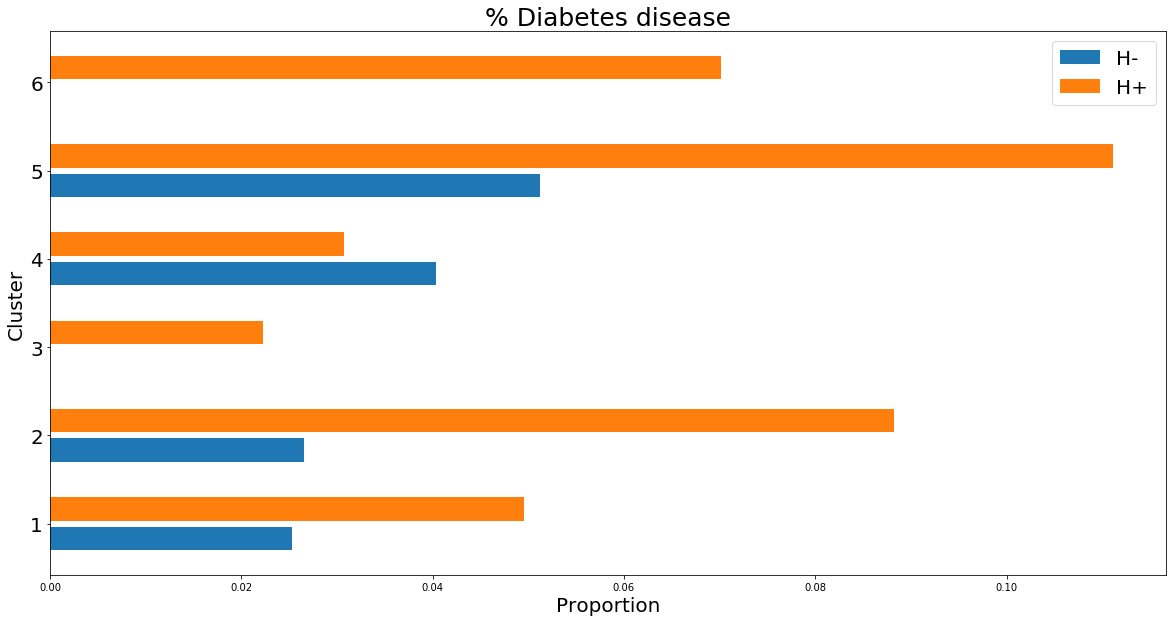

In [112]:
fig = plt.figure(figsize=(20,10))
max_dura = df_unique3.groupby(['clust6_opt','hosp_bin'])['has_diabetes'].mean().unstack()
plt.barh(np.arange(0,18,3),np.asarray(max_dura)[:,0].T)
plt.barh(np.arange(0,18,3)+1,np.asarray(max_dura)[:,1].T)
plt.yticks(np.arange(0.5,18,3),labels=['1','2','3','4','5','6'],fontsize=20)
plt.legend(['H-','H+'],fontsize=20)
plt.title('% Diabetes disease',fontsize=25)
plt.xlabel('Proportion',fontsize=20)
plt.ylabel('Cluster',fontsize=20)

In [123]:
list_have_worked = [c for c in df_unique3.columns if 'have_worked' in c or 'contact_health' in c]
list_have_worked
def hcw_encoding(df):
    df['hcw'] = 0
    for f in list_have_worked:
        df['hcw'] = np.where(np.nan_to_num(df[f].astype(float))==1,1,df['hcw'])
    return df

df_unique3 = hcw_encoding(df_unique3)

df_unique3.groupby(['clust6_opt','hosp_bin'])['hcw'].mean().unstack()

hosp_bin,0.0,1.0
clust6_opt,,
0,0.379061,0.089109
1,0.415929,0.117647
2,0.375000,0.177778
3,0.404040,0.169231
4,0.320513,0.166667
5,0.461538,0.087719


In [115]:
df_unique3.groupby('clust6_opt')['hosp_bin'].mean()

clust6_opt
0    0.267196
1    0.375691
2    0.384615
3    0.396341
4    0.409091
5    0.522936
Name: hosp_bin, dtype: float64

In [161]:
fi,rank = aggregate_features_importance(models_clust)

(100, 20)


In [162]:
fi,rank = aggregate_features_importance(models_clust)
for (f,i,r) in zip(features,fi,rank):
    print(f,i,r)
# print(features, np.argsort(rank))
ord_features = [features[r] for r in np.argsort(rank)]
print(ord_features)

age 0.10348914801134404 0.91
bmi 0.10424507315379657 0.8
gender 0.015327413113895141 16.03
has_lung_disease 0.012346671723777937 16.97
has_heart_disease 0.0036362460666623914 18.87
has_diabetes 0.0050568293736514315 18.13
startrat_abdominal_pain 0.03830411948800674 13.7
startrat_chest_pain 0.05280901080798805 7.81
startrat_sore_throat 0.05019394974486166 9.12
startrat_headache 0.057396707859673955 5.88
startrat_hoarse_voice 0.042950853629163725 12.22
startrat_loss_of_smell 0.10024378487321745 1.29
startrat_delirium 0.06260502875101392 4.73
startrat_diarrhoea 0.04533223042433972 11.24
startrat_fever 0.05161913181975288 8.45
startrat_persistent_cough 0.057360769410632624 5.76
startrat_unusual_muscle_pains 0.034012251944714585 14.84
startrat_skipped_meals 0.05468192534735443 7.01
startrat_fatigue2 0.042650546046909134 12.4
startrat_sob2 0.06573830840924366 3.84
['bmi', 'age', 'startrat_loss_of_smell', 'startrat_sob2', 'startrat_delirium', 'startrat_persistent_cough', 'startrat_headache', 

In [166]:
fi,rank = aggregate_features_importance(models_treat)
for (f,i,r) in zip(features,fi,rank):
    print(f,i,r)
# print(features, np.argsort(rank))
ord_features = [features[r] for r in np.argsort(rank)]
print(ord_features)

(100, 21)
age 0.09381321559907267 1.7
bmi 0.08232355884562886 2.79
gender 0.011948789999464658 17.87
has_lung_disease 0.015340069493076766 17.26
has_heart_disease 0.0036114073233193024 19.9
has_diabetes 0.007892395738830636 18.75
startrat_abdominal_pain 0.030195075655430687 13.17
startrat_chest_pain 0.03524316364140097 11.01
startrat_sore_throat 0.030193563752426905 13.18
startrat_headache 0.03897999070345392 9.68
startrat_hoarse_voice 0.029848905716142165 13.38
startrat_loss_of_smell 0.0780858134408785 3.33
startrat_delirium 0.04187447957693051 8.91
startrat_diarrhoea 0.034626709785427694 11.32
startrat_fever 0.04032922668752794 9.14
startrat_persistent_cough 0.04081551184012138 8.91
startrat_unusual_muscle_pains 0.026279722015811417 14.68
startrat_skipped_meals 0.04829348587002778 7.25
startrat_fatigue2 0.06804371986394538 4.34
startrat_sob2 0.16720354142378258 0.02
max_duration 0.07505765302729922 3.41
['startrat_sob2', 'age', 'bmi', 'startrat_loss_of_smell', 'max_duration', 'startr

In [173]:
fi,rank = aggregate_features_importance(models_ever)
for (f,i,r) in zip(features,fi,rank):
    print(f,i,r)
# print(features, np.argsort(rank))
ord_features = [features[r] for r in np.argsort(rank)]
print(ord_features)

(100, 21)
age 0.1463937693432466 1.68
bmi 0.15049788056390015 1.32
gender 0.024248307125736727 15.3
has_lung_disease 0.019575482324203607 17.9
has_heart_disease 0.005368810717301339 19.97
has_diabetes 0.008862309757969858 19.03
ever_abdominal_pain 0.02612551044356984 13.11
ever_chest_pain 0.026240488196864867 13.03
ever_sore_throat 0.027504004231306278 10.74
ever_headache 0.02233345670303482 16.76
ever_hoarse_voice 0.028673550782047374 8.84
ever_loss_of_smell 0.028263405369887334 9.41
ever_delirium 0.05505937550338336 3.61
ever_diarrhoea 0.02838090708852705 9.27
ever_fever 0.030563654875935112 6.66
ever_persistent_cough 0.028733208204080065 8.86
ever_unusual_muscle_pains 0.027234370589949167 11.32
ever_skipped_meals 0.029101041857850594 8.45
ever_fatigue2 0.027193793780264635 11.35
ever_sob2 0.058917523679957506 3.39
max_duration 0.20072914886098359 0.0
['max_duration', 'bmi', 'age', 'ever_sob2', 'ever_delirium', 'ever_fever', 'ever_skipped_meals', 'ever_hoarse_voice', 'ever_persistent

In [43]:
from sklearn.metrics import roc_auc_score
labels = 'hosp_bin'

df_max_pos = df_maxsum[df_maxsum['hosp_bin']==1]
df_max_neg = df_maxsum[df_maxsum['hosp_bin']==0]
features = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_startrat + ['max_duration'] + ['clust6_opt']
features = ['max_duration','clust6_new', 'age','gender','has_lung_disease','has_heart_disease','has_diabetes'] +list_startrat
models_clust, tp_clust, tn_clust, fp_clust, fn_clust, predict_clust, roc, lab = test_model_balancing(df_max_pos, df_max_neg, features, labels, num_iter=100, random_seed=33,const_needed=False )
print(np.mean((np.asarray(tp_clust)+np.asarray(tn_clust))/len(predict_clust[0])), np.mean(roc))

0.7771832474567314 87.0 (174, 2)
0.7892059717267803 87.0 (174, 2)
0.8447615272823359 87.0 (174, 2)
0.7095389087065662 87.0 (174, 2)
0.7773814242304135 87.0 (174, 2)
0.8219051393843309 87.0 (174, 2)
0.7552516845025763 87.0 (174, 2)
0.8236226714229092 87.0 (174, 2)
0.7494384991412341 87.0 (174, 2)
0.7991808693354473 87.0 (174, 2)
0.7800237812128418 87.0 (174, 2)
0.7449464922711059 87.0 (174, 2)
0.8123265953230282 87.0 (174, 2)
0.7999075175056152 87.0 (174, 2)
0.7681992337164751 87.0 (174, 2)
0.796274276654776 87.0 (174, 2)
0.7841194345356058 87.0 (174, 2)
0.7899986788215089 87.0 (174, 2)
0.7869599682917162 87.0 (174, 2)
0.8367683974104901 87.0 (174, 2)
0.7111243228960232 87.0 (174, 2)
0.766415642753336 87.0 (174, 2)
0.7923768001056944 87.0 (174, 2)
0.772493063812921 87.0 (174, 2)
0.7822037257233453 87.0 (174, 2)
0.8380235169771436 87.0 (174, 2)
0.8058528207160788 87.0 (174, 2)
0.7905271502179945 87.0 (174, 2)
0.8269916765755053 87.0 (174, 2)
0.7933016250495442 87.0 (174, 2)
0.84601664684

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
clf = RF(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', \
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,\
                             bootstrap=True, oob_score=False, random_state=33,\
                             verbose=0, warm_start=False, class_weight='balanced')
list_diseases = ['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease']
df_maxsum_clustproj = salvaging_bmi(df_maxsum_clustproj)
df_maxsum_clustproj['treatment_bin'] = np.where(df_maxsum_clustproj['treatment_coded']>2,1,0)
X = df_maxsum_clustproj[list_start8+['sum8_symp','clusttest8','age','bmi_clean','gender']+list_diseases]
y = df_maxsum_clustproj['hosp_bin']
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc_ovo_weighted')
print(scores)

[0.56524679 0.59965442 0.63965893 0.72466727 0.69392771]


In [130]:
import pandas as pd
import numpy as np
# from joblib import load
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score,f1_score, roc_curve

import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


criterion = ["gini", "entropy"]
n_estimators = [int(x) for x in np.logspace(start = 0, stop = 3, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 8, num = 8)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'criterion':criterion,
              'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)

FEATURES = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + ['clust6_opt']  +['sum8_symp']
TARGET = ['any_treat']
df_maxsum['any_treat'] = np.where(df_maxsum['treatment_coded']>1,1,0)
df_maxsum = salvaging_bmi(df_maxsum)
df_maxsum_clean = df_maxsum[(df_maxsum['bmi_clean']>16) & (df_maxsum['bmi_clean']<55) & (df_maxsum['age']>16) & (df_maxsum['age']<100)]
df_maxsum_clean = df_maxsum_clean.fillna(-1)

scores = cross_val_score(rf_random, 
                         df_maxsum_clean[FEATURES], 
                         df_maxsum_clean[TARGET].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')


In [172]:
rf = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)


In [150]:
list_sum8 = [c for c in df_maxsum.columns if 'sum8' in c]
print(list_sum8)
df_maxsum[FEATURES].head(10)

['sum8_abdominal_pain', 'sum8_chest_pain', 'sum8_sore_throat', 'sum8_sob2', 'sum8_fatigue2', 'sum8_headache', 'sum8_hoarse_voice', 'sum8_loss_of_smell', 'sum8_delirium', 'sum8_diarrhoea', 'sum8_fever', 'sum8_persistent_cough', 'sum8_unusual_muscle_pains', 'sum8_skipped_meals', 'sum8_symp']


,age,bmi_clean,gender,has_lung_disease,has_heart_disease,has_diabetes,start8_abdominal_pain,start8_chest_pain,start8_sore_throat,start8_sob2,...,start8_headache,start8_hoarse_voice,start8_loss_of_smell,start8_delirium,start8_diarrhoea,start8_fever,start8_persistent_cough,start8_unusual_muscle_pains,start8_skipped_meals,clust6_opt
4005,51.0,29.701411,1.0,False,False,False,-1.000000,-1.000000,0.714286,-1.0,...,0.285714,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0
5572,33.0,25.806503,0.0,False,False,False,-1.000000,-1.000000,-1.000000,-1.0,...,0.571429,-1.0,0.571429,-1.0,-1.000000,0.142857,-1.000000,-1.0,-1.000000,2
9769,28.0,20.051568,0.0,False,False,False,-1.000000,-1.000000,-1.000000,-1.0,...,0.285714,-1.0,0.714286,-1.0,0.857143,-1.000000,-1.000000,-1.0,-1.000000,2
2405,48.0,26.605395,0.0,False,False,False,0.714286,0.142857,-1.000000,-1.0,...,0.571429,-1.0,-1.000000,-1.0,0.285714,-1.000000,0.285714,-1.0,0.285714,2
12024,38.0,32.783306,0.0,False,False,False,0.428571,0.285714,-1.000000,-1.0,...,0.142857,1.0,-1.000000,-1.0,-1.000000,-1.000000,0.571429,-1.0,-1.000000,0
9766,30.0,22.136740,0.0,True,False,False,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.0,0.142857,-1.0,-1.000000,-1.000000,0.285714,-1.0,-1.000000,0
5596,44.0,26.892323,0.0,False,False,False,-1.000000,-1.000000,1.000000,-1.0,...,-1.000000,-1.0,1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0
2413,50.0,28.519554,0.0,False,False,False,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.571429,-1.0,0.571429,1
12062,36.0,18.328443,0.0,False,False,False,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,2
9761,31.0,20.571429,0.0,True,False,False,0.142857,-1.000000,-1.000000,-1.0,...,-1.000000,-1.0,1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,2


In [ ]:
df_maxsum['']

In [201]:
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
list_start7 = [c for c in df_maxsum.columns if 'start7_' in c]
list_start6 = [c for c in df_maxsum.columns if 'start6_' in c]
list_start5 = [c for c in df_maxsum.columns if 'start5_' in c]
list_start4 = [c for c in df_maxsum.columns if 'start4_' in c]
list_start3 = [c for c in df_maxsum.columns if 'start3_' in c]

list_mean = [c for c in df_maxsum.columns if 'mean' in c]


FEATURES = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + ['clust6_opt']  +['sum8_symp']
TARGET = ['any_treat']
df_maxsum['any_treat'] = np.where(df_maxsum['treatment_coded']>1,1,0)
df_maxsum = salvaging_bmi(df_maxsum)
df_maxsum_clean = df_maxsum[(df_maxsum['bmi_clean']>16) & (df_maxsum['bmi_clean']<55) & (df_maxsum['age']>16) & (df_maxsum['age']<100)]
df_maxsum_clean = df_maxsum_clean.fillna(-1)

scores = cross_val_score(rf_random, 
                         df_maxsum_clean[FEATURES], 
                         df_maxsum_clean[TARGET].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished


In [ ]:
rf = RandomForestClassifier()
# gkf = GroupShuffleSplit(n_splits=5)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv=5, 
                               verbose=3, 
                               scoring='roc_auc',
                               random_state=33, 
                               n_jobs = -1)


scores = cross_val_score(rf_random, 
                         df_maxsum_clean[FEATURES], 
                         df_maxsum_clean[TARGET].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')
print('Validation - ROC AUC mu={} std={}'.format(np.mean(scores), np.std(scores)))
X_train = df_maxsum_clean[FEATURES]
y_train = df_maxsum_clean[TARGET].values[:,0]
clf = rf_random.fit(X_train, y_train)
X_test.loc[:,'p_predicted_covid'] = clf.predict_proba(X_test.loc[:, FEATURES])[:,1]
    
auc_val = roc_auc_score(y_test, X_test.p_predicted_covid)

In [202]:
print('Validation - ROC AUC mu={} std={}'.format(np.mean(scores), np.std(scores)))

Validation - ROC AUC mu=0.6676199589883801 std=0.07145894817107955


In [197]:
X_train = df_maxsum_clean[FEATURES]
y_train = df_maxsum_clean[TARGET].values[:,0]
clf = rf_random.fit(X_train, y_train)
pd.Series({fea:imp for fea, imp in zip(FEATURES, clf.best_estimator_.feature_importances_)}).sort_values(ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.4s finished


In [198]:
pd.Series({fea:imp for fea, imp in zip(FEATURES, clf.best_estimator_.feature_importances_)}).sort_values(ascending=False)

start8_sob2                    0.172916
age                            0.172000
bmi_clean                      0.110226
start8_abdominal_pain          0.077295
sum8_symp                      0.075928
start8_skipped_meals           0.059286
start8_loss_of_smell           0.052433
start8_persistent_cough        0.045380
start8_hoarse_voice            0.034755
start8_fatigue2                0.033896
start8_fever                   0.031307
clust6_opt                     0.029684
has_lung_disease               0.027329
start8_chest_pain              0.024876
start8_diarrhoea               0.022149
has_diabetes                   0.010242
start8_delirium                0.008922
start8_sore_throat             0.006546
start8_unusual_muscle_pains    0.004829
has_heart_disease              0.000000
gender                         0.000000
start8_headache                0.000000
dtype: float64

In [158]:
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
list_mean = [c for c in df_maxsum.columns if 'mean' in c]


FEATURES = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + ['sum8_symp','clust6_opt']
TARGET = ['treatment_bin']
df_maxsum = salvaging_bmi(df_maxsum)
df_maxsum_clean = df_maxsum[(df_maxsum['bmi_clean']>16) & (df_maxsum['bmi_clean']<55) & (df_maxsum['age']>16) & (df_maxsum['age']<100)]
df_maxsum_clean = df_maxsum_clean.fillna(-1)

scores = cross_val_score(rf_random, 
                         df_maxsum_clean[FEATURES], 
                         df_maxsum_clean[TARGET].values[:,0], 
                         cv=5, 
                         scoring='roc_auc')

print('Validation - ROC AUC mu={} std={}'.format(np.mean(scores), np.std(scores)))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.2s


Validation - ROC AUC mu=0.7805758278402743 std=0.045168294003699705


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished


In [159]:
X_train = df_maxsum_clean[FEATURES]
y_train = df_maxsum_clean[TARGET].values[:,0]
clf = rf_random.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.4s finished


In [160]:
pd.Series({fea:imp for fea, imp in zip(FEATURES, clf.best_estimator_.feature_importances_)}).sort_values(ascending=False)

age                            0.134148
bmi_clean                      0.114644
sum8_symp                      0.109734
start8_sob2                    0.095973
start8_loss_of_smell           0.060534
clust6_opt                     0.047016
start8_fever                   0.046854
start8_fatigue2                0.046461
start8_skipped_meals           0.039932
start8_persistent_cough        0.036319
start8_delirium                0.035669
start8_hoarse_voice            0.034378
start8_diarrhoea               0.030353
has_lung_disease               0.029700
start8_chest_pain              0.026342
start8_abdominal_pain          0.022819
start8_headache                0.020999
gender                         0.017012
start8_sore_throat             0.016116
start8_unusual_muscle_pains    0.015613
has_diabetes                   0.012069
has_heart_disease              0.007314
dtype: float64

In [224]:
from sklearn import metrics
labels = np.zeros(predict_clust[0].shape[0])
labels[0:int(predict_clust[0].shape[0]/2)]=1
list_fpr = []
list_tpr = []
list_auc = []
for p in range(0,100):
    fpr, tpr, thresholds = metrics.roc_curve(labels, predict_clust[p][:,1],drop_intermediate=False)
    auc = metrics.auc(fpr, tpr)
    list_fpr.append(fpr)
    list_tpr.append(tpr)
    list_auc.append(auc)
print(np.mean(list_auc))   

(78,) (78,)
(76,) (76,)
(79,) (79,)
(81,) (81,)
(74,) (74,)
(76,) (76,)
(78,) (78,)
(76,) (76,)
(78,) (78,)
(72,) (72,)
(75,) (75,)
(79,) (79,)
(82,) (82,)
(75,) (75,)
(79,) (79,)
(79,) (79,)
(73,) (73,)
(73,) (73,)
(73,) (73,)
(75,) (75,)
(77,) (77,)
(73,) (73,)
(77,) (77,)
(74,) (74,)
(74,) (74,)
(76,) (76,)
(73,) (73,)
(74,) (74,)
(75,) (75,)
(70,) (70,)
(76,) (76,)
(72,) (72,)
(79,) (79,)
(80,) (80,)
(74,) (74,)
(69,) (69,)
(78,) (78,)
(77,) (77,)
(73,) (73,)
(74,) (74,)
(75,) (75,)
(74,) (74,)
(74,) (74,)
(78,) (78,)
(75,) (75,)
(79,) (79,)
(76,) (76,)
(75,) (75,)
(78,) (78,)
(80,) (80,)
(77,) (77,)
(74,) (74,)
(76,) (76,)
(82,) (82,)
(71,) (71,)
(76,) (76,)
(75,) (75,)
(81,) (81,)
(77,) (77,)
(78,) (78,)
(70,) (70,)
(75,) (75,)
(80,) (80,)
(75,) (75,)
(73,) (73,)
(74,) (74,)
(77,) (77,)
(77,) (77,)
(75,) (75,)
(81,) (81,)
(80,) (80,)
(73,) (73,)
(80,) (80,)
(71,) (71,)
(79,) (79,)
(68,) (68,)
(73,) (73,)
(79,) (79,)
(76,) (76,)
(73,) (73,)
(75,) (75,)
(74,) (74,)
(75,) (75,)
(78,

In [223]:
plt.plot(np.mean(list_fpr,0),np.mean(list_tpr,0))

ValueError: operands could not be broadcast together with shapes (78,) (76,) 

In [34]:



labels = 'hosp_bin'

features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_startrat+ ['max_duration'] + ['clust6_hosp']
models_clust, tp_clust, tn_clust, fp_clust, fn_clust, predict_clust = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_clust)+np.asarray(tn_clust))/len(predict_clust[0]))

435 763


0.6406321839080459

In [225]:


list_start = [c for c in df_maxsum.columns if 'start_' in c]
list_startrat = [c for c in df_maxsum.columns if 'startrat_' in c]
list_sumrat = [c for c in df_maxsum.columns if 'sumrat_' in c]
list_sum = [c for c in df_maxsum.columns if 'sum_' in c]
labels = 'hosp_bin'

features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_startrat +['clust6_hosp']
models_clust, tp_clust, tn_clust, fp_clust, fn_clust, predict_clust = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_clust)+np.asarray(tn_clust))/len(predict_clust[0]))

435 763
Taking care of iteration 1
(174, 2)
Taking care of iteration 2
(174, 2)
Taking care of iteration 3
(174, 2)
Taking care of iteration 4
(174, 2)
Taking care of iteration 5
(174, 2)
Taking care of iteration 6
(174, 2)
Taking care of iteration 7
(174, 2)
Taking care of iteration 8
(174, 2)
Taking care of iteration 9
(174, 2)
Taking care of iteration 10
(174, 2)
Taking care of iteration 11
(174, 2)
Taking care of iteration 12
(174, 2)
Taking care of iteration 13
(174, 2)
Taking care of iteration 14
(174, 2)
Taking care of iteration 15
(174, 2)
Taking care of iteration 16
(174, 2)
Taking care of iteration 17
(174, 2)
Taking care of iteration 18
(174, 2)
Taking care of iteration 19
(174, 2)
Taking care of iteration 20
(174, 2)
Taking care of iteration 21
(174, 2)
Taking care of iteration 22
(174, 2)
Taking care of iteration 23
(174, 2)
Taking care of iteration 24
(174, 2)
Taking care of iteration 25
(174, 2)
Taking care of iteration 26
(174, 2)
Taking care of iteration 27
(174, 2)
Ta

0.688735632183908

In [171]:


features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_ever 
models_ever, tp_ever, tn_ever, fp_ever, fn_ever, predict_ever = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_ever)+np.asarray(tn_ever))/len(predict_ever[0]))

435 763


0.6473563218390807

In [172]:


list_start = [c for c in df_maxsum.columns if 'start_' in c]
list_startrat = [c for c in df_maxsum.columns if 'startrat_' in c]
list_sumrat = [c for c in df_maxsum.columns if 'sumrat_' in c]
list_sum = [c for c in df_maxsum.columns if 'sum_' in c]
labels = 'hosp_bin'

features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_ever +['max_duration']
models_ever, tp_ever, tn_ever, fp_ever, fn_ever, predict_ever = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_ever)+np.asarray(tn_ever))/len(predict_ever[0]))

435 763


0.6949425287356322

In [137]:


list_start = [c for c in df_maxsum.columns if 'start_' in c]
list_startrat = [c for c in df_maxsum.columns if 'startrat_' in c]
list_sumrat = [c for c in df_maxsum.columns if 'sumrat_' in c]
list_sum = [c for c in df_maxsum.columns if 'sum_' in c]
labels = 'hosp_bin'

features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_values
models_u, tp_u, tn_u, fp_u, fn_u, predict_u = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_u)+np.asarray(tn_u))/len(predict_u[0]))

435 763


0.5830459770114942

In [165]:
df_maxsum['treatment_bin'] = np.where(df_maxsum['treatment_coded']>2,1,0)
labels = 'treatment_bin'

features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_startrat + ['max_duration']
models_treat, tp_treat, tn_treat, fp_treat, fn_treat, predict_treat = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_treat)+np.asarray(tn_treat))/len(predict_treat[0]))

128 1070


0.7765384615384616

In [96]:

labels = 'treatment_bin'
df_lrprep = df_maxsum
for f in list_startrat:
    df_lrprep[f] = df_lrprep[f].replace(-1,1.5)
features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_startrat + ['max_duration']
models_t, tp_clust, tn_clust, fp_clust, fn_clust, predict_clust = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=True )
np.mean((np.asarray(tp_clust)+np.asarray(tn_clust))/len(predict_clust[0]))

128 1070
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42313836306351144
            Iterations: 124
            Function evaluations: 130
            Gradient evaluations: 124
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.35567325929648114
            Iterations: 132
            Function evaluations: 138
            Gradient evaluations: 132


/home/csudre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/csudre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.34300873004802224
            Iterations: 134
            Function evaluations: 141
            Gradient evaluations: 134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4631406429884391
            Iterations: 97
            Function evaluations: 104
            Gradient evaluations: 97
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3922722538022943
            Iterations: 111
            Function evaluations: 118
            Gradient evaluations: 111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.373177305122726
            Iterations: 103
            Function evaluations: 109
            Gradient evaluations: 103
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3918561062400813
            Iterations: 111
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32917428629415035
            Iterations: 123
            Function evaluations: 128
            Gradient evaluations: 123
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4073141910925788
            Iterations: 103
            Function evaluations: 110
            Gradient evaluations: 103
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3790488161704959
            Iterations: 138
            Function evaluations: 146
            Gradient evaluations: 138
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.37606818801904013
            Iterations: 113
            Function evaluations: 120
            Gradient evaluations: 113
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38896942644208066
            Iterations: 104
   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4017020212852971
            Iterations: 106
            Function evaluations: 112
            Gradient evaluations: 106
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42329082661876766
            Iterations: 135
            Function evaluations: 143
            Gradient evaluations: 135
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4125788702675189
            Iterations: 105
            Function evaluations: 111
            Gradient evaluations: 105
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3861087983759022
            Iterations: 102
            Function evaluations: 110
            Gradient evaluations: 102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4279020194106879
            Iterations: 128
     

0.7430769230769231

In [171]:
df_maxsum.groupby(['clust6_hosp','hosp_bin'])['prisma_bin'].mean().unstack()

hosp_bin,0.0,1.0
clust6_hosp,,
1,0.000000,0.035714
2,0.015385,0.048780
3,0.005348,0.024390
4,0.023256,0.017857
5,0.026316,0.166667
6,0.000000,0.087719


In [179]:
list_hcw =[c for c in df_maxsum.columns if 'have_worked' in c or 'work' in c]

In [180]:
df_maxsum['hcw'] = 0
for f in list_hcw:
    df_maxsum['hcw'] += np.nan_to_num(df_maxsum[f].astype(float))
df_maxsum['hcw'] = np.where(df_maxsum['hcw']>0,1,0)

In [182]:
df_maxsum.groupby(['clust6_hosp','hosp_bin'])['hcw'].mean().unstack()

hosp_bin,0.0,1.0
clust6_hosp,,
1,0.329897,0.071429
2,0.423077,0.219512
3,0.368984,0.117073
4,0.430233,0.232143
5,0.368421,0.041667
6,0.500000,0.140351


In [188]:
df_maxsum['contact_bin'] = df_maxsum['contact_health_worker'].astype(float)
df_unique3.groupby(['clust6_hosp','hosp_bin'])['ever_smoked'].mean().unstack()

hosp_bin,0.0,1.0
clust6_hosp,,
1,0.082474,0.142857
2,0.061538,0.170732
3,0.072193,0.112195
4,0.081395,0.053571
5,0.184211,0.229167
6,0.131579,0.157895


In [67]:
list_start4 = [c for c in df_maxsum.columns if 'start4_' in c]
list_start5 = [c for c in df_maxsum.columns if 'start5_' in c]
list_start6 = [c for c in df_maxsum.columns if 'start6_' in c]
list_start7 = [c for c in df_maxsum.columns if 'start7_' in c]
labels = 'hosp_bin'
features = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start4 + ['mean4_sum']

models_4, tp_4, tn_4, fp_4, fn_4, predict_4 = test_model_balanced_random(df_maxsum, features, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_4)+np.asarray(tn_4))/len(predict_4[0]))

435 763


0.579367816091954

In [65]:
list_start5 = [c for c in df_maxsum.columns if 'start5_' in c]
list_mean = [c for c in df_maxsum.columns if 'mean' in c]
print(len(list_mean))

390


In [194]:
list_start5 = [c for c in df_maxsum.columns if 'start5_' in c]
list_mean = [c for c in df_maxsum.columns if 'mean' in c]
#print(list_mean)
features5 = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start5 + list_mean[4:5] + ['clust6_hosp']
models_5, tp_5, tn_5, fp_5, fn_5, predict_5 = test_model_balanced_random(df_maxsum, features5, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_5)+np.asarray(tn_5))/len(predict_5[0]))

435 763


0.6021264367816093

In [196]:
list_start6 = [c for c in df_maxsum.columns if 'start6_' in c]
features6 = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start6 + list_mean[5:6] + ['clust6_hosp']
models_6, tp_6, tn_6, fp_6, fn_6, predict_6 = test_model_balanced_random(df_maxsum, features6, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_6)+np.asarray(tn_6))/len(predict_6[0]))


435 763


0.6085632183908046

In [191]:
list_start7 = [c for c in df_maxsum.columns if 'start7_' in c]
features7 = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start7 + list_mean[0:7] + ['clust6_hosp']
models_7, tp_7, tn_7, fp_7, fn_7, predict_7 = test_model_balanced_random(df_maxsum, features7, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_7)+np.asarray(tn_7))/len(predict_7[0]))

435 763


0.6242528735632183

In [202]:
labels='treatment_bin'
df_maxsum['treatment_bin'] = np.where(df_maxsum['treatment_coded']>2,1,0)
list_start7 = [c for c in df_maxsum.columns if 'start7_' in c]
features7 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start7 + list_mean[0:7]
models_7, tp_7, tn_7, fp_7, fn_7, predict_7 = test_model_balanced_random(df_maxsum, features7, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_7)+np.asarray(tn_7))/len(predict_7[0]))

128 1070


0.6609615384615385

In [200]:
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
df_maxsum = salvaging_bmi(df_maxsum)
features8 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + list_mean[7:8] + ['clust6_hosp']
models_8, tp_8, tn_8, fp_8, fn_8, predict_8 = test_model_balanced_random(df_maxsum, features8, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_8)+np.asarray(tn_8))/len(predict_8[0]))

435 763


0.6542528735632182

In [132]:
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
df_maxsum_clustproj = salvaging_bmi(df_maxsum_clustproj)
df_maxsum_clustproj_pos = df_maxsum_clustproj[df_maxsum_clustproj['hosp_bin']==1]
df_maxsum_clustproj_neg = df_maxsum_clustproj[df_maxsum_clustproj['hosp_bin']==0]
labels='hosp_bin'
features8 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','sum8_symp'] + list_start8 + list_mean[7:8]+['clusttest8']
models_8, tp_8, tn_8, fp_8, fn_8, predict_8, roc_8, lab_8 = test_model_balancing(df_maxsum_clustproj_pos,df_maxsum_clustproj_neg, features8, labels, num_iter=100, random_seed=33,const_needed=False )
print(np.mean((np.asarray(tp_8)+np.asarray(tn_8))/len(predict_8[0])),np.mean(roc_8))

0.6386781609195403 0.6985936054961024


In [156]:
df_maxsum.groupby('clust6_new')['has_diabetes','has_lung_disease','has_heart_disease','has_kidney_disease','age','gender','bmi_clean'].mean()

,age,gender,bmi_clean
clust6_new,,,
1,40.594118,0.255882,26.726485
2,41.867133,0.157343,26.649905
3,42.140845,0.197183,28.195070
4,44.750000,0.256579,28.613865
5,42.218045,0.210526,26.658365
6,43.186207,0.275862,28.459335


In [137]:
fi,rank = aggregate_features_importance(models_8)
for (f,i,r) in zip(features8,fi,rank):
    print(f,i,r)
# print(features, np.argsort(rank))
ord_features = [features[r] for r in np.argsort(rank)]
print(ord_features)

(100, 23)
age 0.11911219916402992 1.56
bmi_clean 0.12062269433590692 1.41
gender 0.018570979790804906 18.75
has_lung_disease 0.014403665798306216 19.95
has_heart_disease 0.005397042121684954 21.62
has_diabetes 0.005870332278183823 21.38
sum8_symp 0.10171765239658188 2.96
start8_abdominal_pain 0.021234925316744032 17.22
start8_chest_pain 0.033510484021489276 8.92
start8_sore_throat 0.02827398070810274 12.16
start8_sob2 0.024098223919757286 15.47
start8_fatigue2 0.022128260683298085 16.62
start8_headache 0.03450632415534837 8.27
start8_hoarse_voice 0.02930086693262866 11.67
start8_loss_of_smell 0.05307324260696533 4.18
start8_delirium 0.02750702590755987 12.97
start8_diarrhoea 0.025392140409294325 14.33
start8_fever 0.03392439915140397 8.63
start8_persistent_cough 0.03775093302092046 6.54
start8_unusual_muscle_pains 0.024426295078152496 15.01
start8_skipped_meals 0.03412503789962591 8.49
mean7_sum 0.13690233407471086 0.07
clusttest8 0.04815096022849974 4.82


IndexError: list index out of range

In [145]:
list_roc1 = []
list_rocsd1 = []
list_tn1 = []
list_tp1 = []
list_fp1 = []
list_fn1 = []
df_maxsum_clustproj_pos = df_maxsum_clustproj[df_maxsum_clustproj['hosp_bin']==1]
df_maxsum_clustproj_neg = df_maxsum_clustproj[df_maxsum_clustproj['hosp_bin']==0]
labels='hosp_bin'
for f in range(2,10):
    list_start = [c for c in df_maxsum.columns if 'start%d_' %f in c]
    features = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','sum%d_symp'%f] + list_start + ['clusttest%d'%f] + list_mean[f-1:f]
    models, tp, tn, fp, fn, predict, roc, lab = test_model_balancing(df_maxsum_clustproj_pos,df_maxsum_clustproj_neg, features, labels, num_iter=100, random_seed=33,const_needed=False )
    list_roc1.append(np.mean(roc))
    list_rocsd1.append(np.std(roc))
    list_tn1.append(tn)
    list_tp1.append(tp)
    list_fp1.append(fp)
    list_fn1.append(fn)

In [141]:
list_roc = []
list_rocsd = []
list_tn = []
list_tp = []
list_fp = []
list_fn = []
df_maxsum_clustproj_pos = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==1]
df_maxsum_clustproj_neg = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==0]
for f in range(2,10):
    list_start = [c for c in df_maxsum.columns if 'start%d_' %f in c]
    labels='treatment_bin'
    features = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes','sum%d_symp'%f] + list_start + ['clusttest%d'%f] 
    models, tp, tn, fp, fn, predict, roc, lab = test_model_balancing(df_maxsum_clustproj_pos,df_maxsum_clustproj_neg, features, labels, num_iter=100, random_seed=33,const_needed=False )
    list_roc.append(np.mean(roc))
    list_rocsd.append(np.std(roc))
    list_tn.append(tn)
    list_tp.append(tp)
    list_fp.append(fp)
    list_fn.append(fn)

Text(0.5, 1.0, 'Prediction of need for respiratory support')

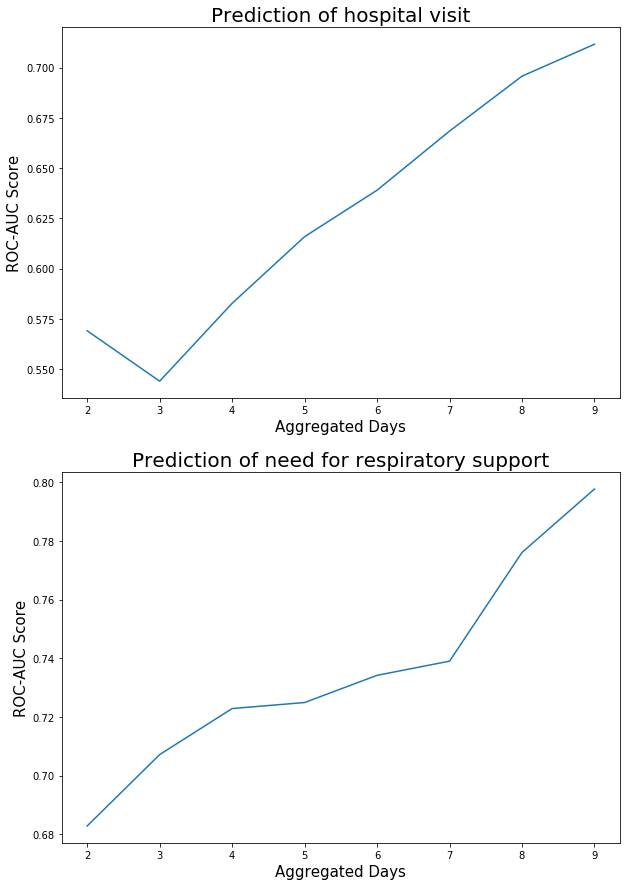

In [154]:
fig, ax = plt.subplots(2,1,figsize=(10,15))
ax[0].plot(list_roc1)
ax[0].set_xticklabels(np.arange(1,10))
ax[0].set_xlabel('Aggregated Days',fontsize=15)
ax[0].set_ylabel('ROC-AUC Score',fontsize=15)
ax[0].set_title('Prediction of hospital visit',fontsize=20)
ax[1].plot(list_roc)
ax[1].set_xticklabels(np.arange(1,10))
ax[1].set_xlabel('Aggregated Days',fontsize=15)
ax[1].set_ylabel('ROC-AUC Score',fontsize=15)
ax[1].set_title('Prediction of need for respiratory support',fontsize=20)

In [135]:
np.mean(np.asarray(tn_8)/(np.asarray(tn_8)+np.asarray(fp_8)))

0.6508045977011494

In [155]:
features8 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_values 
df_maxsum_clustproj_pos = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==1]
df_maxsum_clustproj_neg = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==0]
labels='treatment_bin'
models_8, tp_8, tn_8, fp_8, fn_8, predict_8, roc_8, lab_8 = test_model_balancing(df_maxsum_clustproj_pos,df_maxsum_clustproj_neg, features8, labels, num_iter=100, random_seed=33,const_needed=False )
print(np.mean((np.asarray(tp_8)+np.asarray(tn_8))/len(predict_8[0])),np.mean(roc_8))

0.7053846153846153 0.7819378698224853


In [68]:
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
df_maxsum_clustproj['treatment_bin'] = np.where(df_maxsum_clustproj['treatment_coded']>2,1,0)
df_maxsum_clustproj = salvaging_bmi(df_maxsum_clustproj)
df_maxsum_clustproj_pos = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==1]
df_maxsum_clustproj_neg = df_maxsum_clustproj[df_maxsum_clustproj['treatment_bin']==0]
labels='treatment_bin'
features8 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + list_mean[7:8]+['clusttest8']
models_8, tp_8, tn_8, fp_8, fn_8, predict_8, roc_8, lab_8 = test_model_balancing(df_maxsum_clustproj_pos,df_maxsum_clustproj_neg, features8, labels, num_iter=100, random_seed=33,const_needed=False )
print(np.mean((np.asarray(tp_8)+np.asarray(tn_8))/len(predict_8[0])),np.mean(roc_8))

0.8180473372781065 26.0 (52, 2)
0.6486686390532544 26.0 (52, 2)
0.8143491124260355 26.0 (52, 2)
0.7551775147928994 26.0 (52, 2)
0.8099112426035503 26.0 (52, 2)
0.8039940828402367 26.0 (52, 2)
0.7204142011834319 26.0 (52, 2)
0.7255917159763314 26.0 (52, 2)
0.8587278106508875 26.0 (52, 2)
0.757396449704142 26.0 (52, 2)
0.8431952662721893 26.0 (52, 2)
0.7877218934911242 26.0 (52, 2)
0.80103550295858 26.0 (52, 2)
0.8039940828402368 26.0 (52, 2)
0.7677514792899408 26.0 (52, 2)
0.6235207100591716 26.0 (52, 2)
0.7958579881656804 26.0 (52, 2)
0.7071005917159763 26.0 (52, 2)
0.7855029585798816 26.0 (52, 2)
0.8076923076923077 26.0 (52, 2)
0.8535502958579883 26.0 (52, 2)
0.6153846153846154 26.0 (52, 2)
0.8394970414201184 26.0 (52, 2)
0.812130177514793 26.0 (52, 2)
0.8387573964497042 26.0 (52, 2)
0.7884615384615384 26.0 (52, 2)
0.7566568047337279 26.0 (52, 2)
0.8313609467455622 26.0 (52, 2)
0.7699704142011834 26.0 (52, 2)
0.8217455621301776 26.0 (52, 2)
0.8431952662721893 26.0 (52, 2)
0.7965976331

In [213]:

list_start9 = [c for c in df_maxsum.columns if 'start9_' in c ]

labels='hosp_bin'
#labels='treatment_bin'
features8 = ['age','bmi_clean','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start9 + list_mean[8:9] + ['clust6_hosp']
models_9, tp_9, tn_9, fp_9, fn_9, predict_9 = test_model_balanced_random(df_maxsum, features8, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_9)+np.asarray(tn_9))/len(predict_9[0]))

435 763


0.6655172413793103

In [93]:
labels='treatment_bin'
list_start8 = [c for c in df_maxsum.columns if 'start8_' in c]
features8 = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start8 + list_mean[0:8]
models_8, tp_8, tn_8, fp_8, fn_8, predict_8 = test_model_balanced_random(df_maxsum, features8, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_8)+np.asarray(tn_8))/len(predict_8[0]))

128 1070


0.6796153846153846

In [76]:
list_start9 = [c for c in df_maxsum.columns if 'start9_' in c]
features9 = ['age','bmi','gender','has_lung_disease','has_heart_disease','has_diabetes'] + list_start9 + list_mean[0:9]
models_9, tp_9, tn_9, fp_9, fn_9, predict_9 = test_model_balanced_random(df_maxsum, features9, labels, num_iter=100, random_seed=33,const_needed=False )
np.mean((np.asarray(tp_9)+np.asarray(tn_9))/len(predict_9[0]))

435 763


0.6607471264367817

In [92]:
df_maxsum['treatment_bin'] = np.where(df_maxsum['treatment_coded']>2,1,0)

In [63]:
df_interp2[['fever','max_duration','sum_symp']].head(40)

fever  max_duration  sum_symp
patient_id                                                        
002a239ee36fcbe376cba5b9cc8891fe 0     NaN          13.0       4.0
                                 1     NaN           NaN       NaN
                                 2     0.0          13.0       5.0
                                 3     0.0          13.0       5.0
                                 4     0.0           NaN       NaN
                                 5     0.0           NaN       NaN
                                 6     0.0          13.0       5.0
                                 7     0.5           NaN       NaN
                                 8     1.0          13.0       6.0
                                 9     0.5           NaN       NaN
                                 10    0.0          13.0       5.0
                                 11    0.5           NaN       NaN
                                 12    1.0          13.0       6.0
                                 13    0.0          13.0       6.0
002d412f4cbf9cd66ff55bd7067fec20 0     0.0           9.0       1.0
                                 1     0.5           9.0       5.0
                                 2     1.0           9.0       5.0
                                 3     0.0           9.0       5.0
                                 4     0.0           9.0       4.0
                                 5     0.0           9.0       5.0
                                 6     0.0           9.0       4.0
                                 7     0.0           9.0       5.0
                                 8     0.0           NaN       NaN
                                 9     0.0           9.0       4.0
012dc0c364d81096b2f4481fdffb1260 0     0.0           8.0       2.0
                                 1     0.0           NaN       NaN
                                 2     0.0           NaN       NaN
                                 3     0.0           8.0       3.0
                                 4     0.0           8.0       7.0
                                 5     0.0           8.0       8.0
                                 6     0.0           8.0       8.0
                                 7     0.0           8.0       8.0
                                 8     0.0           8.0       7.0
016b91a472c9475bb2905b50dbca0a7a 0     0.0          19.0       2.0
                                 1     0.0           NaN       NaN
                                 2     0.0           NaN       NaN
                                 3     0.0          19.0       1.0
                                 4     0.0          19.0       2.0
                                 5     0.0           NaN       NaN
                                 6     0.0           NaN       NaN

In [60]:
pd_new = pd.DataFrame(list_p,columns=['patient_id'])

In [51]:
# pd_new['new'] = df_new
df_reattribution['old'] = 0
for f in classif_hosp.keys():
    df_reattribution['old'] = np.where(df_reattribution['patient_id'].isin(classif_hosp[f]),f,df_reattribution['old'])

/home/csudre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/csudre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [92]:
df_maxsum_clustproj = pd.merge(df_maxsum,df_reattribution,on='patient_id')

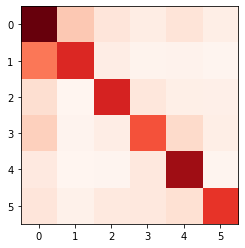

In [62]:
array_clust7 = np.asarray(df_reattribution.groupby(['clust6_new','clusttest7']).size().unstack())
size_clustfull = np.asarray(df_reattribution.groupby(['clust6_new']).size())
perc_clust7 = array_clust7 / size_clustfull
plt.imshow(perc_clust7,cmap='Reds')


In [62]:
pd_new.groupby(['old','new']).size().unstack()

new,0,1,2,3,4,5
old,,,,,,
1,331.0,4.0,NaN,NaN,3.0,2.0
2,NaN,284.0,NaN,1.0,NaN,1.0
3,NaN,NaN,141.0,NaN,1.0,NaN
4,2.0,NaN,NaN,149.0,1.0,NaN
5,2.0,NaN,NaN,1.0,130.0,NaN
6,1.0,NaN,NaN,NaN,NaN,144.0
